In [1]:
import pandas as pd
import os
import numpy as np
import csv
import tldextract
import matplotlib.pyplot as plt
import seaborn as sns
import re

import email.header
import email.utils
import string
import sys
from dataclasses import dataclass, field
from ietfdata.datatracker import *
from ietfdata.mailarchive import *
import datetime
from datetime import datetime
from datetime import date
import json
%config InlineBackend.figure_format = 'retina'

You will require installing IETF data library. The detailed instructions to installing ietfdata are available at - https://github.com/glasgow-ipl/ietfdata

In [2]:
import ietfdata.mailarchive as ma
from copy import deepcopy

In [131]:
!pip show ietfdata

Name: ietfdata
Version: 0.4.1
Summary: Access the IETF Data Tracker and RFC Index
Home-page: https://github.com/glasgow-ipl/ietfdata
Author: Colin Perkins
Author-email: csp@csperkins.org
License: UNKNOWN
Location: /Users/pkhare/anaconda3/envs/py39/lib/python3.9/site-packages/ietfdata-0.4.1-py3.9.egg
Requires: imapclient, pavlova, pymongo, python-dateutil, requests
Required-by: 


In [3]:
from datetime import date
import scipy
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

In [4]:
import networkx as nx
from networkx.algorithms import centrality
import networkx.algorithms.community as nx_comm
import community as cm
from networkx.algorithms.community.quality import modularity

In [31]:
from scipy import stats

In [73]:
from collections import Counter

Instantiate an archive object from IETF mailarchive class

In [5]:
archive = ma.MailArchive()

In [6]:
ren = r'(?:\.?)([\w\-_+#~!$&\'\.]+(?<!\.)(@|[ ]?\(?[ ]?(at|AT)[ ]?\)?[ ]?)(?<!\.)[\w]+[\w\-\.]*\.[a-zA-Z-]{2,3})(?:[^\w])'
ren2 = r'([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)'

Upload mapping dictionaries between email addresses and person IDs. The code/method to generate these disctionaries are provided in the instructions document.

In [7]:
emailID_pid_dict = json.load(open('../data/emailID_pid_dict.json'))
pid_emailID_dict = json.load(open('../data/pid_emailID_dict.json'))
name_pid_dict = json.load(open('../data/name_pid_dict.json'))

In [75]:
pid_name_dict = json.load(open('../data/pid_name_dict.json'))

Number of emails by email addresses across years and months are stored in json, upload them.

In [27]:
emailID_yearly_monthly_vol_dict = json.load(open('../data/emailID_yearly_monthly_vol_dict.json'))

In [35]:
maillist_area_type_status = json.load(open('../data/maillist_area_type_status.json'))

In [8]:
role_based_emailIDs = set()
with open('../data/role_based_emailIDs_newData.txt') as f:
    Lines = f.readlines()
    for line in Lines:
        line = line.strip()
        role_based_emailIDs.add(line)
        #print(line)
print(len(role_based_emailIDs))

856


In [9]:
automated_list = set()
with open('../data/automated_email_IDs_newData.txt') as f2:
    Lines2 = f2.readlines()
    for line in Lines2:
        line = line.strip()
        automated_list.add(line)
        #print(line)
print(len(automated_list))

685


emailID_yearly_monthly_mailinglist_dict.json contains information about mailing lists the participants sent an email to across months and years.

In [10]:
emailID_yearly_monthly_mailinglist_dict = json.load(open('../data/emailID_yearly_monthly_mailinglist_dict.json'))

In [11]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

The below mapping is the interaction mapping of participants across IETF mailing lists. If a participant responds to another participant in the mailing list, it is considered an interaction. The code to generate this file is provided in the codebase.

In [12]:
df_mappings = pd.read_csv('../data/personID_to_personID_graph_new_with_mlisttype.csv',delimiter='\t',header=0)
df_mappings['Interaction_timestamp'] = pd.to_datetime(df_mappings['Interaction_timestamp'], format='%Y-%m-%d').dt.date
df_mappings.head(2)

A_PersonID_From  B_PersonID_To        Type  Time_since_1st_mail_A  \
0           100005         100001    reply_to                    0.0   
1           100001         100001  reply_self                    6.5   

   Time_since_1st_mail_B  Max_Time_A  Max_Time_B Interaction_timestamp  \
0                    6.5         0.0         9.5            2017-11-13   
1                    6.5         9.5         9.5            2017-11-14   

                                         MessageID_A  \
0  <CAKFu26gHc2mutnyNhRMz9YekRb60angmBiWgz5Z6sUDC...   
1   <277920060.1462457.1510625963022@mail.yahoo.com>   

                                        MessageID_B   Mailing_list  \
0  <1262915113.716847.1510540285719@mail.yahoo.com>  100-newcomers   
1  <1262915113.716847.1510540285719@mail.yahoo.com>  100-newcomers   

  Mailinglist_type  
0            other  
1            other

spam res folder contains message IDs of the emails that have been given a spam score using spam detection libraries.

In [13]:
spam_messageIDs = set([])

for file in os.listdir("../data/spamres/"):
    if file.endswith(".csv"):
        fname = os.path.join("../data/spamres/", file)
        fdf = pd.read_csv(fname)
        #print(file)
        for i, r in fdf.iterrows():
            
            if r['header_flag'] == r['header_flag'] and 'yes' in r['header_flag'].lower():
                spam_messageIDs.add(r['mid'])
            elif r['SA_score'] >= 6.5:
                spam_messageIDs.add(r['mid'])
            
        #print(file,len(spam_messageIDs))
print(len(spam_messageIDs))

/Users/pkhare/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


22125


pid_rolebased = set([])
for eid in emailID_pid_dict:
    if eid in role_based_emailIDs:
        #print(eid)
        pid_rolebased.add(int(emailID_pid_dict[eid]))
print(len(pid_rolebased))

Below we go through the interaction mappings and generate social graph for each year, based on previous 5 years interactions between participants. Next, we evaluate largest connected components and remove participants from the largest connected component one by one as per highest betweenness centrality.

In [15]:
yearly_lcc_dict1 = dict()
yearly_lcc_trimmed_dict1 = dict()
yearly_nodes_active1 = dict()
yearly_connected_components = dict()

yearly_connected_trimmed_components = dict()

lst_spam_messageIDs = list(spam_messageIDs)
for yr in range(2000, 2021):
    for typ in ['overall']:#'wg',#['wg','rg','meeting','overall']:#,'dir','review','announcements']:
        
        if typ != 'overall':
            
            #LOOKING AT 5 YEAR HISTORY BELOW
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to')  & (df_mappings.Interaction_timestamp <= date(yr,12,31))  & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (df_mappings.Mailinglist_type == typ) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        else:
            
            #LOOKING AT 5 YEAR HISTORY BELOW
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to') & (df_mappings.Interaction_timestamp <= date(yr,12,31)) & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        
        G1 = nx.Graph()
        
        for i, r in df_mappings4.iterrows():
            
            if r['A_PersonID_From'] in pid_rolebased:
                continue
            if r['B_PersonID_To'] in pid_rolebased:
                continue
                
            if r['A_PersonID_From'] not in G1:
                G1.add_nodes_from([r['A_PersonID_From']])
            if r['B_PersonID_To'] not in G1:
                G1.add_nodes_from([r['B_PersonID_To']])
                
            G1.add_edges_from([(r['A_PersonID_From'], r['B_PersonID_To'])])
            
        if len(G1) > 0:
            
            largest_cc = max(nx.connected_components(G1), key=len)
            total_components = len(sorted(nx.connected_components(G1), key=len))#, reverse=True))
            
            if yr not in yearly_lcc_dict1:
                yearly_lcc_dict1[yr] = {typ :len(largest_cc)}
                yearly_connected_components[yr] = {typ :total_components}
                
            else:
                yearly_lcc_dict1[yr][typ] = len(largest_cc)
                yearly_connected_components[yr][typ] = total_components
                
            d = centrality.betweenness_centrality(G1)
            d = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
            
            l = len(d)
            
            yearly_nodes_active1[yr] = len(G1)
            
            #for i in [0,10,20,30,40,50,60,70,80,90,100]:
            for i in range(0,101):
                lst = []
                #G2 = copy.deepcopy(G1)
                G2 = deepcopy(G1)
                c = 0
                for k in d:
                    if i == 0:
                        break
                    lst.append(k)
                    if int(len(lst)*100/len(G2)) > i:
                        break
                #print(i,'Before removal ',len(G2),l)
                G2.remove_nodes_from(lst)
                #print(i,'After removal ',len(G2),l)
                
                if len(G2) >0:
                    largest_cc1 = max(nx.connected_components(G2), key=len)
                    
                    total_components1 = len(sorted(nx.connected_components(G2), key=len))
                else:
                    largest_cc1 = []
                    
                    total_components1 = 0
            
                if yr not in yearly_lcc_trimmed_dict1:
                    yearly_lcc_trimmed_dict1[yr] = {typ :{i: len(largest_cc1)}}
                    
                    yearly_connected_trimmed_components[yr] = {typ : {i: total_components1}}
                    
                else:
                    if typ not in yearly_lcc_trimmed_dict1[yr]:
                        yearly_lcc_trimmed_dict1[yr][typ] = {i: len(largest_cc1)}
                        
                        yearly_connected_trimmed_components[yr][typ] = {i: total_components1}
                    else:
                        yearly_lcc_trimmed_dict1[yr][typ][i] = len(largest_cc1)
                        
                        yearly_connected_trimmed_components[yr][typ][i] = total_components1
                        
        print(yr, typ,len(yearly_lcc_dict1),len(G1))

2000 overall 1 2550
2001 overall 2 3541
2002 overall 3 4761
2003 overall 4 6143
2004 overall 5 6951
2005 overall 6 7620
2006 overall 7 8104
2007 overall 8 8237
2008 overall 9 8063
2009 overall 10 8311
2010 overall 11 8336
2011 overall 12 8247
2012 overall 13 8165
2013 overall 14 8240
2014 overall 15 8197
2015 overall 16 8056
2016 overall 17 7889
2017 overall 18 7675
2018 overall 19 7259
2019 overall 20 6850
2020 overall 21 6437


In [17]:
sns.set_style('whitegrid')

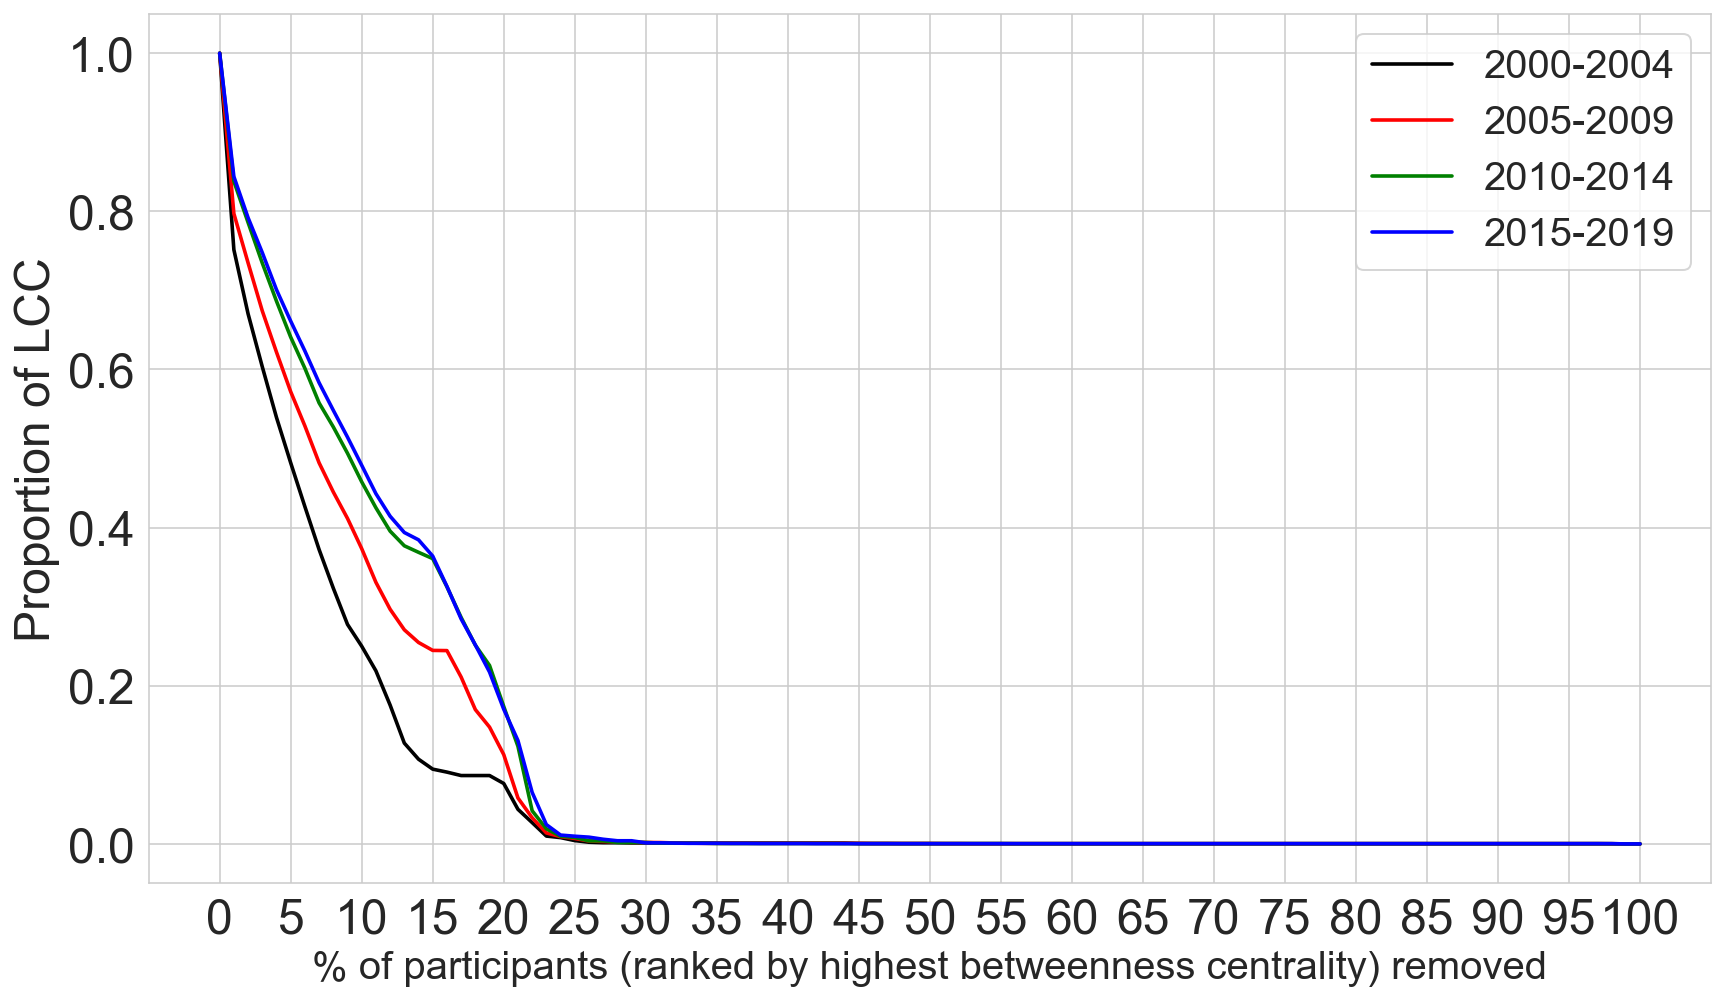

In [18]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}

fig, ax1 = plt.subplots(figsize=(14,8))

for yr in [2004,2009,2014,2019]:
    y1 = []
    
    x1 = [i for i in range(0,101)]
    
    for i in range(0,101):
        y1.append(yearly_lcc_trimmed_dict1[yr]['overall'][i]/yearly_lcc_trimmed_dict1[yr]['overall'][0])
    
    sns.lineplot(x = x1,y=y1,color=color_dict[yr], linewidth=1.8,label=str(yr-4)+'-'+str(yr),ax=ax1,linestyle="-",legend=False)
        
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0], size = 24)

ax1.set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
ax1.set_xticklabels([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],size = 24)#,rotation=90)#fontsize='x-large')

ax1.set_xlabel('% of participants (ranked by highest betweenness centrality) removed',fontsize=20)
ax1.set_ylabel('Proportion of LCC',fontsize=24)

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes,fontsize=20)

plt.savefig('../plots/lcc_proportion_granular_yearly.pdf', bbox_inches='tight')

Below, we perform a comparison between betweenness centrality and eigen vector centrality.

In [29]:
yearly_top_bwcnt_nodes = dict()

yearly_top_egnvc_nodes = dict()

lst_spam_messageIDs = list(spam_messageIDs)
for yr in range(2000, 2020):
    for typ in ['overall']:#'wg',#['wg','rg','meeting','overall']:#,'dir','review','announcements']:
        
        if typ != 'overall':
            
            #LOOKING FOR LAST 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to')  & (df_mappings.Interaction_timestamp <= date(yr,12,31))  & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (df_mappings.Mailinglist_type == typ) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        else:
            
            #LOOKING FOR LAST 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to') & (df_mappings.Interaction_timestamp <= date(yr,12,31)) & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        
        G1 = nx.Graph()
        
        for i, r in df_mappings4.iterrows():
            
            if r['A_PersonID_From'] in pid_rolebased:
                continue
            if r['B_PersonID_To'] in pid_rolebased:
                continue
                
            if r['A_PersonID_From'] not in G1:
                G1.add_nodes_from([r['A_PersonID_From']])
            if r['B_PersonID_To'] not in G1:
                G1.add_nodes_from([r['B_PersonID_To']])
                
            G1.add_edges_from([(r['A_PersonID_From'], r['B_PersonID_To'])])
            
        if len(G1) > 0:
          
            d = centrality.betweenness_centrality(G1)
            d = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
            
            l = len(d)
            
            ordered_nodes = []
            
            for k in d:
                ordered_nodes.append(k)
            
            for i in [10,20,30,40,50,60,70,80,90,100]:#[0,10,20,30,40,50,60,70,80,90,100]:
                
                lst = ordered_nodes[int(len(ordered_nodes)*(i-10)/100):int(len(ordered_nodes)*(i)/100)]
                if len(lst) == 0:
                    print(yr, i, 'ZERO LENGTH')
                if yr not in yearly_top_bwcnt_nodes:
                    yearly_top_bwcnt_nodes[yr] = {typ:{i: lst}}
                else:
                    if typ not in yearly_top_bwcnt_nodes[yr]:
                        yearly_top_bwcnt_nodes[yr][typ] = {i: lst}
                    else:
                        yearly_top_bwcnt_nodes[yr][typ][i] = lst
            
            degn = centrality.eigenvector_centrality(G1)
            degn = dict(sorted(degn.items(), key=lambda x: x[1], reverse=True))
            
            l = len(degn)
            
            ordered_nodes_egn = []
            
            for k in degn:
                ordered_nodes_egn.append(k)
            
            for i in [10,20,30,40,50,60,70,80,90,100]:#[0,10,20,30,40,50,60,70,80,90,100]:
                
                lst = ordered_nodes_egn[int(len(ordered_nodes_egn)*(i-10)/100):int(len(ordered_nodes_egn)*(i)/100)]
                if len(lst) == 0:
                    print(yr, i, 'ZERO LENGTH')
                if yr not in yearly_top_egnvc_nodes:
                    yearly_top_egnvc_nodes[yr] = {typ:{i: lst}}
                else:
                    if typ not in yearly_top_egnvc_nodes[yr]:
                        yearly_top_egnvc_nodes[yr][typ] = {i: lst}
                    else:
                        yearly_top_egnvc_nodes[yr][typ][i] = lst
                        
        print(yr, typ,len(yearly_top_bwcnt_nodes),len(yearly_top_egnvc_nodes),len(G1))

2000 overall 1 1 2550
2001 overall 2 2 3541
2002 overall 3 3 4761
2003 overall 4 4 6143
2004 overall 5 5 6951
2005 overall 6 6 7620
2006 overall 7 7 8104
2007 overall 8 8 8237
2008 overall 9 9 8063
2009 overall 10 10 8311
2010 overall 11 11 8336
2011 overall 12 12 8247
2012 overall 13 13 8165
2013 overall 14 14 8240
2014 overall 15 15 8197
2015 overall 16 16 8056
2016 overall 17 17 7889
2017 overall 18 18 7675
2018 overall 19 19 7259
2019 overall 20 20 6850


We perform spearmann rank correlation between participant's ranking as per betweenness centrality and eigen vector centrality. We find a strong correlation between the two centrality metrics in the data and continue using betweenness centrality.

In [32]:
spr_corr = []
p_val = []
for yr in range(2000,2020):#[2004,2009,2014,2019]:
    
    list_overlap_author = []
    list_overlap_person = []
    for i in [10,20,30,40,50,60,70,80,90,100]:
        for p in yearly_top_egnvc_nodes[yr]['overall'][i]:
            if p not in list_overlap_author:
            #if p in overlap_ and p not in list_overlap_author:
                list_overlap_author.append(p)
    
    for i in [10,20,30,40,50,60,70,80,90,100]:
        for p in yearly_top_bwcnt_nodes[yr]['overall'][i]:
            if p not in list_overlap_person:
            #if p in overlap_ and p not in list_overlap_person:
                list_overlap_person.append(p)
    
    rank_author = []
    rank_person = []
    
    for p in list_overlap_author:#overlap_:
        rank_author.append(list_overlap_author.index(p)+1)
        rank_person.append(list_overlap_person.index(p)+1)
    sc = stats.spearmanr(rank_author, rank_person)
    print(yr,sc.correlation, sc.pvalue)#,round(stats.spearmanr(rank_author, rank_person).correlation,3),round(stats.spearmanr(rank_author, rank_person).pvalue,2))
    spr_corr.append(sc.correlation)
    p_val.append(sc.pvalue)

2000 0.5150581034080807 8.357397577775815e-173
2001 0.5273806118137924 8.869240097502287e-253
2002 0.5199883237962951 0.0
2003 0.5291597004254849 0.0
2004 0.5211913467587468 0.0
2005 0.5146963923042445 0.0
2006 0.5149008735768577 0.0
2007 0.530790790299949 0.0
2008 0.5565845298790126 0.0
2009 0.5971694991595727 0.0
2010 0.6302744595573547 0.0
2011 0.647490253767121 0.0
2012 0.6781943082600655 0.0
2013 0.7058737984554642 0.0
2014 0.7074222180976502 0.0
2015 0.7174243769283833 0.0
2016 0.7204702636918008 0.0
2017 0.7099037215084013 0.0
2018 0.7132845854456296 0.0
2019 0.7126436792198013 0.0


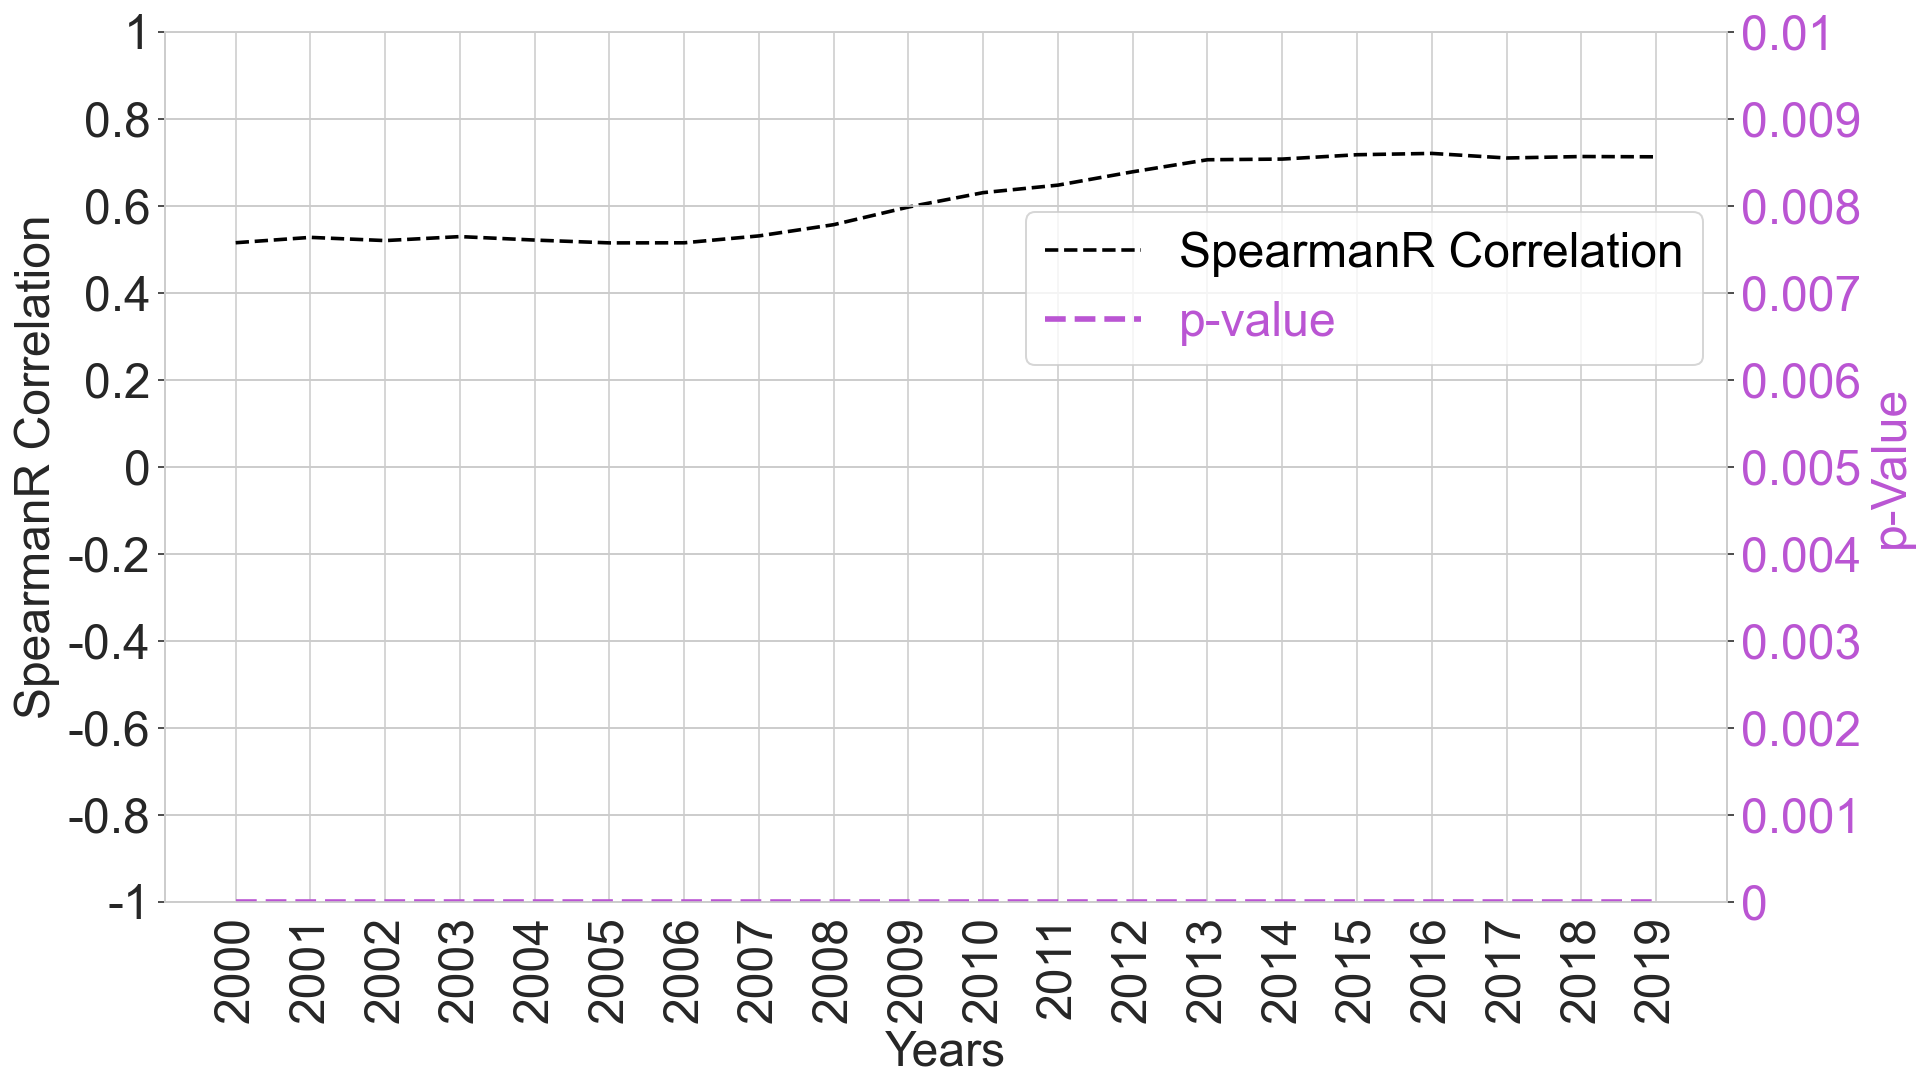

In [33]:
fig, ax_h = plt.subplots(figsize=(14,8))

sns.lineplot(x = [i for i in range(2000,2020)],y = spr_corr, linewidth=1.8,ax=ax_h,linestyle="--",color="black",label= 'SpearmanR Correlation',legend=False)
ax_h.set_xticks([i for i in range(2000,2020)])
ax_h.set_xticklabels([i for i in range(2000,2020)], rotation = 90,#ax_hx.get_xticklabels(), rotation=45,
    horizontalalignment='center',size = 24)#horizontalalignment='right'
   
ax_h.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax_h.set_yticklabels([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1], size = 24)

ax_h.set_xlabel('Years',fontdict={'fontsize': 24})
ax_h.set_ylabel('SpearmanR Correlation',fontdict={'fontsize': 24})

## Second Axis
ax_h_2 = ax_h.twinx()
    
sns.lineplot(x=[i for i in range(2000,2020)], y=p_val,color='mediumorchid', linewidth=2.8,ax=ax_h_2,label='p-value',linestyle='--',legend=False)#Age of new influencers

ax_h_2.set_ylabel('p-Value',fontsize=24,color="mediumorchid")
ax_h_2.set_yticks([0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01])
ax_h_2.set_yticklabels([0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01], size = 24,color="mediumorchid")

fig.legend(bbox_to_anchor=(1,0.82),bbox_transform=ax_h.transAxes,fontsize=24,labelcolor=["black","mediumorchid","mediumorchid"])
plt.savefig('../plots/correlation_betweenness_cnt_eignvector_centrality.pdf', bbox_inches='tight')

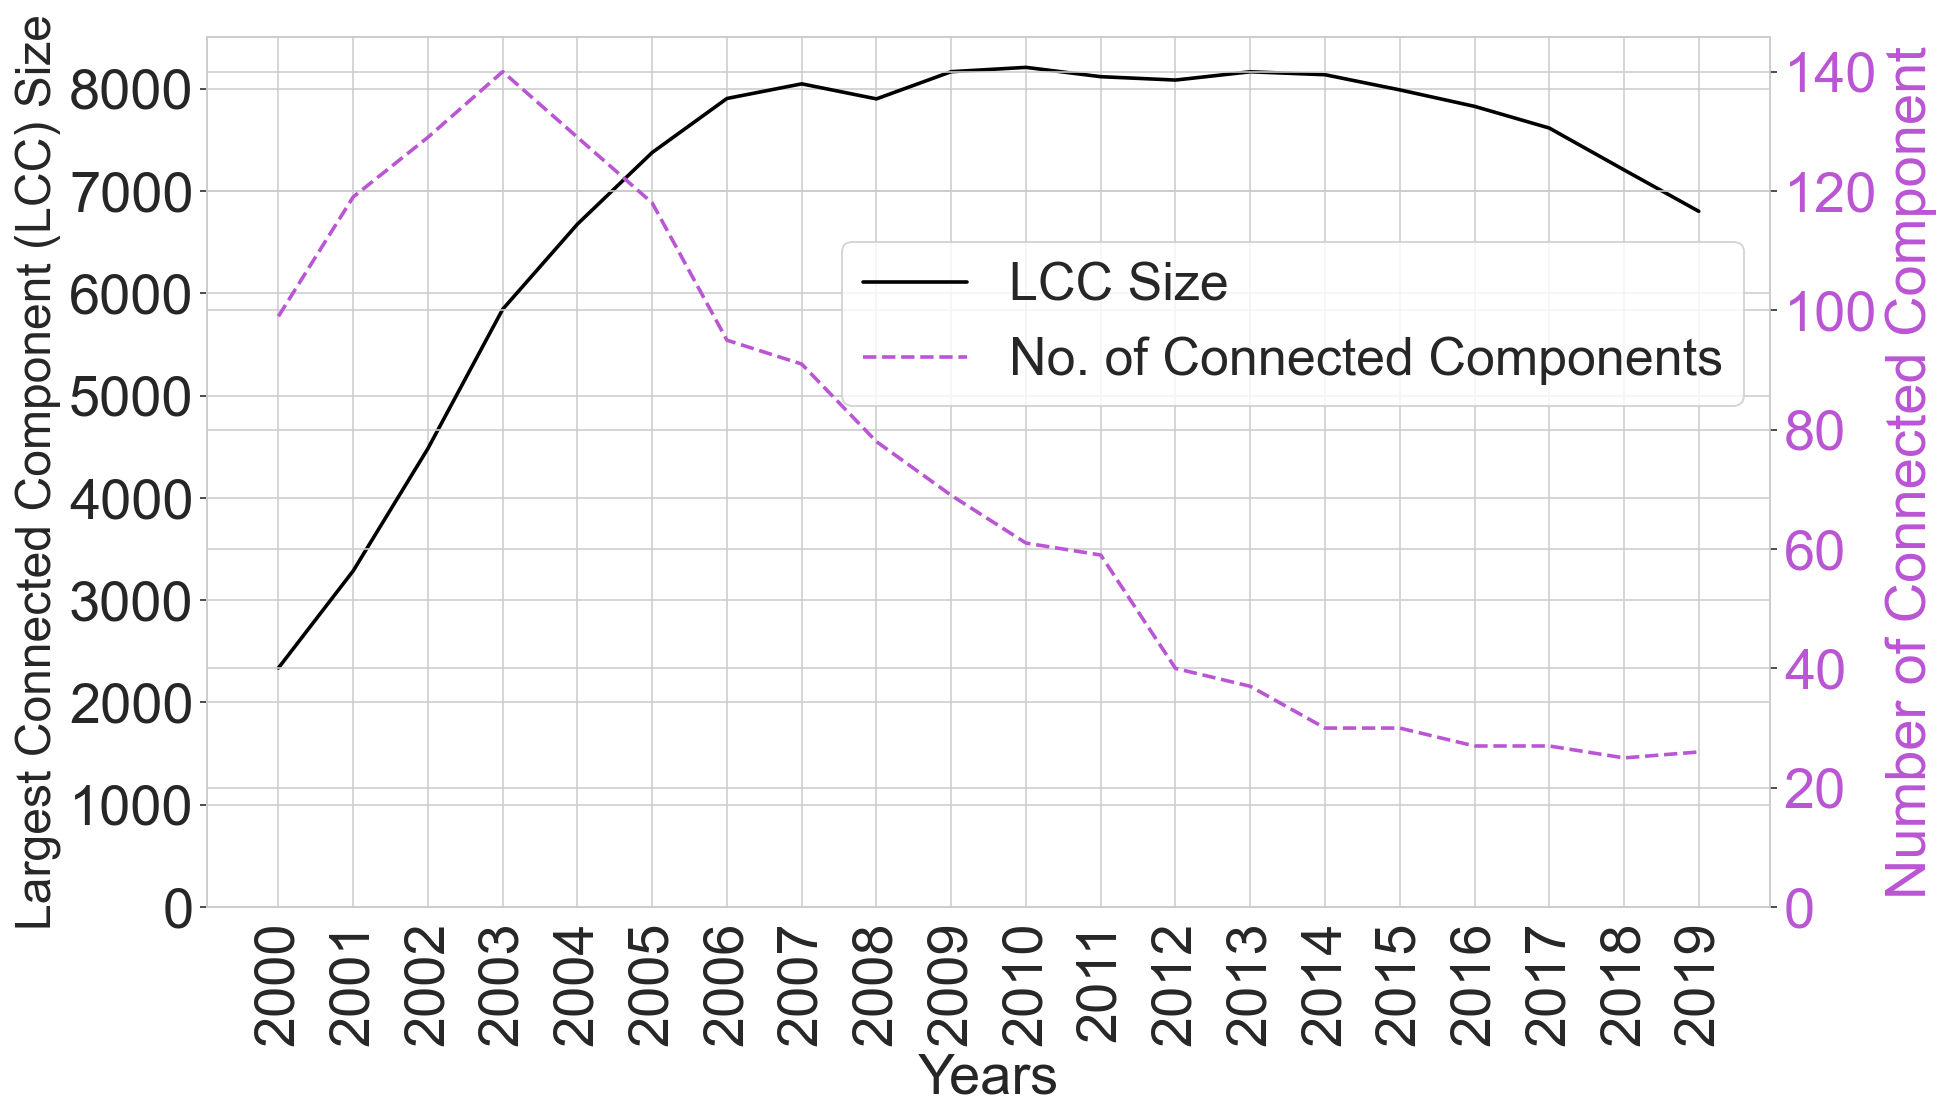

In [19]:
x1 = []
y1 = []
c = 0
for k in yearly_lcc_dict1:
    
    if k == 2020:
        continue
    x1.append(k)
    y1.append(yearly_lcc_dict1[k]['overall'])

fig, ax_h = plt.subplots(figsize=(14,8))

sns.lineplot(x=x1,y=y1, linewidth=1.8,ax=ax_h,linestyle="-",color="black",label="LCC Size",legend=False)#)#label=yr,

ax_h.set_xticks(x1)
ax_h.set_xticklabels(x1, rotation = 90,#ax_hx.get_xticklabels(), rotation=45,
    horizontalalignment='center',size = 28)#
   
ax_h.set_yticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax_h.set_yticklabels([0,1000,2000,3000,4000,5000,6000,7000,8000], size = 28)

ax_h.set_xlabel('Years',fontdict={'fontsize': 28})
ax_h.set_ylabel('Largest Connected Component (LCC) Size',fontdict={'fontsize': 24})

ax_h_2 = ax_h.twinx()
y1 = []
x1 = []
for yr in range(2000,2020):#range(2000,2021):
    x1.append(yr)
    y1.append(yearly_connected_components[yr]['overall'])
    
sns.lineplot(x=x1,y=y1, linewidth=1.8,ax=ax_h_2,linestyle="--",color="mediumorchid",label='No. of Connected Components',legend=False)#)#label=yr,color=color_dict[yr]

ax_h_2.set_yticks([0,20,40,60,80,100,120,140])
ax_h_2.set_yticklabels([0,20,40,60,80,100,120,140], size = 28,color="mediumorchid")

ax_h_2.set_ylabel('Number of Connected Component',fontsize=28,color="mediumorchid")

fig.legend(bbox_to_anchor=(1,0.795),bbox_transform=ax_h.transAxes,fontsize=26)
plt.savefig('../plots/lcc_yearly_no_components.pdf', bbox_inches='tight')

Below we count the degree of each node in the social graph over the years.

In [20]:
#lst_spam_messageIDs = list(spam_messageIDs)
yearly_degree = dict()

for yr in [2004,2009,2014,2019]:
    for typ in ['overall']:#'wg',
        
        if typ != 'overall':
            #LOOKING FOR LAST 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to')  & (df_mappings.Interaction_timestamp <= date(yr,12,31))  & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (df_mappings.Mailinglist_type == typ) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        else:
            #LOOKING FOR LAST 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to') & (df_mappings.Interaction_timestamp <= date(yr,12,31)) & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        
        G1 = nx.Graph()
        
        for i, r in df_mappings4.iterrows():
            
            if r['A_PersonID_From'] in pid_rolebased:
                continue
            if r['B_PersonID_To'] in pid_rolebased:
                continue
                
            if r['A_PersonID_From'] not in G1:
                G1.add_nodes_from([r['A_PersonID_From']])
            if r['B_PersonID_To'] not in G1:
                G1.add_nodes_from([r['B_PersonID_To']])
                
            G1.add_edges_from([(r['A_PersonID_From'], r['B_PersonID_To'])])
            
        if len(G1) > 0:
            
            yearly_degree[yr] = [i[1] for i in G1.degree]
                        
        print(yr, typ,len(yearly_degree),len(G1))

2004 overall 1 6951
2009 overall 2 8311
2014 overall 3 8197
2019 overall 4 6850


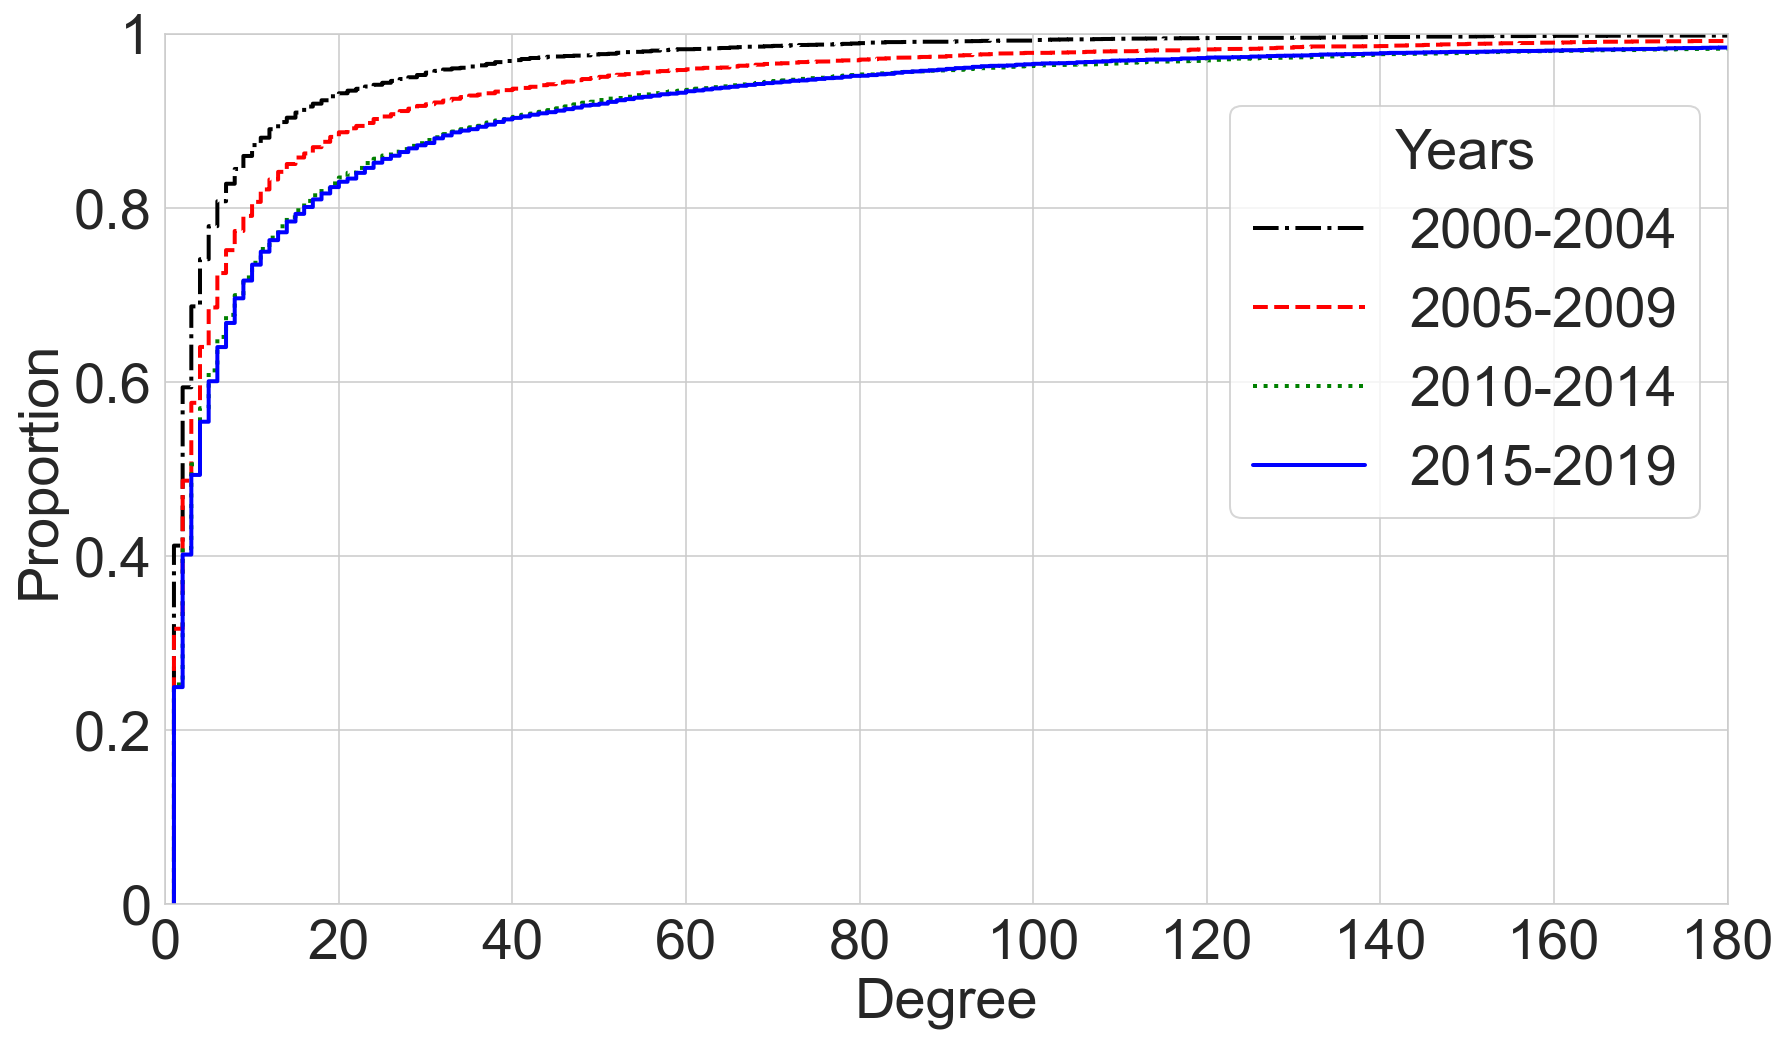

In [21]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}

fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004,2009,2014,2019]:
    sns.ecdfplot(yearly_degree[yr],color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)

ax_h.set_xlabel('Degree',fontdict={'fontsize': 28})
ax_h.set_ylabel('Proportion',fontdict={'fontsize': 28})
ax_h.set_xlim(0,180)

###
ax_h.set_xticks([0,20,40,60,80,100,120,140,160,180])
ax_h.set_xticklabels([0,20,40,60,80,100,120,140,160,180],size = 28)#,rotation=90)#fontsize='x-large')
ax_h.set_yticks([0, 0.2,0.4,0.6,0.8,1])
ax_h.set_yticklabels([0, 0.2,0.4,0.6,0.8,1], size = 28)

legend1 = fig.legend(loc="upper right", bbox_to_anchor=(1,0.95), bbox_transform=ax_h.transAxes,fontsize=28,title="Years")
legend1.get_title().set_fontsize('28')
###

plt.savefig('../plots/degree_CDF.pdf', bbox_inches='tight')

In [22]:
yearly_top10lcc_members = dict()

lst_spam_messageIDs = list(spam_messageIDs)
# Starting from the year 1995, so as to show the growth from the year 2000 more settled
for yr in range(1995, 2020):#[2000,2005,2010,2015,2019]:#range(2000, 2021):
    for typ in ['overall']:#'wg'#['wg','rg','meeting','overall']:#,'dir','review','announcements']:
        
        if typ != 'overall':
            
            #LOOKING FOR 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to')  & (df_mappings.Interaction_timestamp <= date(yr,12,31))  & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (df_mappings.Mailinglist_type == typ) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        else:

            #LOOKING FOR 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to') & (df_mappings.Interaction_timestamp <= date(yr,12,31)) & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        
        G1 = nx.Graph()
        
        for i, r in df_mappings4.iterrows():
            
            if r['A_PersonID_From'] in pid_rolebased:
                continue
            if r['B_PersonID_To'] in pid_rolebased:
                continue
                
            if r['A_PersonID_From'] not in G1:
                G1.add_nodes_from([r['A_PersonID_From']])
            if r['B_PersonID_To'] not in G1:
                G1.add_nodes_from([r['B_PersonID_To']])
                
            G1.add_edges_from([(r['A_PersonID_From'], r['B_PersonID_To'])])
            
        if len(G1) > 0:
            d = centrality.betweenness_centrality(G1)
            d = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
                        
            for i in [10]:#[0,10,20,30,40,50,60,70,80,90,100]:
                lst = []
                #G2 = deepcopy(G1)
                c = 0
                for k in d:
                    if i == 0:
                        break
                    lst.append(k)
                    if int(len(lst)*100/len(G1)) > i:
                        break
                
                if yr not in yearly_top10lcc_members:
                    yearly_top10lcc_members[yr] = {typ :{i: lst}}
                    
                else:
                    if typ not in yearly_top10lcc_members[yr]:
                        yearly_top10lcc_members[yr][typ] = {i: lst}
                    else:
                        yearly_top10lcc_members[yr][typ][i] = lst
            print(yr, typ,len(yearly_top10lcc_members),len(G1))

1995 overall 1 251
1996 overall 2 440
1997 overall 3 839
1998 overall 4 1198
1999 overall 5 1764
2000 overall 6 2550
2001 overall 7 3541
2002 overall 8 4761
2003 overall 9 6143
2004 overall 10 6951
2005 overall 11 7620
2006 overall 12 8104
2007 overall 13 8237
2008 overall 14 8063
2009 overall 15 8311
2010 overall 16 8336
2011 overall 17 8247
2012 overall 18 8165
2013 overall 19 8240
2014 overall 20 8197
2015 overall 21 8056
2016 overall 22 7889
2017 overall 23 7675
2018 overall 24 7259
2019 overall 25 6850


In [23]:
year_by_year_influencer_overlap_df = pd.DataFrame(index=[i for i in range(2000,2020)], columns=[i for i in range(2000,2020)])#Years is [1995,2020],moving it to 2000
year_by_year_influencer_overlap_df = year_by_year_influencer_overlap_df.fillna(0)

for j in range(2000,2020):
    for i in range(j,2020):
        
        year_by_year_influencer_overlap_df.at[i,j] = float(len(set(yearly_top10lcc_members[j]['overall'][10]).intersection(set(yearly_top10lcc_members[i]['overall'][10])))*100/len(set(yearly_top10lcc_members[i]['overall'][10])))
print('Done')

Done


In [24]:
year_by_year_influencer_overlap_df.head()

2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  \
2000   100     0     0     0     0     0     0     0     0     0     0     0   
2001    64   100     0     0     0     0     0     0     0     0     0     0   
2002    42    63   100     0     0     0     0     0     0     0     0     0   
2003    29    44    66   100     0     0     0     0     0     0     0     0   
2004    22    36    54    79   100     0     0     0     0     0     0     0   

      2012  2013  2014  2015  2016  2017  2018  2019  
2000     0     0     0     0     0     0     0     0  
2001     0     0     0     0     0     0     0     0  
2002     0     0     0     0     0     0     0     0  
2003     0     0     0     0     0     0     0     0  
2004     0     0     0     0     0     0     0     0

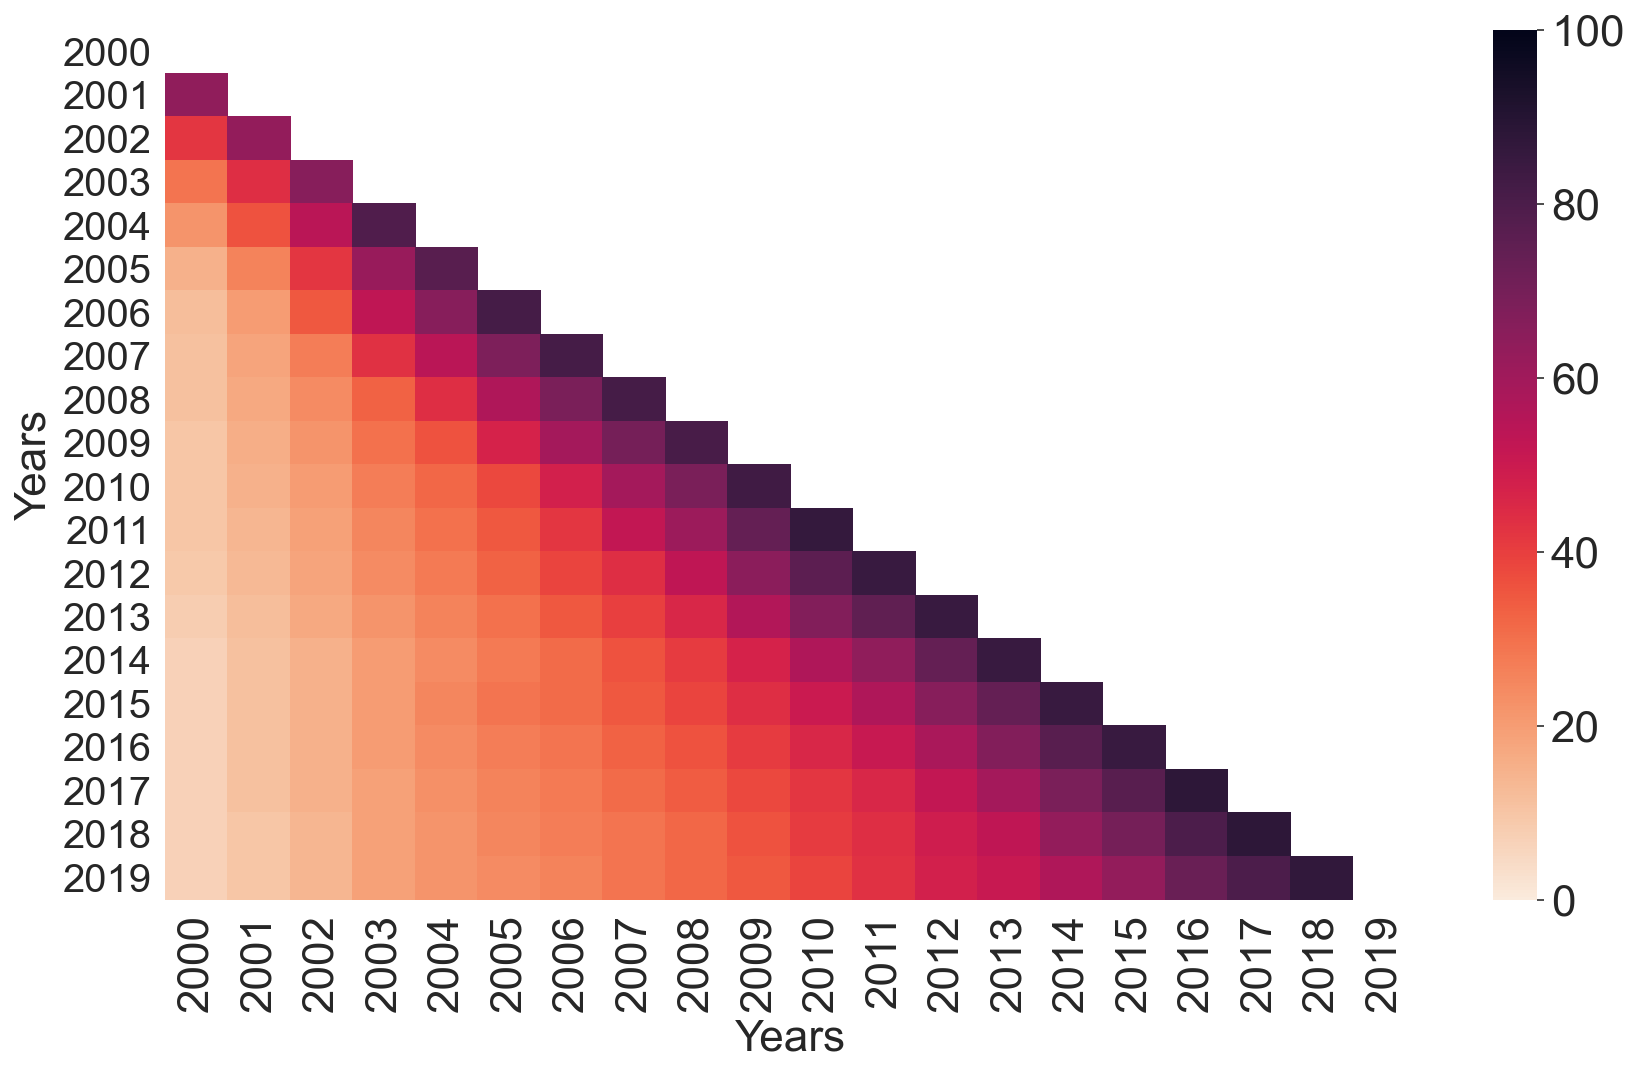

In [25]:
fig, ax_h = plt.subplots(figsize=(14,8))

mask = np.zeros_like(year_by_year_influencer_overlap_df, dtype='bool')
mask[np.triu_indices_from(mask)] = True

sns.heatmap(year_by_year_influencer_overlap_df, vmin=0, vmax=100, ax=ax_h,mask=mask,cmap = 'rocket_r')#cmap = 'rocket','flare'

cbar = ax_h.collections[0].colorbar

cbar.ax.tick_params(labelsize=22)

ax_h.set_xticklabels(ax_h.get_xticklabels(), rotation=90,
    horizontalalignment='center',size = 22)

ax_h.set_xlabel('Years',fontdict={'fontsize': 22})
ax_h.set_ylabel('Years',fontdict={'fontsize': 22})

ax_h.set_yticklabels([i for i in range(2000,2020)], size = 20)

plt.savefig('../plots/heatmap_top10_percent_overlap.pdf', bbox_inches='tight')

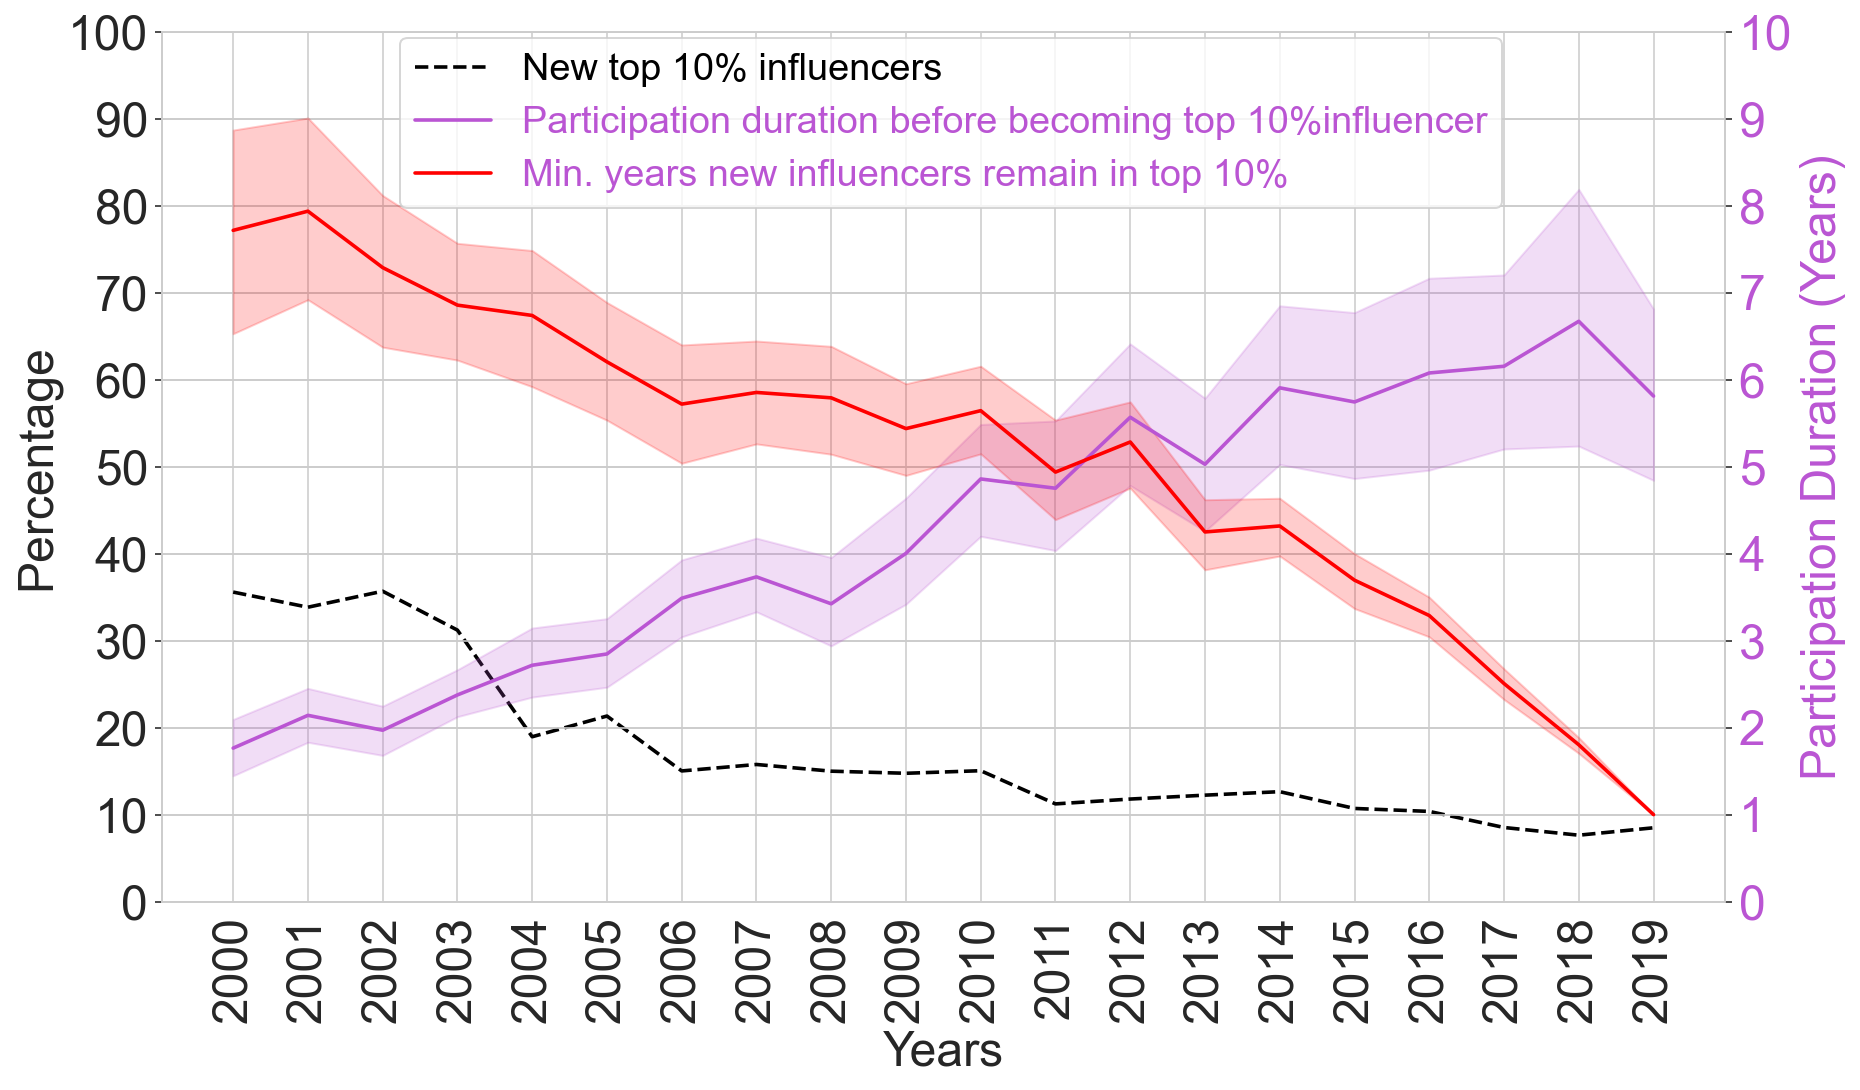

In [28]:
influencers_covered = set([])
influencers_covered.update(yearly_top10lcc_members[1995]['overall'][10])
influencers_covered.update(yearly_top10lcc_members[1996]['overall'][10])
influencers_covered.update(yearly_top10lcc_members[1997]['overall'][10])
influencers_covered.update(yearly_top10lcc_members[1998]['overall'][10])
influencers_covered.update(yearly_top10lcc_members[1999]['overall'][10])

x1 = []
y1 = []
x2 = []
y2 = []
y3 = []
c = 0
for yr in range(2000,2020):
    x1.append(yr)
    
    y1.append((len(yearly_top10lcc_members[yr]['overall'][10])-len(set(yearly_top10lcc_members[yr]['overall'][10]).intersection(influencers_covered)))*100/len(yearly_top10lcc_members[yr]['overall'][10]))
    
    new_members = set(yearly_top10lcc_members[yr]['overall'][10]) - (set(yearly_top10lcc_members[yr]['overall'][10]).intersection(influencers_covered))
    
    influencers_covered.update(yearly_top10lcc_members[yr]['overall'][10])
    
    for pid in new_members:
        years = set([])
        pid = str(pid)
        for eid in pid_emailID_dict[pid]:
            
            for eid in pid_emailID_dict[pid]:
                if eid in emailID_yearly_monthly_vol_dict and eid not in role_based_emailIDs and eid not in automated_list:
                    for year in emailID_yearly_monthly_vol_dict[eid]:
                        if int(year) <= int(yr):
                            for month in emailID_yearly_monthly_vol_dict[eid][year]:
                                t_date = date(int(year),int(month),1)
                                years.add(t_date)

        if years and int(max(years).year)>1994 and int(min(years).year)>1994:
            year_born = min(years)
            #AGE to be calculated as per last email in the time period
            age = round_to(((min(date(int(yr),12,31),max(years))-year_born).days)/365,0.5)
            
            if age >= 0:
                x2.append(yr)
                y2.append(age)
                
                c = 0
                for continuedyrs in range(yr, 2020):
                    #if int(pid) not in yearly_top10lcc_members[continuedyrs]['overall'][10]:
                    #    break
                    if int(pid) in yearly_top10lcc_members[continuedyrs]['overall'][10]:
                        c += 1
                y3.append(c)
                    

fig, ax_h = plt.subplots(figsize=(14,8))

sns.lineplot(x=x1,y=y1, linewidth=1.8,ax=ax_h,linestyle="--",color="black",label='New top 10% influencers',legend=False)
ax_h.set_xticks(x1)
ax_h.set_xticklabels(x1, rotation = 90,
    horizontalalignment='center',size = 24)
   
ax_h.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
ax_h.set_yticklabels([0,10,20,30,40,50,60,70,80,90,100], size = 24)

ax_h.set_xlabel('Years',fontdict={'fontsize': 24})
ax_h.set_ylabel('Percentage',fontdict={'fontsize': 24})

## Second Axis
ax_h_2 = ax_h.twinx()

new_influencer_age = pd.DataFrame({
    "Years":x2,
    "Age":y2
    })
    
sns.lineplot(x="Years", y="Age", data=new_influencer_age,color='mediumorchid', linewidth=1.8,ax=ax_h_2,label='Participation duration before becoming top 10%influencer',linestyle='-',legend=False)#Age of new influencers

ax_h_2.set_ylabel('Participation Duration (Years)',fontsize=24,color="mediumorchid")

continued_influencer_years = pd.DataFrame({
    "Years":x2,
    "Years_Influencer":y3
    })

sns.lineplot(x="Years", y="Years_Influencer", data=continued_influencer_years,color='red', linewidth=1.8,ax=ax_h_2,label='Min. years new influencers remain in top 10%',linestyle='-',legend=False)#Age of new influencers

ax_h_2.set_yticks([0,1,2,3,4,5,6,7,8,9,10])
ax_h_2.set_yticklabels([0,1,2,3,4,5,6,7,8,9,10], size = 24,color="mediumorchid")

fig.legend(bbox_to_anchor=(0.87,1.015),bbox_transform=ax_h.transAxes,fontsize=19,labelcolor=["black","mediumorchid","mediumorchid"])

plt.savefig('../plots/new_influencers_top10_age_longevityInTop10.pdf',bbox_inches='tight')

In [36]:
active_personIDs_df = pd.DataFrame(columns=['Person_ID','Year','Age', 'Total_Emails_till_year','Percentile','Number_mailing_lists','Number_areas'])

for yr in yearly_top_bwcnt_nodes:
    for typ in ['overall']:#yearly_top_bwcnt_nodes[yr]:
        for percentile in yearly_top_bwcnt_nodes[yr][typ]:
            for pid in yearly_top_bwcnt_nodes[yr][typ][percentile]:
                years = set([])
                pid = str(pid)
                total_emails = 0
                total_unique_mailing_lists = set([])
                total_unique_areas = set([])
                for eid in pid_emailID_dict[pid]:
                    #eid_total_emails = 0
                    if eid in emailID_yearly_monthly_vol_dict and eid not in role_based_emailIDs and eid not in automated_list:
                        for year in emailID_yearly_monthly_vol_dict[eid]:
                            if int(year) <= int(yr):
                                
                                for month in emailID_yearly_monthly_vol_dict[eid][year]:
                                    t_date = date(int(year),int(month),1)
                                    years.add(t_date)
                                    if int(year) > (int(yr)-5):
                                        total_emails += emailID_yearly_monthly_vol_dict[eid][year][month]
                    
                    if eid in emailID_yearly_monthly_mailinglist_dict and eid not in role_based_emailIDs and eid not in automated_list:
                        for yr1 in emailID_yearly_monthly_mailinglist_dict[eid]:
                            if int(yr1) <= yr:
                                for month in emailID_yearly_monthly_mailinglist_dict[eid][yr1]:
                                    for mlstnm in emailID_yearly_monthly_mailinglist_dict[eid][yr1][month]:
                                        if int(yr1) > (int(yr)-5):
                                            total_unique_mailing_lists.add(mlstnm)
                                            total_unique_areas.add(maillist_area_type_status[mlstnm]['area'])
                    #maillist_area_type_status and 
                                    
                if years and int(max(years).year)>1994 and int(min(years).year)>1994:
                    year_born = min(years)
                    #age = round_to(((date(int(yr),12,31)-year_born).days)/365,0.5)
                    #AGE to be calculated as per last email in the time period
                    age = round_to(((min(date(int(yr),12,31),max(years))-year_born).days)/365,0.5)
                    if age >= 0:
                        active_personIDs_df.loc[0 if pd.isnull(active_personIDs_df.index.max()) else active_personIDs_df.index.max() + 1] = [pid, yr, age, total_emails,percentile,len(total_unique_mailing_lists),len(total_unique_areas)]
        print(yr,typ,active_personIDs_df.shape[0])

2000 overall 2193
2001 overall 5365
2002 overall 9747
2003 overall 15491
2004 overall 22038
2005 overall 29256
2006 overall 36957
2007 overall 44813
2008 overall 52521
2009 overall 60489
2010 overall 68489
2011 overall 76418
2012 overall 84268
2013 overall 92204
2014 overall 100104
2015 overall 107871
2016 overall 115476
2017 overall 122881
2018 overall 129887
2019 overall 136491


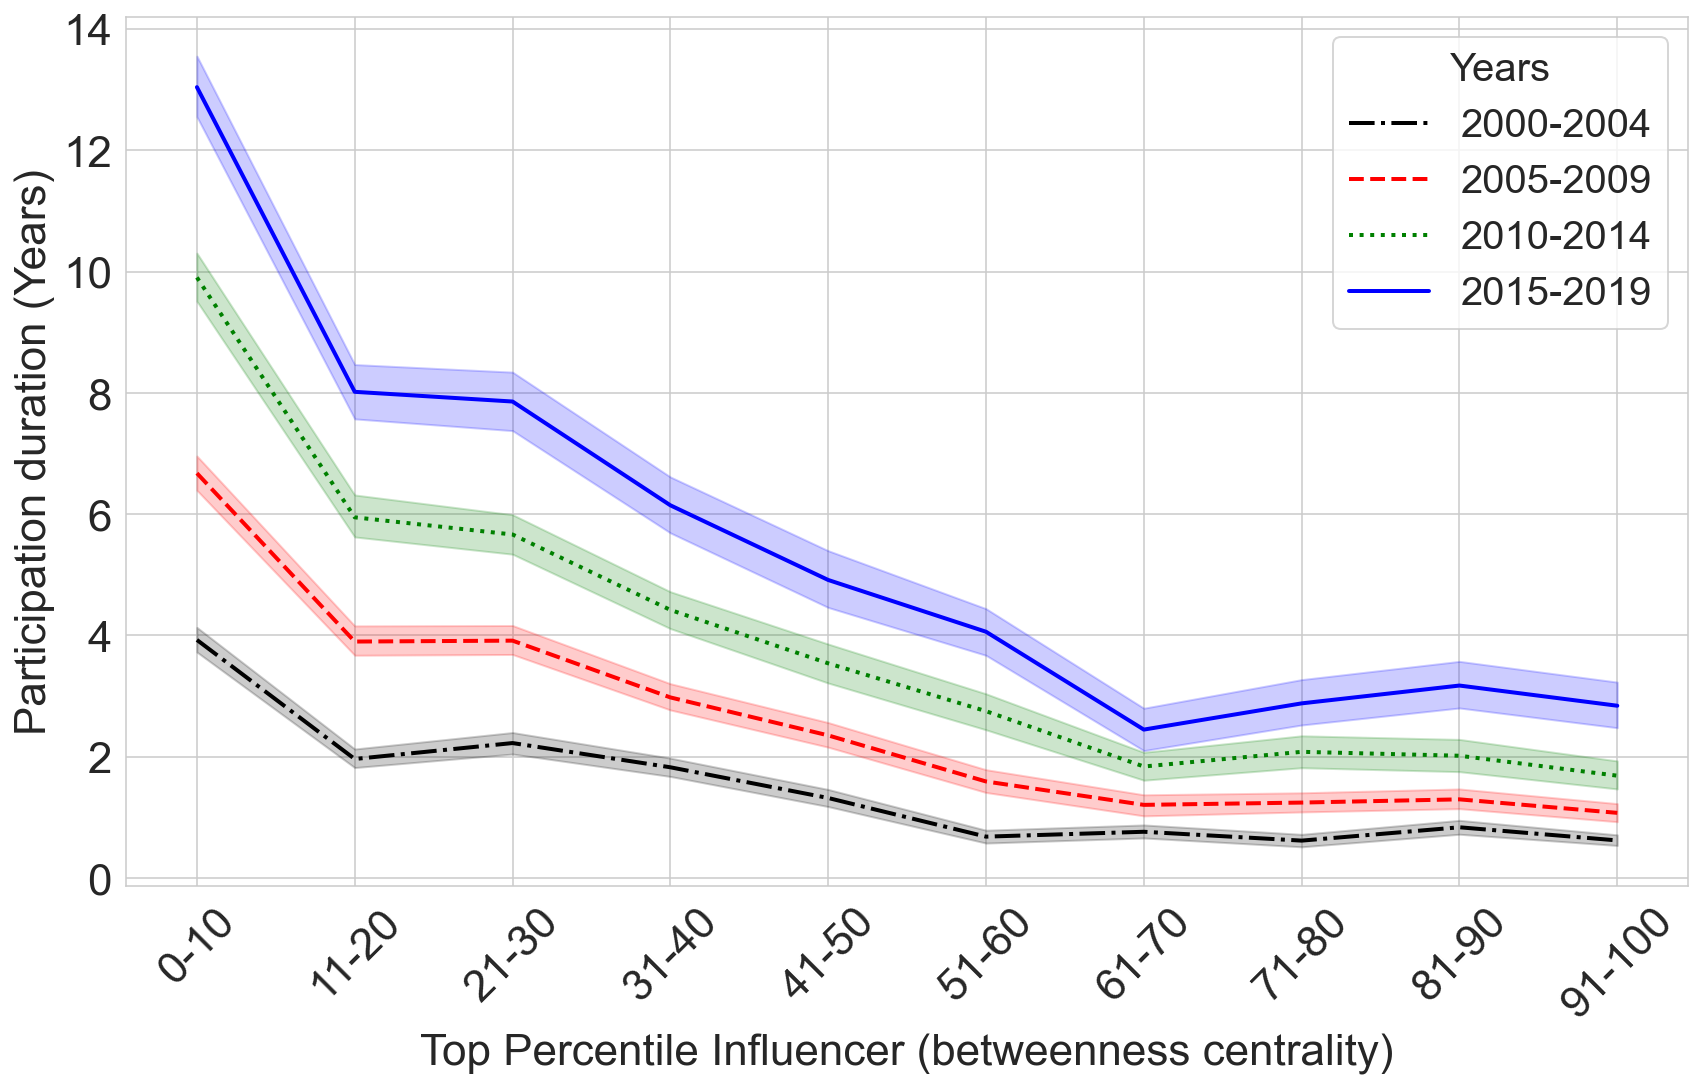

In [38]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}
fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004, 2009, 2014, 2019]:#[2000,2005,2010,2015,2019]:#[2000,2005,2010,2015,2019]:
    
    sns.lineplot(x="Percentile", y="Age", data=active_personIDs_df.loc[active_personIDs_df.Year == yr],color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)
    
x1 = [10,20,30,40,50,60,70,80,90,100]

ax_h.set_xticks(x1)
ax_h.set_xticklabels(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'], rotation=45,
    horizontalalignment='center',size = 22)#horizontalalignment='right'

ax_h.set_xlabel('Top Percentile Influencer (betweenness centrality)',fontdict={'fontsize': 22})

ax_h.set_ylabel('Participation duration (Years)',fontdict={'fontsize': 22})
ax_h.set_yticks([0,2,4,6,8,10,12,14])#,16])
ax_h.set_yticklabels([0,2,4,6,8,10,12,14], size = 22)#,16],

legend = plt.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax_h.transAxes,fontsize=20,title="Years")
legend.get_title().set_fontsize('20')

plt.savefig('../plots/lineplot_age_top_percentile.pdf',bbox_inches='tight')
#THIS ONE

In [40]:
year_emailID_count = dict()
year_email_count = dict()

for mailing_list_name in archive.mailing_list_names():
    
    ml = archive.mailing_list(mailing_list_name)
    if ml:
        if ml._num_messages > 0:
            ml_df = ml.messages_dataframe()
            for index, row in ml_df.iterrows():
                if index in spam_messageIDs:
                    continue
                try:
                    e = row['From']
                    e = e.replace("'", "__apostrophe__")
                    x = re.findall(ren, str(e))

                    if len(x) == 0:
                        x = re.findall(ren2, str(e))
                        if len(x) > 0:
                            email = x[0]
                    else:
                        email = x[0][0]

                    email = email.replace("__apostrophe__", "'").lower()
                    
                    email = email.lower()
                    
                    if '@' not in email:
                        email = email.replace(' at ','@').lower()
                        
                    if row['Date'].year in year_emailID_count:
                        year_emailID_count[row['Date'].year].add(email)
                    else:
                        year_emailID_count[row['Date'].year] = set([email])

                    if row['Date'].year in year_email_count:
                        year_email_count[row['Date'].year] = year_email_count[row['Date'].year] + 1
                    else:
                        year_email_count[row['Date'].year] = 1
                        
                except Exception as e:
                    #print(e)
                    continue
            #print(mailing_list_name, len(year_emailID_count), len(year_email_count))
            print("\rList- %s , %d , %d" % (mailing_list_name, len(year_emailID_count), len(year_email_count)), end = '')
        else:
            #print(e)
            continue

List- bridge-mib , 31 , 31 31 , 3128

INFO:ietfdata:no archived-at cache for mailing list c310
INFO:ietfdata:no archived-at cache for mailing list c430
INFO:ietfdata:no archived-at cache for mailing list c431


List- eppext , 33 , 33333 , 33 , 3331

INFO:ietfdata:no archived-at cache for mailing list errata-design


List- zeroconf , 38 , 38 38 388 , 38, 38 38

In [41]:
a = []
b = []
for yr in range(2000,2020):
    a.append(year_email_count[yr])
    b.append(yr)
df_emails_yearly = pd.DataFrame({'Years':b,'Number_of_emails':a})
df_emails_yearly.head(2)

Years  Number_of_emails
0   2000             30885
1   2001             49662

In [42]:
total_emails_2000_2019 = 0
for yr in range(2000,2020):
    total_emails_2000_2019 += year_email_count[yr]
print(total_emails_2000_2019)    

2106804


<ipython-input-119-81d1f118430a>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_h2.set_yticklabels([int(x) for x in ticks_loc],color="mediumorchid",weight="bold",size = 24)#fontsize='large'


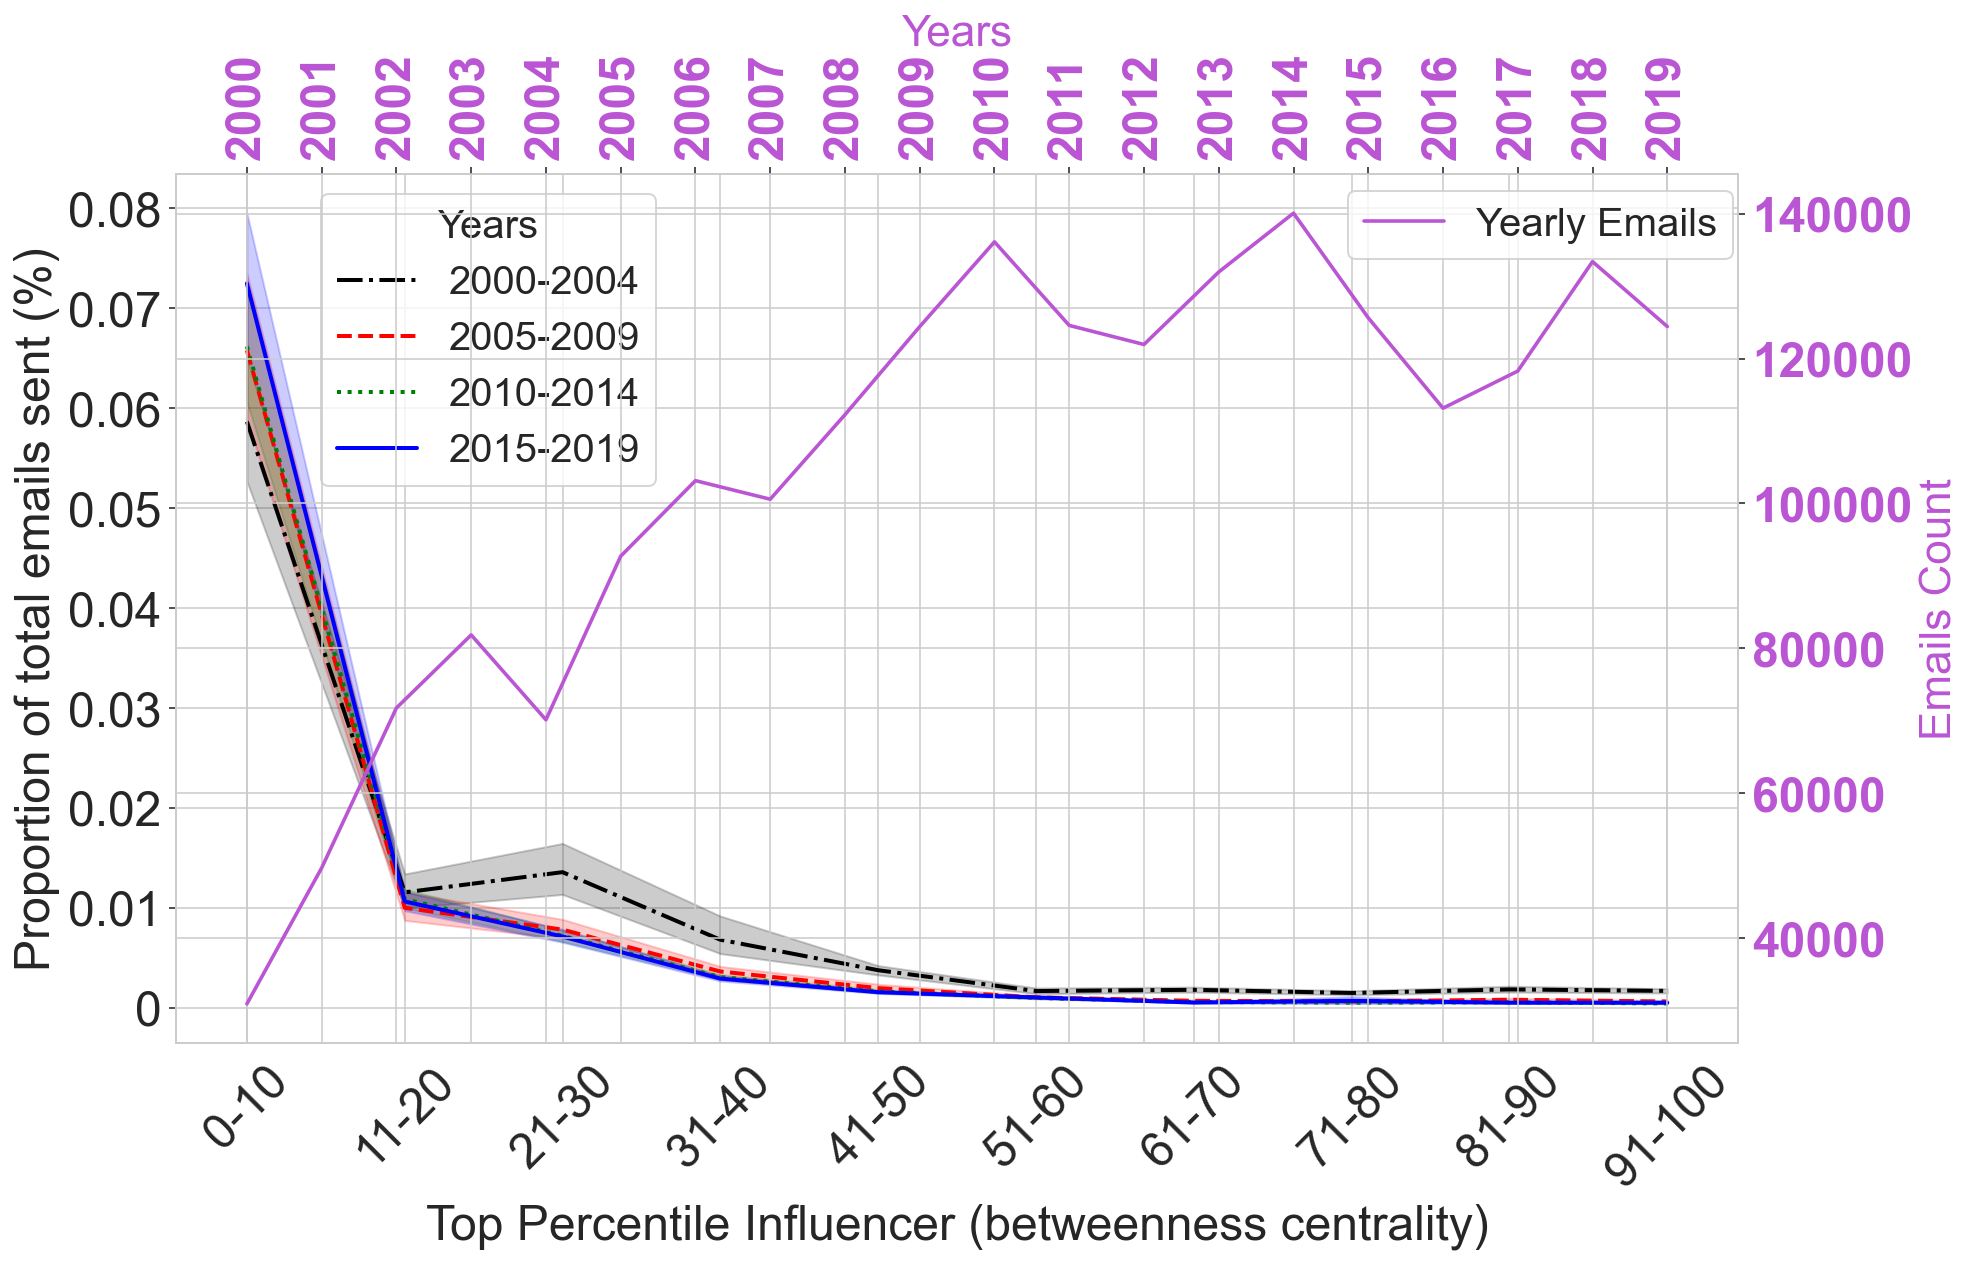

In [119]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}
fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004,2009,2014,2019]:

    y_ = active_personIDs_df.loc[(active_personIDs_df.Year == yr) & (active_personIDs_df.Total_Emails_till_year <= 3500)].Total_Emails_till_year.astype(float)
    tv = 0
    for i in range(yr-4, yr+1):
        tv += year_email_count[i]
    y_ = list(map(lambda x: x*100/tv, y_))
    sns.lineplot(x=active_personIDs_df.loc[(active_personIDs_df.Year == yr) & (active_personIDs_df.Total_Emails_till_year <= 3500)].Percentile.astype(float), y=y_, color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)

x1 = [10,20,30,40,50,60,70,80,90,100]
ax_h.set_xticks(x1)
ax_h.set_xticklabels(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'], rotation=45,
    horizontalalignment='center',size = 24)#horizontalalignment='right'

ax_h.set_xlabel('Top Percentile Influencer (betweenness centrality)',fontdict={'fontsize': 24})

ax_h.set_ylabel('Proportion of total emails sent (%)',fontdict={'fontsize': 24})

ax_h.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08])
ax_h.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08], size = 24)

legend = plt.legend(loc="upper right", bbox_to_anchor=(0.32,1), bbox_transform=ax_h.transAxes,fontsize=20,title="Years")
legend.get_title().set_fontsize('20')

## TWIN X and Y
ax_h2 = ax_h.twinx()

ax_h22 = ax_h2.twiny()

sns.lineplot(x=df_emails_yearly.Years.astype(float),y=df_emails_yearly.Number_of_emails.astype(float), color="mediumorchid", linewidth=1.8,ax=ax_h22,linestyle='-',label="Yearly Emails",legend=False)

twinxlabel = [i for i in range(2000,2020)]
ax_h22.set_xticks(twinxlabel)
ax_h22.set_xticklabels(twinxlabel, rotation=90,
    horizontalalignment='center',size = 24,color="mediumorchid",weight="bold")#horizontalalignment='right'

ticks_loc = ax_h2.get_yticks().tolist()

ax_h2.set_yticklabels([int(x) for x in ticks_loc],color="mediumorchid",weight="bold",size = 24)#fontsize='large'

ax_h22.set_xlabel('Years',fontdict={'fontsize': 22},color="mediumorchid")

ax_h2.set_ylabel('Emails Count',fontdict={'fontsize': 22},color="mediumorchid")

ax_h22.legend(bbox_to_anchor=(0.75,0.98),loc=2,borderaxespad=0,fontsize=20)

#plt.savefig('../plots/lineplot_proportion_emailscount_top_percentile.pdf',bbox_inches='tight')
#THIS ONE

In [118]:
# The top 10% of participants contribute XX%of all emails
total_emails_by_top10_percentile = active_personIDs_df.loc[(active_personIDs_df.Percentile == 10) & (active_personIDs_df.Year.isin([2004,2009,2014,2019])) & (active_personIDs_df.Total_Emails_till_year <= 3500)].Total_Emails_till_year.astype(float).tolist()
total_emails_by_top10_percentile = np.sum(total_emails_by_top10_percentile)
tv = 0
for i in range(2000, 2020):
    tv += year_email_count[i]
print(total_emails_by_top10_percentile*100/tv)

43.751056102038916


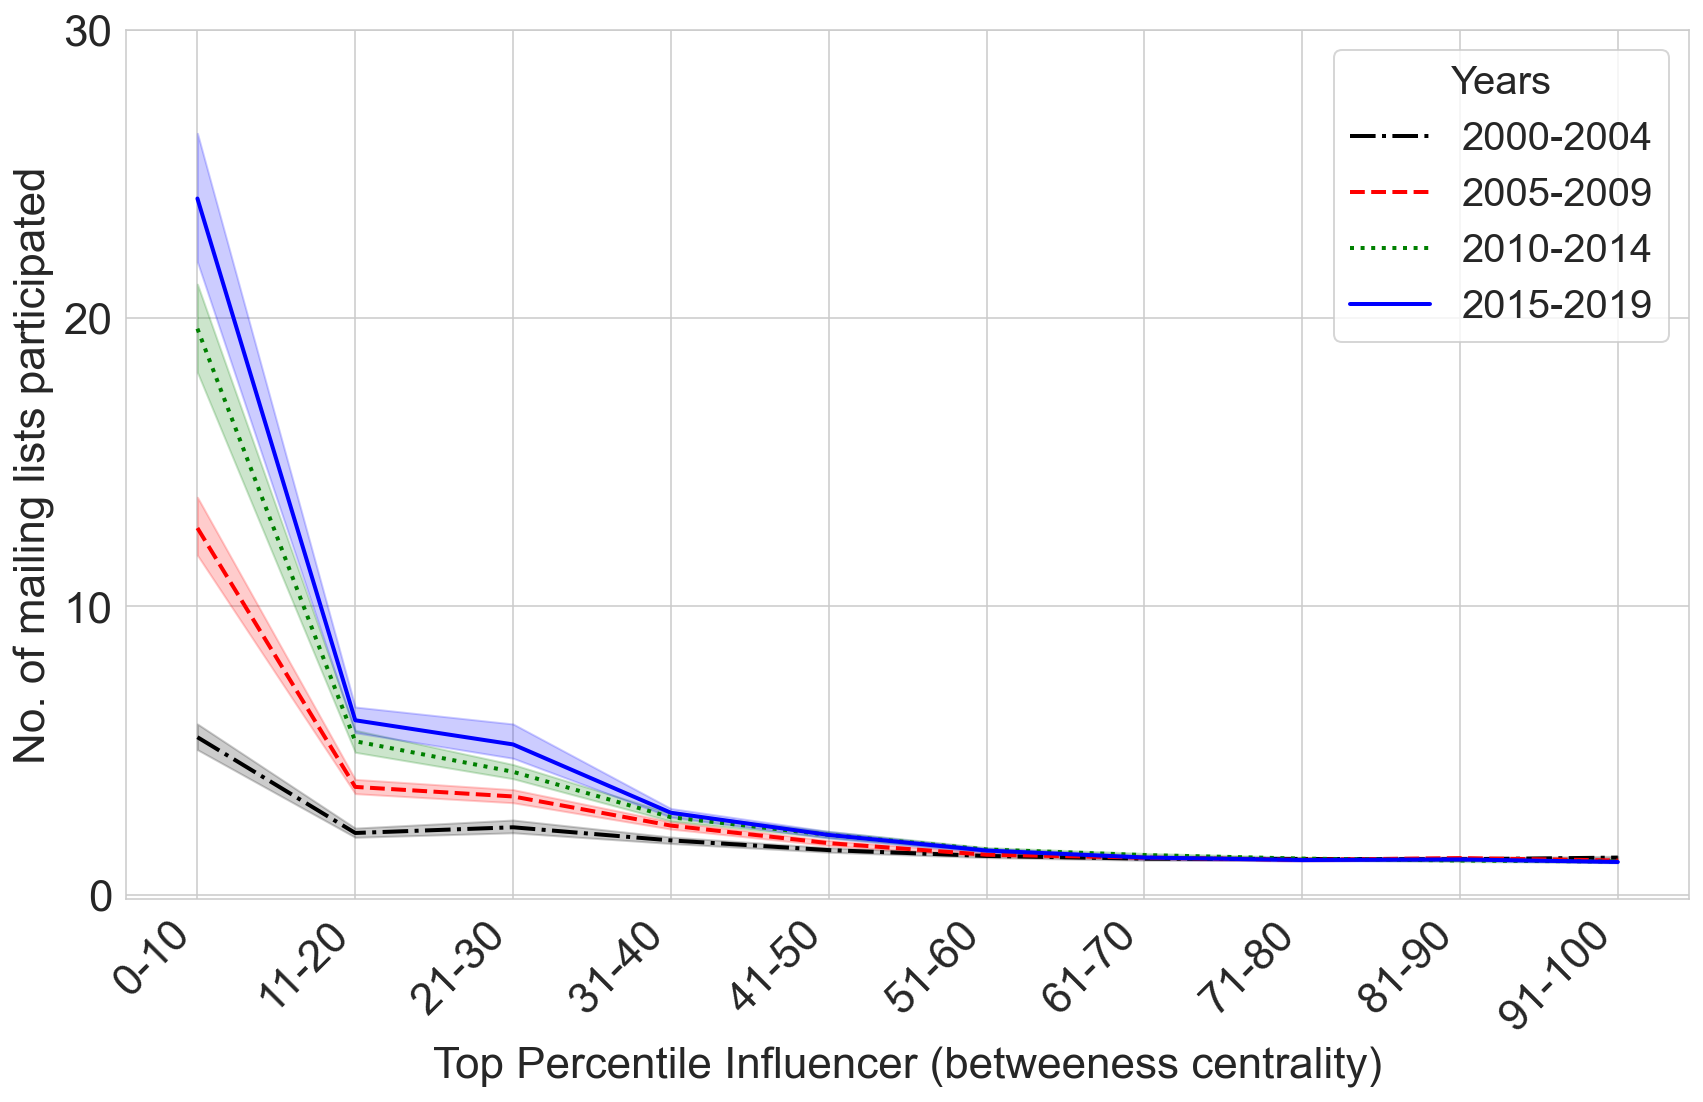

In [45]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}
fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004,2009,2014,2019]:#[2000,2005,2010,2015,2019]:
    sns.lineplot(x=active_personIDs_df.loc[(active_personIDs_df.Year == yr) & (active_personIDs_df.Number_mailing_lists <= 200)].Percentile.astype(float), y=active_personIDs_df.loc[(active_personIDs_df.Year == yr) & (active_personIDs_df.Number_mailing_lists <= 200)].Number_mailing_lists.astype(float), data=active_personIDs_df.loc[(active_personIDs_df.Year == yr) & (active_personIDs_df.Number_mailing_lists <= 200)],color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)

ax_h.set_xticks(x1)
ax_h.set_xticklabels(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'], rotation=45,
    horizontalalignment='right',size = 22)

ax_h.set_xlabel('Top Percentile Influencer (betweeness centrality)',fontdict={'fontsize': 22})

ax_h.set_ylabel('No. of mailing lists participated',fontdict={'fontsize': 22})
ax_h.set_yticks([0,10,20,30])#,40,50])
ax_h.set_yticklabels([0,10,20,30],size = 22)#,40,50], size = 22)

legend = plt.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax_h.transAxes,fontsize=20,title="Years")
legend.get_title().set_fontsize('20')

plt.savefig('../plots/lineplot_avg_mailinglists_top_percentile.pdf',bbox_inches='tight')
#THIS ONE

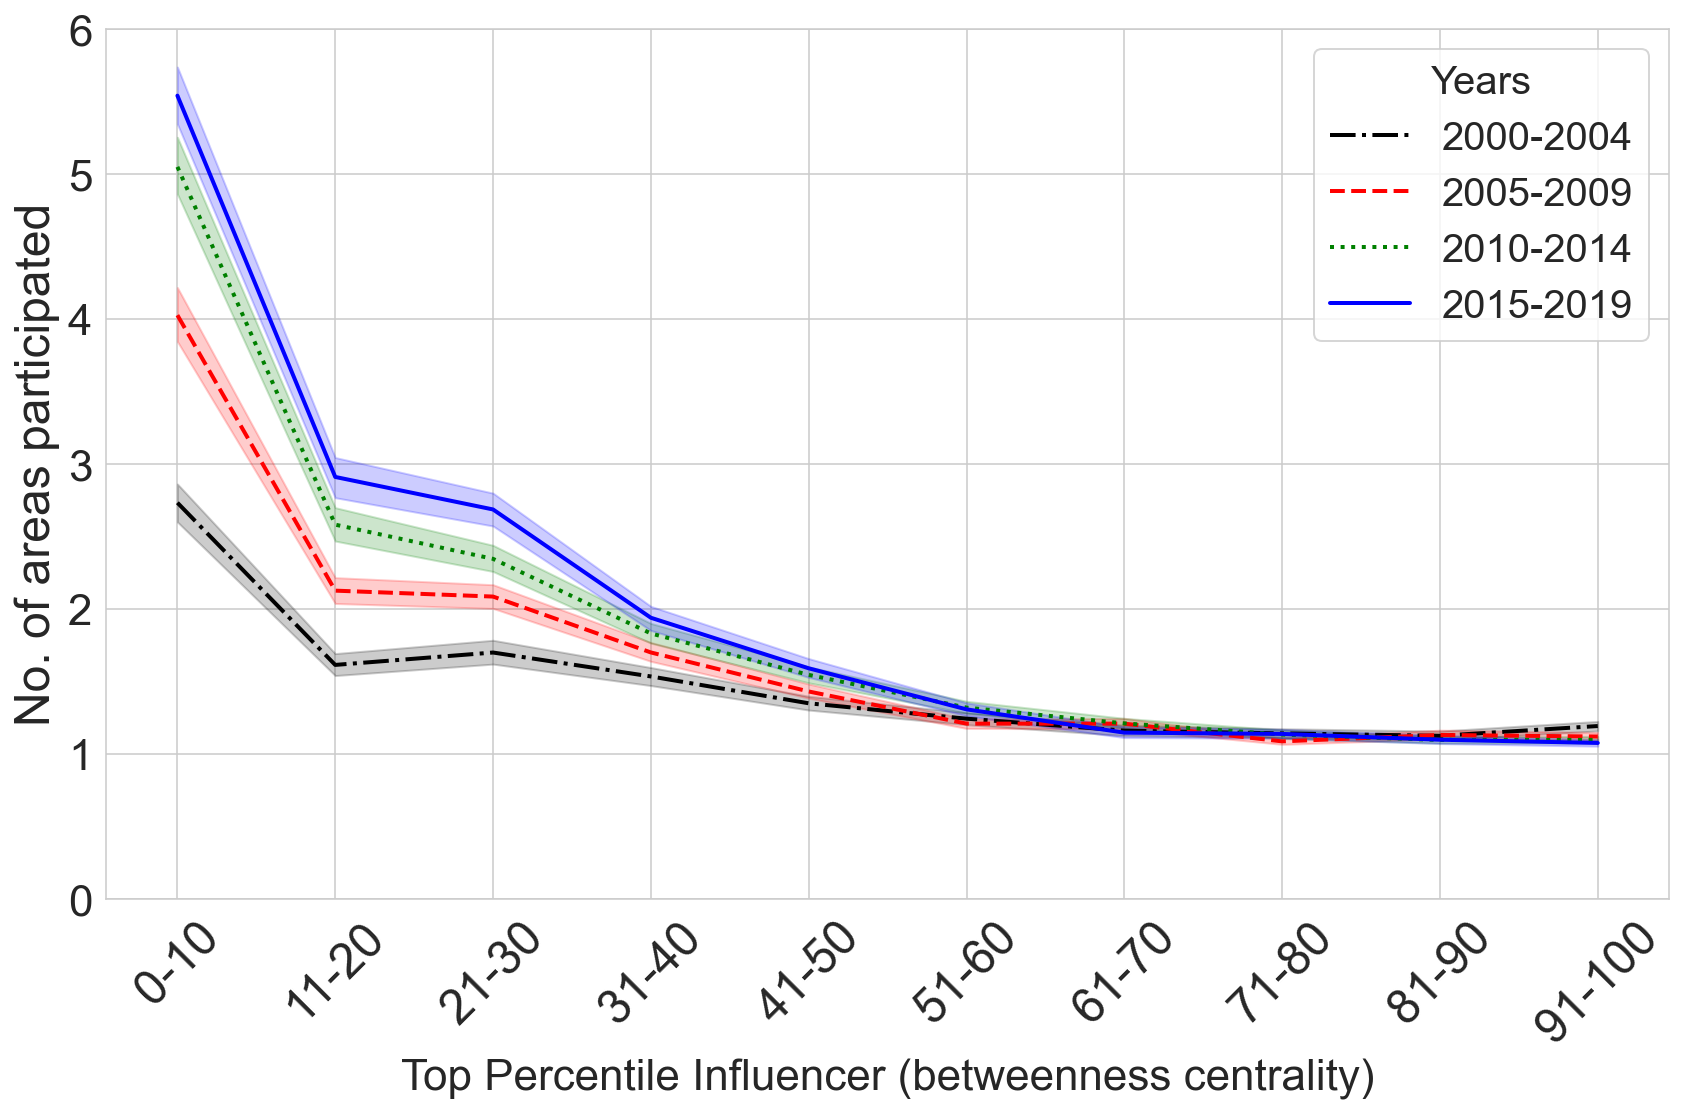

In [46]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}
fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004,2009,2014,2019]:#[2000,2005,2010,2015,2019]:
    sns.lineplot(x=active_personIDs_df.loc[(active_personIDs_df.Year == yr)].Percentile.astype(float), y=active_personIDs_df.loc[(active_personIDs_df.Year == yr)].Number_areas.astype(float), data=active_personIDs_df.loc[(active_personIDs_df.Year == yr)],color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)

ax_h.set_xticks(x1)
ax_h.set_xticklabels(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'], rotation=45,
    horizontalalignment='center',size = 24)#horizontalalignment='right'

ax_h.set_xlabel('Top Percentile Influencer (betweenness centrality)',fontdict={'fontsize': 22})

ax_h.set_ylabel('No. of areas participated',fontdict={'fontsize': 24})
ax_h.set_yticks([0,1,2,3,4,5,6])#7,8
ax_h.set_yticklabels([0,1,2,3,4,5,6], size = 22)#,7,8

legend = plt.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax_h.transAxes,fontsize=20,title="Years")
legend.get_title().set_fontsize('20')

plt.savefig('../plots/lineplot_avg_areas_top_percentile.pdf',bbox_inches='tight')
#THIS ONE

In [47]:
draft_version_authors = dict()
draft_final_version_authors = dict()
with open('../data/submission_author_data.csv', 'r') as file:
    reader = csv.reader(file,quoting=csv.QUOTE_NONE)
    for row in reader:
        #print(row)
        #break
        if len(row[1]) == 0:
            #print(row)
            continue
        #print(row[1],len(row[1]),row)
        if len(row) < 4:
            print(row)
            #break
        if row[0].lower() in draft_version_authors:
            if int(row[1]) in draft_version_authors[row[0].lower()]:
                if row[2].lower()+'_str_'+row[3].lower() not in draft_version_authors[row[0].lower()][int(row[1])]:
                    draft_version_authors[row[0].lower()][int(row[1])].append(row[2].lower()+'_str_'+row[3].lower())
            else:
                draft_version_authors[row[0].lower()][int(row[1])] = [row[2].lower()+'_str_'+row[3].lower()]
        else:
            draft_version_authors[row[0].lower()] = {int(row[1]) : [row[2].lower()+'_str_'+row[3].lower()]}
        
        if row[0].lower() in draft_final_version_authors:
            if int(row[1]) > next(iter(draft_final_version_authors[row[0].lower()])):
                #draft_final_version_authors[row[0].lower()][int(row[1])] = [row[2].lower()+'_str_'+row[3].lower()]
                draft_final_version_authors[row[0].lower()] = {int(row[1]) : [row[2].lower()+'_str_'+row[3].lower()]}
            elif int(row[1]) == next(iter(draft_final_version_authors[row[0].lower()])):
                draft_final_version_authors[row[0].lower()][int(row[1])].append(row[2].lower()+'_str_'+row[3].lower())
                
        else:
            draft_final_version_authors[row[0].lower()] = {int(row[1]) : [row[2].lower()+'_str_'+row[3].lower()]}
        if len(draft_version_authors)%1000 == 0:
            print("\r%d , %d" % (len(draft_version_authors),len(draft_final_version_authors)), end = '')

21000 , 21000

In [48]:
submission_doc_data = pd.read_csv('../data/submission_doc_data.csv')
submission_doc_data.head(3)

/Users/pkhare/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


doc_name  revision_num                 date page_count  \
0  draft-ietf-dkim-overview           5.0  2007-04-23 00:00:00         32   
1  draft-ietf-dkim-overview           5.0  2007-06-11 00:00:00         32   
2    draft-hoffman-ikev2bis           1.0  2007-06-11 00:00:00        124   

  word_count   state last_draft  author_count  
0       None  cancel        NaN             3  
1       None  posted        NaN             3  
2       None  posted        NaN             3

In [49]:
temp_df = active_personIDs_df.copy()

In [51]:
pid_datatracker_dict = json.load(open('../data/pid_datatracker_dict.json'))

In [52]:
#dt = DataTracker(use_cache = True)
'''
dt = DataTracker()
pid_yearly_document = dict()
pid_document = dict()
pid_eid_affiliation = dict()

for pid in pid_datatracker_dict:
    try:
        for doc in list(dt.documents_authored_by_person(dt.person(PersonURI(pid_datatracker_dict[pid])))):
            doc_ = dt.document(doc.document)
            #print(doc_.name,doc_.resource_uri.uri, doc_.time.year)
            year_ = doc_.time.year
            doc_uri = doc_.resource_uri.uri
            #print(doc_uri, len(pid_yearly_document),len(pid_document))
            aff = doc.affiliation
            aff = aff.strip().lower()
            if len(aff.strip()) == 0:
                aff = doc.email.uri
                aff = aff.replace(doc.email.root,'')
                aff = aff.lower()
                aff = aff.strip('/')
                aff = tldextract.extract(aff).domain
            else:
                if 'university' in aff or aff == 'china mobile' or aff == 'inside products':
                    aff = aff.strip('/')
                else:
                    aff = aff.lower().strip().split()[0].strip('/')

            if pid in pid_yearly_document:
                if year in pid_yearly_document[pid]:
                    if doc_uri not in pid_document[pid]:
                        pid_yearly_document[pid][year].append(doc_uri)
                        pid_document[pid].append(doc_uri)
                        pid_eid_affiliation[pid][year].append(aff)
                else:
                    if doc_uri not in pid_document[pid]:
                        pid_yearly_document[pid][year] = [doc_uri]
                        pid_document[pid].append(doc_uri)
                        pid_eid_affiliation[pid][year] = [aff]
            else:
                pid_yearly_document[pid] = {year: [doc_uri]}
                pid_document[pid] = [doc_uri]
                pid_eid_affiliation[pid] = {year: [aff]}
            
    except Exception as e:
        print(e)
        #continue
    print(len(pid_yearly_document),len(pid_document))
'''

"\ndt = DataTracker()\npid_yearly_document = dict()\npid_document = dict()\npid_eid_affiliation = dict()\n\nfor pid in pid_datatracker_dict:\n    try:\n        for doc in list(dt.documents_authored_by_person(dt.person(PersonURI(pid_datatracker_dict[pid])))):\n            doc_ = dt.document(doc.document)\n            #print(doc_.name,doc_.resource_uri.uri, doc_.time.year)\n            year_ = doc_.time.year\n            doc_uri = doc_.resource_uri.uri\n            #print(doc_uri, len(pid_yearly_document),len(pid_document))\n            aff = doc.affiliation\n            aff = aff.strip().lower()\n            if len(aff.strip()) == 0:\n                aff = doc.email.uri\n                aff = aff.replace(doc.email.root,'')\n                aff = aff.lower()\n                aff = aff.strip('/')\n                aff = tldextract.extract(aff).domain\n            else:\n                if 'university' in aff or aff == 'china mobile' or aff == 'inside products':\n                    aff = a

Use affiliation_document_history.py to run above commented out code to generate below json file

In [53]:
pid_yearly_document = json.load(open('../data/pid_yearly_document.json'))

In [54]:
#LOOKING AT PERSONID DRAFT RECORDS THROUGH FILE GENERATED VIA DATATRACKER QUERY FOR EACH PID
temp_l = []

for i,r in active_personIDs_df.iterrows():
    pid = r['Person_ID']#int(r['Person_ID'])
    year = r['Year']#int(r['Year'])
    c = 0
    if pid in pid_yearly_document:
        for yr in pid_yearly_document[pid]:
            #if yr <= year and yr > (year - 5):
            if int(yr) <= int(year) and int(yr) > (int(year) - 5):
                for draft in pid_yearly_document[pid][yr]:
                    if 'document/draft' not in draft.lower():
                        continue
                    else:
                        if '/draft-ietf' in draft.lower():#draft.lower().startswith('draft-ietf'):
                            continue
                        else:
                            c += 1
                
                
    temp_l.append(c)
temp_df['Documents_till_year'] = temp_l
temp_df.head()

Person_ID  Year  Age Total_Emails_till_year Percentile Number_mailing_lists  \
0    100085  2000  6.0                    443         10                   16   
1    105768  2000  1.0                    101         10                    3   
2    131175  2000  3.0                    139         10                    1   
3    112663  2000  3.5                    254         10                    2   
4    100855  2000  3.5                    234         10                    3   

  Number_areas  Documents_till_year  
0            4                   10  
1            3                    4  
2            1                    0  
3            1                    0  
4            1                    0

In [55]:
temp_df.loc[temp_df.Year.isin([2004,2009,2015,2019])]

Person_ID  Year   Age Total_Emails_till_year Percentile  \
15491     100085  2004  10.0                   1020         10   
15492     100811  2004   3.5                   1112         10   
15493     105768  2004   5.0                    625         10   
15494     101341  2004   6.5                   1134         10   
15495     109691  2004   6.0                    872         10   
...          ...   ...   ...                    ...        ...   
136486    174577  2019   0.0                      3        100   
136487    174580  2019   0.0                      5        100   
136488    174581  2019   0.0                      1        100   
136489    174583  2019   0.0                      3        100   
136490    108044  2019  14.0                      1        100   

       Number_mailing_lists Number_areas  Documents_till_year  
15491                    32           10                   15  
15492                    48           10                   20  
15493                    10            6                    7  
15494                    12            4                    7  
15495                    28            5                    4  
...                     ...          ...                  ...  
136486                    1            1                    0  
136487                    1            1                    0  
136488                    1            1                    0  
136489                    1            1                    0  
136490                    1            1                    0  

[28886 rows x 8 columns]

In [56]:
yearly_document = dict()

for pid in pid_yearly_document:
    for yr in pid_yearly_document[pid]:
        
        for doc in pid_yearly_document[pid][yr]:
            if 'document/draft' not in doc.lower():
                continue
            
            if '/draft-ietf' in doc.lower():
                continue
            
            if int(yr) in yearly_document:
                yearly_document[int(yr)].add(doc)
            else:
                yearly_document[int(yr)] = set([doc])


<ipython-input-58-6613a25a4d13>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_h2.set_yticklabels([int(x) for x in ticks_loc],color="mediumorchid",weight="bold",size = 24)#fontsize='large'


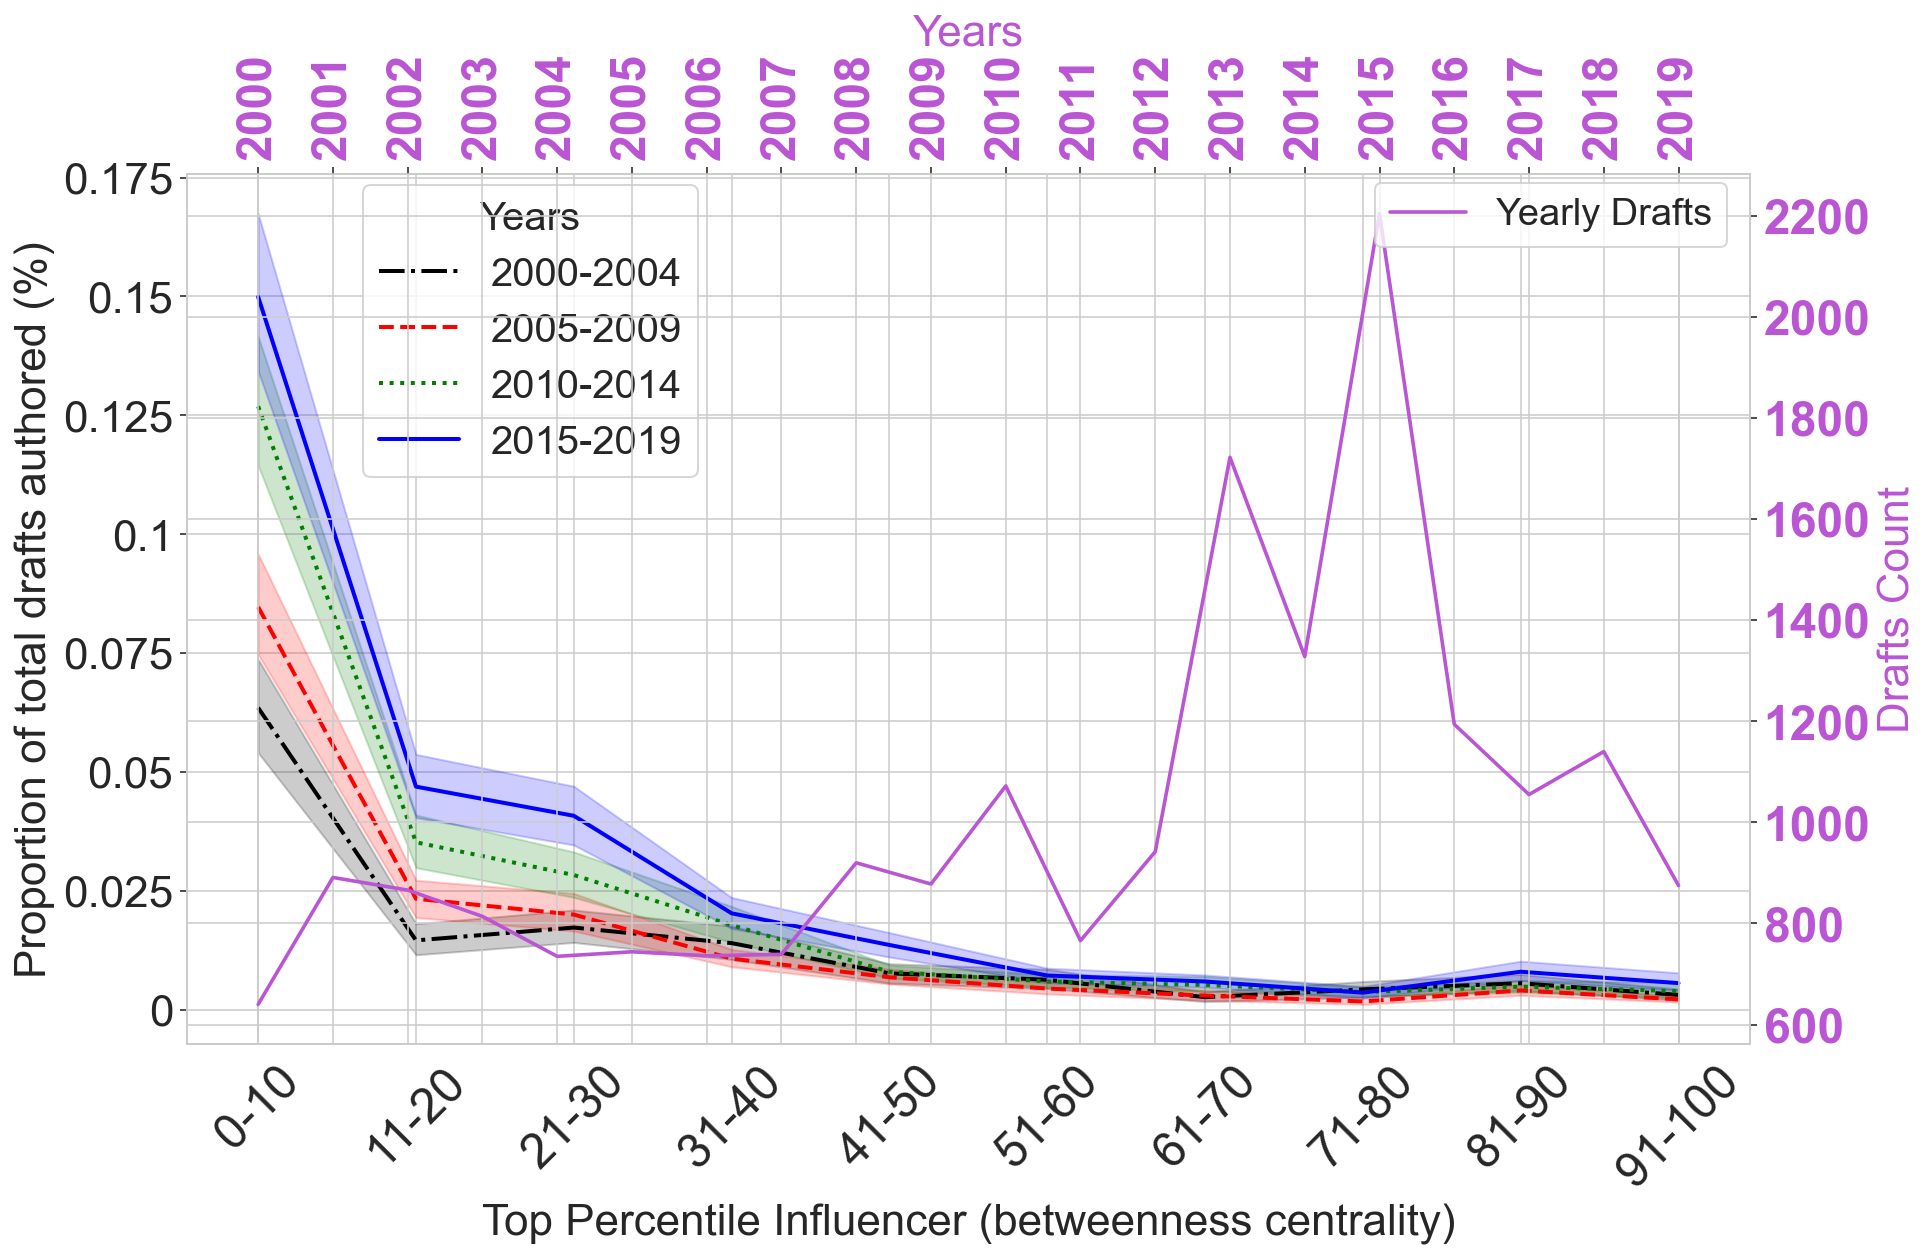

In [58]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}
fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004,2009,2014,2019]:
    y_ = temp_df.loc[(temp_df.Year == yr)].Documents_till_year.astype(float).tolist()
    tv = 0 #set([])
    for k in yearly_document:
        if k <= yr and k > (yr-5):
            tv += len(yearly_document[k])
    
    y_ = list(map(lambda x: x*100/tv, y_))
    sns.lineplot(x=temp_df.loc[(temp_df.Year == yr)].Percentile.astype(float), y=y_,color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)


ax_h.set_xticks(x1)
ax_h.set_xticklabels(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'], rotation=45,
    horizontalalignment='center',size = 24)#horizontalalignment='right'

ax_h.set_xlabel('Top Percentile Influencer (betweenness centrality)',fontdict={'fontsize': 22})

ax_h.set_ylabel('Proportion of total drafts authored (%)',fontdict={'fontsize': 22})

ax_h.set_yticks([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175])#,20,25,30,35])
ax_h.set_yticklabels([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175],size = 22)#,20,25,30,35], size = 22)

legend = plt.legend(loc="upper right", bbox_to_anchor=(0.34,1.01), bbox_transform=ax_h.transAxes,fontsize=20,title="Years")
legend.get_title().set_fontsize('20')

## TWIN X and Y
ax_h2 = ax_h.twinx()

ax_h22 = ax_h2.twiny()
yrs_ = []
docs_ = []
for yr in range(2000,2020):
    yrs_.append(yr)
    tv = set([])
    for d in yearly_document[yr]:
        tv.add(d)
    docs_.append(len(tv))
    
sns.lineplot(x=np.array(yrs_).astype(float),y=np.array(docs_).astype(float), color="mediumorchid", linewidth=1.8,ax=ax_h22,linestyle='-',label="Yearly Drafts",legend=False)

twinxlabel = [i for i in range(2000,2020)]
ax_h22.set_xticks(twinxlabel)
ax_h22.set_xticklabels(twinxlabel, rotation=90,
    horizontalalignment='center',size = 24,color="mediumorchid",weight="bold")#horizontalalignment='right'

ticks_loc = ax_h2.get_yticks().tolist()
ax_h2.set_yticklabels([int(x) for x in ticks_loc],color="mediumorchid",weight="bold",size = 24)#fontsize='large'

ax_h22.set_xlabel('Years',fontdict={'fontsize': 22},color="mediumorchid")

ax_h2.set_ylabel('Drafts Count',fontdict={'fontsize': 22},color="mediumorchid")

ax_h22.legend(bbox_to_anchor=(0.76,0.99),loc=2,borderaxespad=0,fontsize=19)

#THIS ONE

plt.savefig('../plots/documents_proportion_published_top_percentile.pdf',bbox_inches='tight')

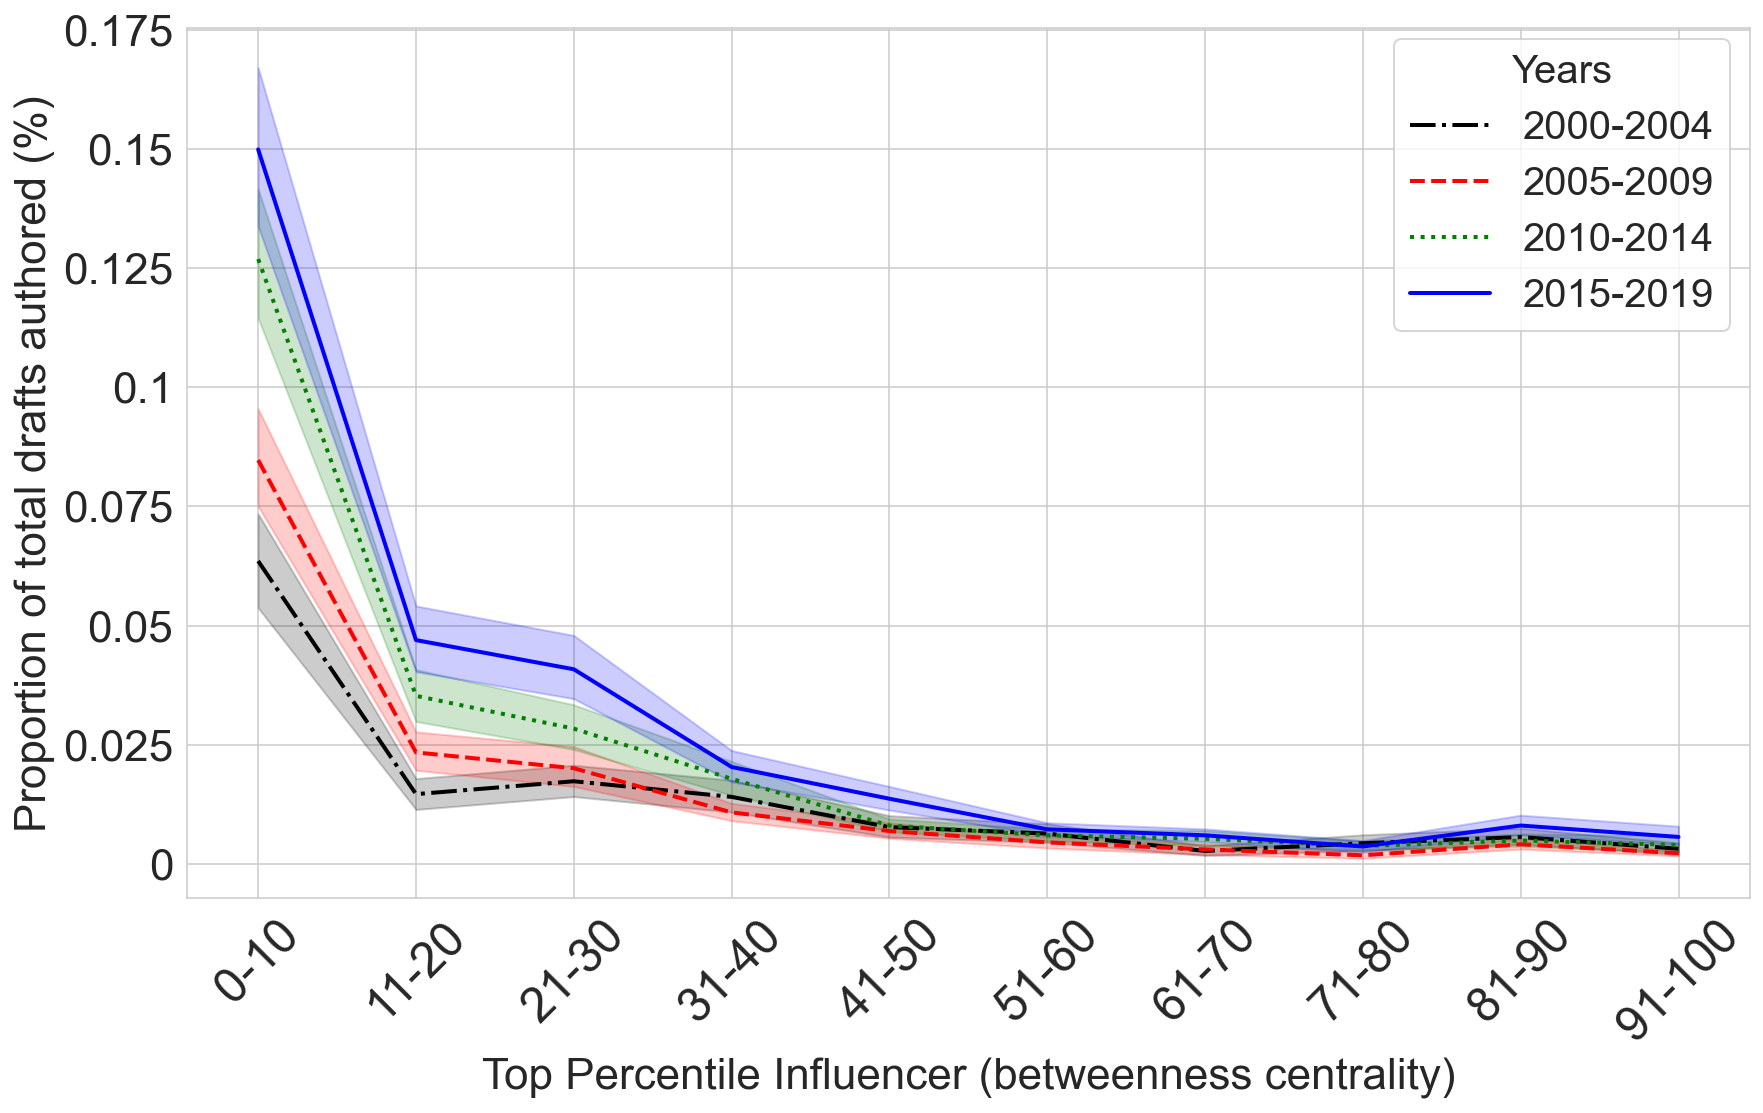

In [130]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}
fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004,2009,2014,2019]:
    y_ = temp_df.loc[(temp_df.Year == yr)].Documents_till_year.astype(float).tolist()
    tv = 0 #set([])
    for k in yearly_document:
        if k <= yr and k > (yr-5):
            tv += len(yearly_document[k])
    
    y_ = list(map(lambda x: x*100/tv, y_))
    sns.lineplot(x=temp_df.loc[(temp_df.Year == yr)].Percentile.astype(float), y=y_,color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)


ax_h.set_xticks(x1)
ax_h.set_xticklabels(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'], rotation=45,
    horizontalalignment='center',size = 24)#horizontalalignment='right'

ax_h.set_xlabel('Top Percentile Influencer (betweenness centrality)',fontdict={'fontsize': 22})

ax_h.set_ylabel('Proportion of total drafts authored (%)',fontdict={'fontsize': 22})

ax_h.set_yticks([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175])#,20,25,30,35])
ax_h.set_yticklabels([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175],size = 22)#,20,25,30,35], size = 22)

legend = plt.legend(loc="upper right", bbox_to_anchor=(1,1.01), bbox_transform=ax_h.transAxes,fontsize=20,title="Years")
legend.get_title().set_fontsize('20')

## TWIN X and Y
#ax_h2 = ax_h.twinx()

#ax_h22 = ax_h2.twiny()
#yrs_ = []
#docs_ = []
#for yr in range(2000,2020):
#    yrs_.append(yr)
#    tv = set([])
#    for d in yearly_document[yr]:
#        tv.add(d)
#    docs_.append(len(tv))
    
#sns.lineplot(x=np.array(yrs_).astype(float),y=np.array(docs_).astype(float), color="mediumorchid", linewidth=1.8,ax=ax_h22,linestyle='-',label="Yearly Drafts",legend=False)

#twinxlabel = [i for i in range(2000,2020)]
#ax_h22.set_xticks(twinxlabel)
#ax_h22.set_xticklabels(twinxlabel, rotation=90,
#    horizontalalignment='center',size = 24,color="mediumorchid",weight="bold")#horizontalalignment='right'

#ticks_loc = ax_h2.get_yticks().tolist()
#ax_h2.set_yticklabels([int(x) for x in ticks_loc],color="mediumorchid",weight="bold",size = 24)#fontsize='large'

#ax_h22.set_xlabel('Years',fontdict={'fontsize': 22},color="mediumorchid")

#ax_h2.set_ylabel('Drafts Count',fontdict={'fontsize': 22},color="mediumorchid")

#ax_h22.legend(bbox_to_anchor=(0.76,0.99),loc=2,borderaxespad=0,fontsize=19)

#THIS ONE

#plt.savefig('../plots/singleaxis__documents_proportion_published_top_percentile.pdf',bbox_inches='tight')

## Draft Co-author network analysis

In [61]:
document_author_dict = dict()
for pid in pid_yearly_document:
    for yr in pid_yearly_document[pid]:
        for doc in pid_yearly_document[pid][yr]:
            if doc in document_author_dict:
                document_author_dict[doc].add(int(pid))
            else:
                document_author_dict[doc] = set([int(pid)])
print(len(document_author_dict))

40605


In [71]:
pid_affiliation = json.load(open('../data/pid_affiliation.json'))

In [59]:
#Creating yearly document dictionary
yearly_document_dict = dict()
for pid in pid_yearly_document:
    for yr in pid_yearly_document[pid]:
        for doc in pid_yearly_document[pid][yr]:
            if yr in yearly_document_dict:
                yearly_document_dict[yr].add(doc)
            else:
                yearly_document_dict[yr] = set([doc])

In [62]:
yearly_coauthor_graph = dict()
for yr in [2004,2009,2014,2019]:
    G = nx.Graph()
    
    for yrs in yearly_document_dict:
        if int(yrs) <= yr and int(yrs) > (yr-5):
            for doc in yearly_document_dict[yrs]:
                
                ## filtering off docs which are not drafts and ietf-drafts
                if 'document/draft' not in doc.lower():
                    continue
            
                #if '/draft-ietf' in doc.lower():
                #    continue
                ##
                
                nodes = set([])
                for author in document_author_dict[doc]:
                    nodes.add(author)
                    if author not in G:
                        G.add_nodes_from([author])
                for i in itertools.combinations(nodes,2):
                    G.add_edges_from([(i[0], i[1])])
                    
    yearly_coauthor_graph[yr] = G
    

In [63]:
print(len(yearly_coauthor_graph[2004]),len(yearly_coauthor_graph[2009]),len(yearly_coauthor_graph[2014]),len(yearly_coauthor_graph[2019]))

1993 2135 3644 4578


In [64]:
yearly_top_coauthor_bwcnt_nodes = dict()
for yr in [2004,2009,2014,2019]:
    G1 = yearly_coauthor_graph[yr]
    if len(G1) > 0:
        d = centrality.betweenness_centrality(G1)
        d = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))

        l = len(d)

        ordered_nodes = []

        for k in d:
            ordered_nodes.append(k)

        for i in [10,20,30,40,50,60,70,80,90,100]:

            lst = ordered_nodes[int(len(ordered_nodes)*(i-10)/100):int(len(ordered_nodes)*(i)/100)]
            if len(lst) == 0:
                print(yr, i, 'ZERO LENGTH')
            if yr not in yearly_top_coauthor_bwcnt_nodes:
                yearly_top_coauthor_bwcnt_nodes[yr] = {i: lst}
            else:
                yearly_top_coauthor_bwcnt_nodes[yr][i] = lst
    print(yr,len(G1),len(yearly_top_coauthor_bwcnt_nodes))

2004 1993 1
2009 2135 2
2014 3644 3
2019 4578 4


In [65]:
print('Overlap of top 20% people in authorship network with email network:')
for yr in [2004,2009,2014,2019]:
    author_set =  set(yearly_top_coauthor_bwcnt_nodes[yr][10]).union(set(yearly_top_coauthor_bwcnt_nodes[yr][20]))
    person_set = set(yearly_top_bwcnt_nodes[yr]['overall'][10]).union(set(yearly_top_bwcnt_nodes[yr]['overall'][20]))
    overlap_ = len(author_set.intersection(person_set))*100/len(author_set)
    print("Year:"+str(yr-4)+'-'+str(yr),"Size of top 20% author ntw-"+str(len(author_set)),"Size of overlap-"+str(len(author_set.intersection(person_set))),"Percentage overlap-"+str(round(overlap_,2))+str('%'), "Email ntw size-"+str(len(person_set)))

Overlap of top 20% people in authorship network with email network:
Year:2000-2004 Size of top 20% author ntw-398 Size of overlap-192 Percentage overlap-48.24% Email ntw size-1390
Year:2005-2009 Size of top 20% author ntw-427 Size of overlap-287 Percentage overlap-67.21% Email ntw size-1662
Year:2010-2014 Size of top 20% author ntw-728 Size of overlap-459 Percentage overlap-63.05% Email ntw size-1639
Year:2015-2019 Size of top 20% author ntw-915 Size of overlap-511 Percentage overlap-55.85% Email ntw size-1370


In [68]:
for yr in [2004,2009,2014,2019]:
    author_set =  set(yearly_top_coauthor_bwcnt_nodes[yr][10]).union(set(yearly_top_coauthor_bwcnt_nodes[yr][20]))
    person_set = set(yearly_top_bwcnt_nodes[yr]['overall'][10]).union(set(yearly_top_bwcnt_nodes[yr]['overall'][20]))
    overlap_ = author_set.intersection(person_set)
    
    list_overlap_author = []
    list_overlap_person = []
    
    for p in yearly_top_coauthor_bwcnt_nodes[yr][10]:
        if p in overlap_ and p not in list_overlap_author:
            list_overlap_author.append(p)
            
    for p in yearly_top_coauthor_bwcnt_nodes[yr][20]:
        if p in overlap_ and p not in list_overlap_author:
            list_overlap_author.append(p)
            
    for p in yearly_top_bwcnt_nodes[yr]['overall'][10]:
        if p in overlap_ and p not in list_overlap_person:
            list_overlap_person.append(p)
            
    for p in yearly_top_bwcnt_nodes[yr]['overall'][20]:
        if p in overlap_ and p not in list_overlap_person:
            list_overlap_person.append(p)
            
    rank_author = []
    rank_person = []
    
    for p in overlap_:
        rank_author.append(list_overlap_author.index(p))
        rank_person.append(list_overlap_person.index(p))
        
    print(stats.spearmanr(rank_author, rank_person))#,round(stats.spearmanr(rank_author, rank_person).correlation,3),round(stats.spearmanr(rank_author, rank_person).pvalue,2))
        
    #print(len(overlap_),len(list_overlap_author),len(list_overlap_person),len(rank_author),len(rank_person))
    

SpearmanrResult(correlation=0.32181828662886913, pvalue=5.3187481660417715e-06)
SpearmanrResult(correlation=0.33285312248726884, pvalue=7.473416839940526e-09)
SpearmanrResult(correlation=0.2995775894054855, pvalue=5.6844672542363726e-11)
SpearmanrResult(correlation=0.3379058686830896, pvalue=4.09816156143521e-15)


In [76]:
most_frequent_affiliations = dict()
for yr in [2004,2009,2014,2019]:
    author_set =  set(yearly_top_coauthor_bwcnt_nodes[yr][10]).union(yearly_top_coauthor_bwcnt_nodes[yr][20])#yearly_top_bwcnt_nodes[yr]['overall'][10]
    for author in author_set:
        author = str(author)
        l_aff = []
        for yr2 in pid_affiliation[author]:
            if int(yr2) <= yr and int(yr2) > (yr-5):
                l_aff.extend(pid_affiliation[author][yr2])
        aff = Counter(l_aff).most_common(1)[0][0]
        aff = aff.strip()
        aff = aff.strip(',')
        if aff == 'nortelnetworks':
            aff = 'nortel'
        if aff == 'gmail' or aff == 'yahoo' or aff == 'yahoomail':
            aff = pid_name_dict[author][0] 
        
        if yr in most_frequent_affiliations:
            most_frequent_affiliations[yr][aff] = most_frequent_affiliations[yr].get(aff,0)+1
        else:
            most_frequent_affiliations[yr] ={aff:1}
        

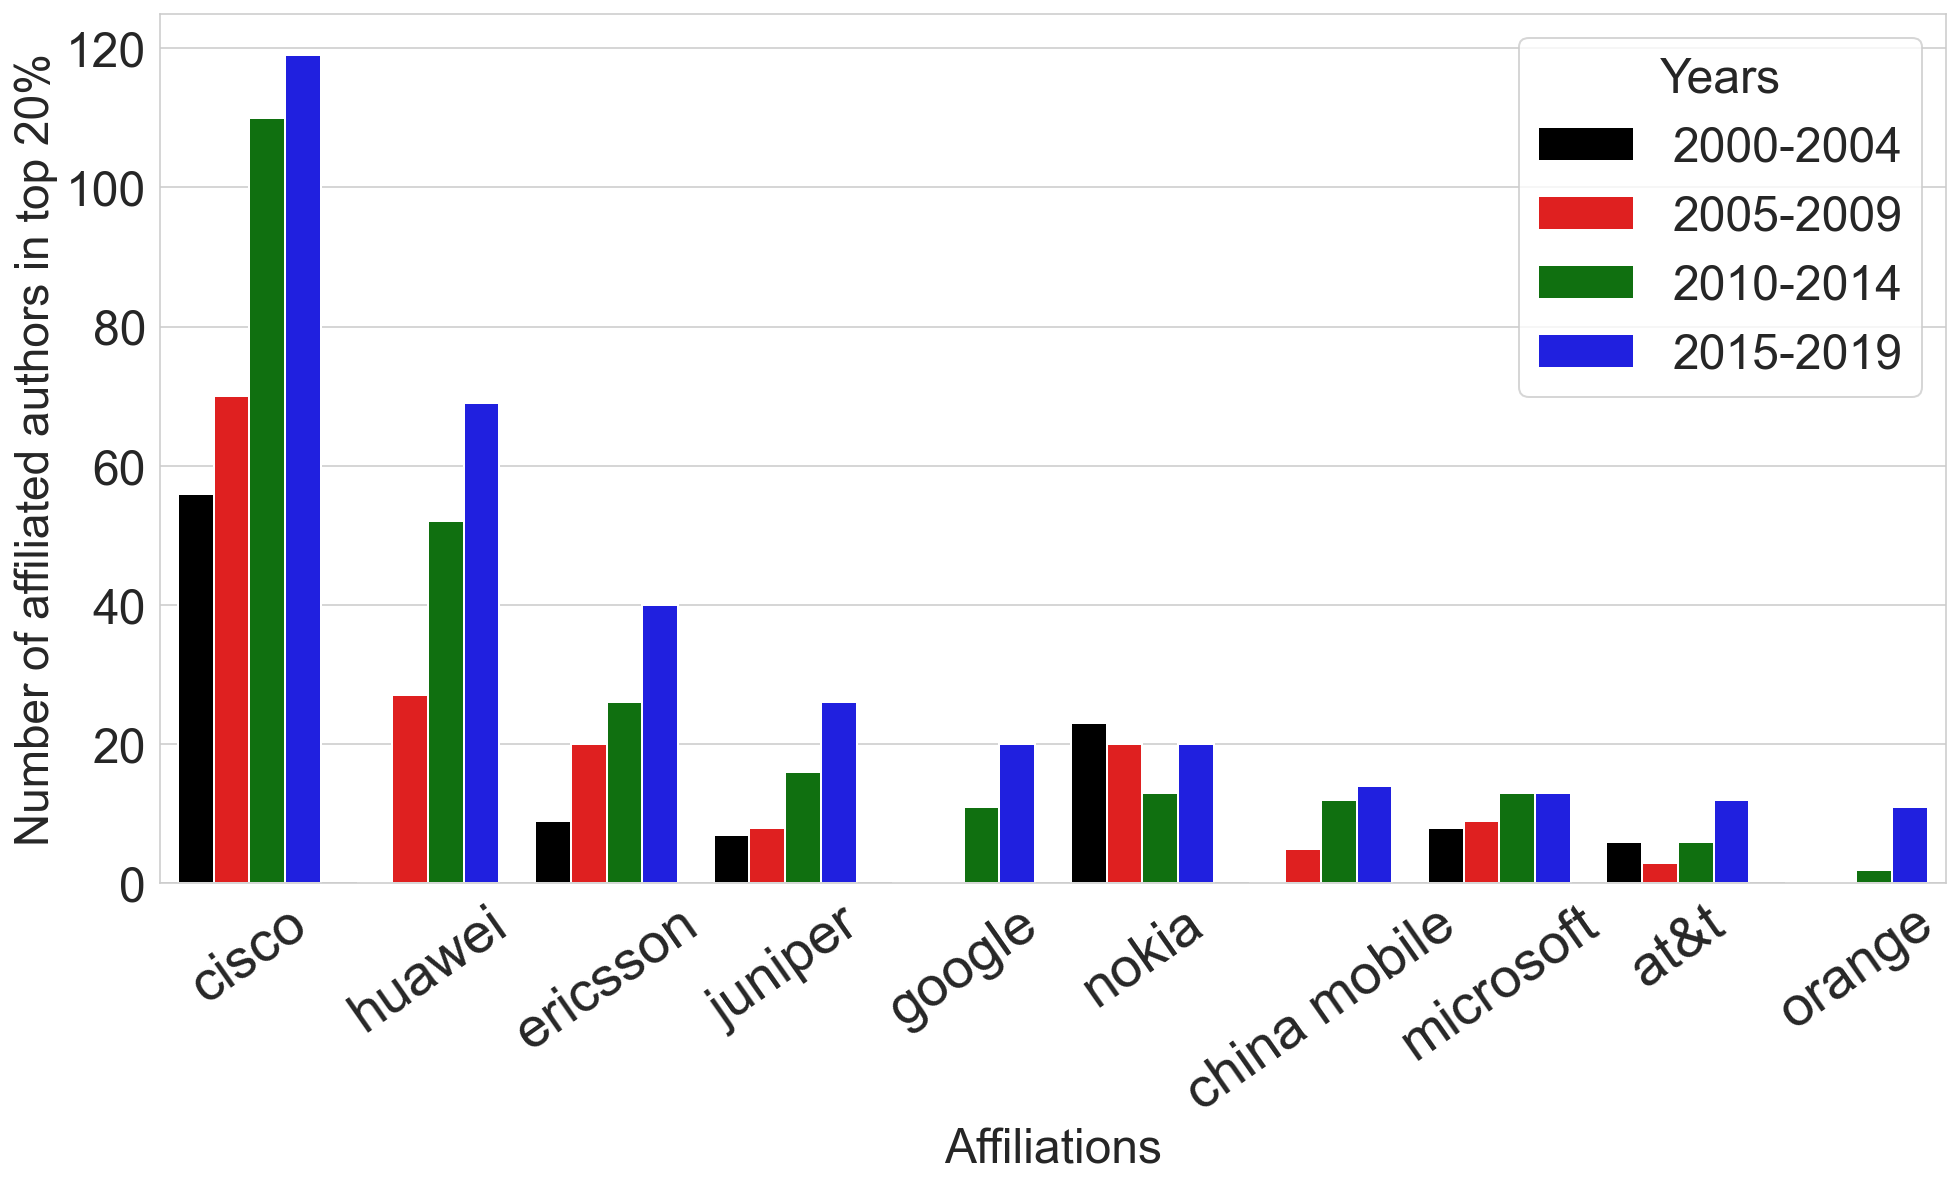

In [78]:
# FOR TOP 20%
influencer_org = most_frequent_affiliations[2019]
influencer_org = dict(sorted(influencer_org.items(), key=lambda x: x[1], reverse=True))

x1 = []
y1 = []
z1 = []
c = 0
for k in influencer_org:
    if k.lower() == 'none':
        continue
    if c > 9:
        break
    c += 1
    x1.append(k)
    y1.append(influencer_org[k])
    z1.append('2015-2019')
x2 = []    
y2 = []
z2 = []
for org in x1:
    x2.append(org)
    y2.append(most_frequent_affiliations[2004].get(org,0))
    z2.append('2000-2004')
    
    x2.append(org)
    y2.append(most_frequent_affiliations[2009].get(org,0))
    z2.append('2005-2009')
    
    x2.append(org)
    y2.append(most_frequent_affiliations[2014].get(org,0))
    z2.append('2010-2014')
    
x2.extend(x1)
y2.extend(y1)
z2.extend(z1)

aff_participant_df = pd.DataFrame({"Affiliations":x2,
                                   "Number_Participants":y2,
                                   "Years":z2
})

fig, ax_h = plt.subplots(figsize=(16,8))

color_plt = ["black","red","green","blue"]
sns.barplot(x ="Affiliations", y = 'Number_Participants', data = aff_participant_df, hue = "Years",ax=ax_h,palette=color_plt)

ax_h.set_xticklabels(ax_h.get_xticklabels(), rotation=35,
    horizontalalignment='center',size = 28)

ax_h.set_xlabel('Affiliations',fontdict={'fontsize': 24})

ax_h.set_ylabel('Number of affiliated authors in top 20%',fontdict={'fontsize': 23})

ax_h.set_yticks([0,20,40,60,80,100,120])
ax_h.set_yticklabels([0,20,40,60,80,100,120], size = 24)

legend = plt.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax_h.transAxes,fontsize=24,title="Years")
legend.get_title().set_fontsize('24')
plt.savefig('../plots/2019_affiliations_in_otheryears_coauthor_network.pdf',bbox_inches='tight')

### Non-overlapping people in two networks

In [79]:
#yearly_top_bwcnt_nodes
print('Overlap of top 20% people in authorship network with email network:')
non_overlap_author_percentile = dict()
non_overlap_author_count = dict()
for yr in [2004,2009,2014,2019]:
    author_set =  set(yearly_top_coauthor_bwcnt_nodes[yr][10]).union(set(yearly_top_coauthor_bwcnt_nodes[yr][20]))
    person_set = set(yearly_top_bwcnt_nodes[yr]['overall'][10]).union(set(yearly_top_bwcnt_nodes[yr]['overall'][20]))
    #overlap_ = len(author_set.intersection(person_set))*100/len(author_set)
    non_overlap_ = author_set-person_set
    for p in non_overlap_:
        for i in [30,40,50,60,70,80,90,100]:
            if p in yearly_top_bwcnt_nodes[yr]['overall'][i]:
                if yr in non_overlap_author_percentile:
                    non_overlap_author_percentile[yr][i] = non_overlap_author_percentile[yr].get(i,0)+1
                    
                else:
                    non_overlap_author_percentile[yr] = {i:1}
                    
    non_overlap_author_count[yr] = len(non_overlap_)
    #print("Year:"+str(yr-4)+'-'+str(yr),"Size of top 20% author ntw-"+str(len(author_set)),"Size of overlap-"+str(len(author_set.intersection(person_set))),"Percentage overlap-"+str(round(overlap_,2))+str('%'), "Email ntw size-"+str(len(person_set)))

Overlap of top 20% people in authorship network with email network:


In [80]:
non_overlap_author_percentile

{2004: {40: 24, 30: 46, 70: 4, 100: 6, 90: 12, 50: 14, 60: 13, 80: 10},
 2009: {50: 12, 90: 9, 30: 48, 40: 23, 80: 2, 60: 5, 100: 3, 70: 2},
 2014: {40: 43, 70: 15, 60: 15, 30: 83, 50: 13, 80: 5, 90: 7, 100: 5},
 2019: {40: 57, 30: 104, 70: 14, 80: 11, 60: 13, 50: 34, 100: 10, 90: 15}}

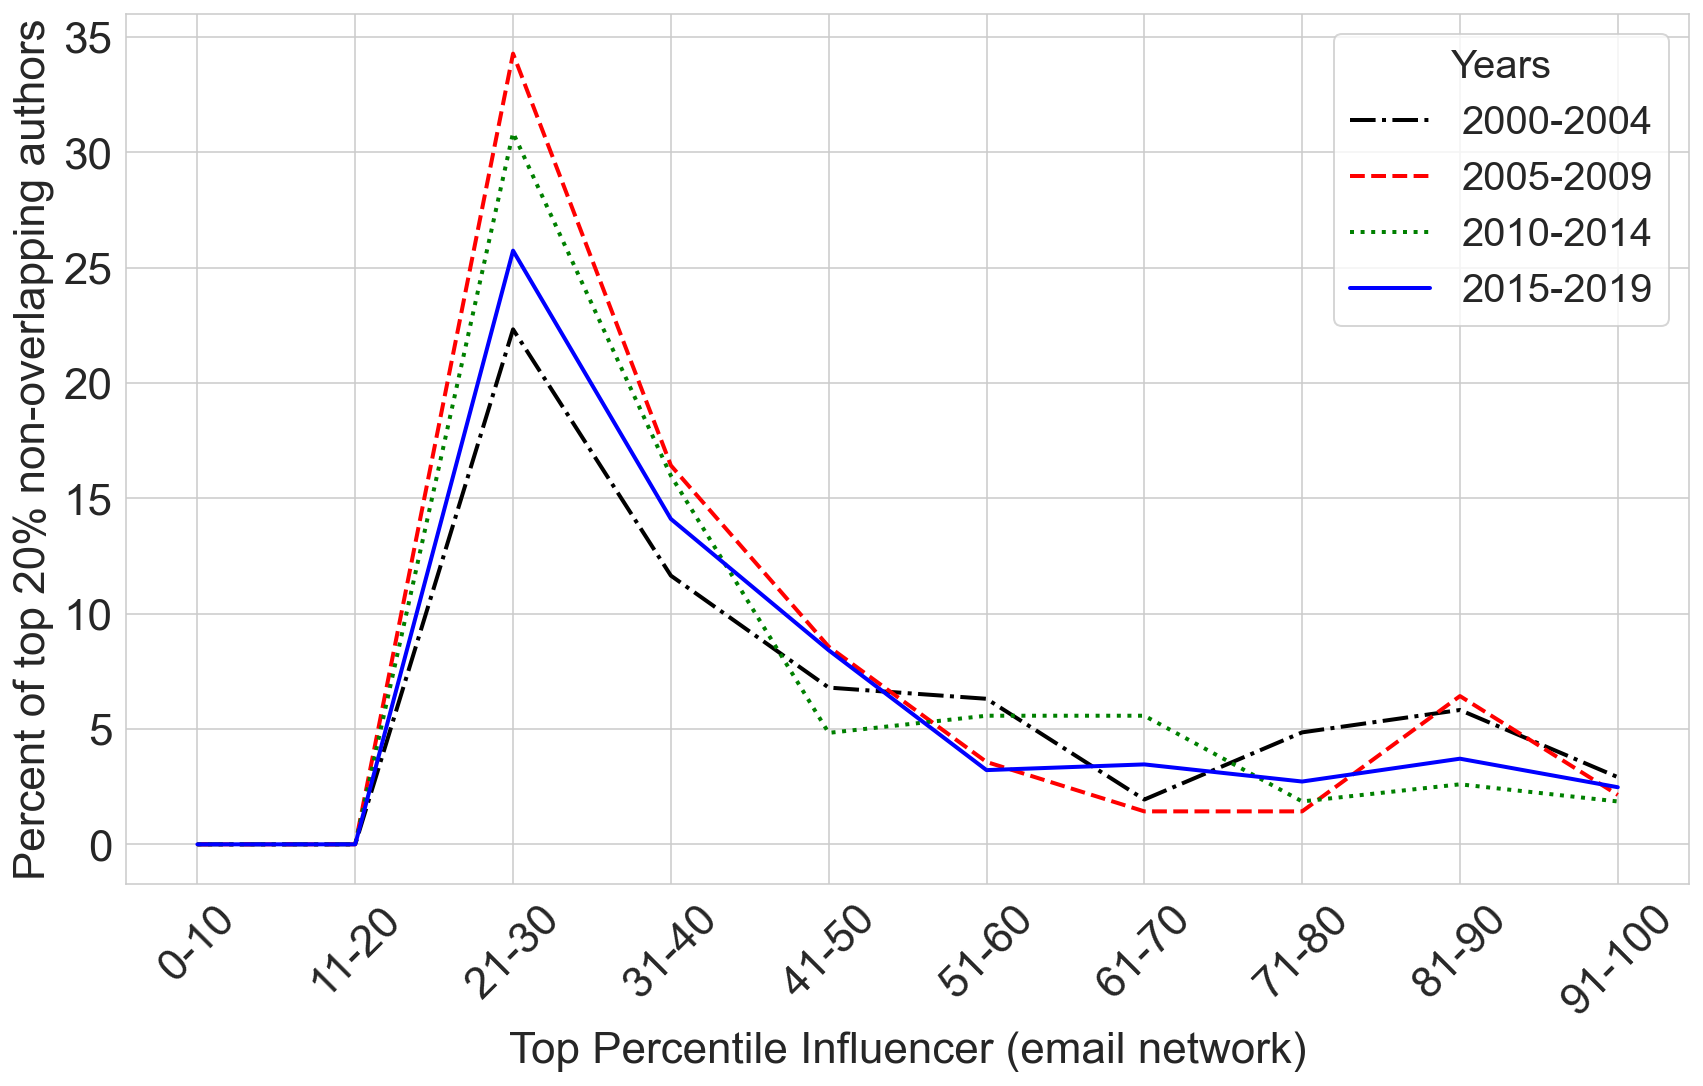

In [82]:
color_dict = {2004:"black",2009:"red",2014:"green",2019:"blue"}
linestyle_dict = {2004:"dashdot",2009:"dashed",2014:"dotted",2019:"solid"}
fig, ax_h = plt.subplots(figsize=(14,8))

for yr in [2004, 2009, 2014, 2019]:
    
    y_ = []
    x_ = []
    for i in [10,20,30,40,50,60,70,80,90,100]:
        y_.append(non_overlap_author_percentile[yr].get(i,0)*100/non_overlap_author_count[yr])
        x_.append(i)
    
    sns.lineplot(x=x_, y=y_,color=color_dict[yr], linewidth=2,ax=ax_h,label=str(yr-4)+'-'+str(yr),linestyle=linestyle_dict[yr],legend=False)
    

x1 = x_#[10,20,30,40,50,60,70,80,90,100]

ax_h.set_xticks(x1)
ax_h.set_xticklabels(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'], rotation=45,
    horizontalalignment='center',size = 22)#horizontalalignment='right'

ax_h.set_xlabel('Top Percentile Influencer (email network)',fontdict={'fontsize': 22})

ax_h.set_ylabel('Percent of top 20% non-overlapping authors',fontdict={'fontsize': 22})
ax_h.set_yticks([0,5,10,15,20,25,30,35])#,16])
ax_h.set_yticklabels([0,5,10,15,20,25,30,35], size = 22)#,16],

legend = plt.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax_h.transAxes,fontsize=20,title="Years")
legend.get_title().set_fontsize('20')

plt.savefig('../plots/lineplot_non_overlapping_authors_emailnetwork_percentile.pdf',bbox_inches='tight')

In [83]:
#yearly_top_bwcnt_nodes
print('Age distribution of overlapping and non-overlapping authors')
non_overlap_author_age = dict()
overlap_author_age = dict()
for yr in [2004,2009,2014,2019]:
    author_set =  set(yearly_top_coauthor_bwcnt_nodes[yr][10]).union(set(yearly_top_coauthor_bwcnt_nodes[yr][20]))
    person_set = set(yearly_top_bwcnt_nodes[yr]['overall'][10]).union(set(yearly_top_bwcnt_nodes[yr]['overall'][20]))
    overlap_ = author_set.intersection(person_set)#len(author_set.intersection(person_set))*100/len(author_set)
    non_overlap_ = author_set-person_set
    
    for pid in overlap_:
        years = set([])
        pid = str(pid)
        for eid in pid_emailID_dict[pid]:
            for eid in pid_emailID_dict[pid]:
                if eid in emailID_yearly_monthly_vol_dict and eid not in role_based_emailIDs and eid not in automated_list:
                    for year in emailID_yearly_monthly_vol_dict[eid]:
                        if int(year) <= int(yr):
                            for month in emailID_yearly_monthly_vol_dict[eid][year]:
                                t_date = date(int(year),int(month),1)
                                years.add(t_date)

        if years and int(max(years).year)>1994 and int(min(years).year)>1994:
            year_born = min(years)
            #age = round_to(((date(int(yr),12,31)-year_born).days)/365,0.5)
            #AGE to be calculated as per last email in the time period
            age = round_to(((min(date(int(yr),12,31),max(years))-year_born).days)/365,0.5)
            if age >= 0:
                if yr in overlap_author_age:
                    overlap_author_age[yr].append(age)
                else:
                    overlap_author_age[yr] = [age]
                
    for pid in non_overlap_:
        years = set([])
        pid = str(pid)
        for eid in pid_emailID_dict[pid]:
            for eid in pid_emailID_dict[pid]:
                if eid in emailID_yearly_monthly_vol_dict and eid not in role_based_emailIDs and eid not in automated_list:
                    for year in emailID_yearly_monthly_vol_dict[eid]:
                        if int(year) <= int(yr):
                            for month in emailID_yearly_monthly_vol_dict[eid][year]:
                                t_date = date(int(year),int(month),1)
                                years.add(t_date)

        if years and int(max(years).year)>1994 and int(min(years).year)>1994:
            year_born = min(years)
            #age = round_to(((date(int(yr),12,31)-year_born).days)/365,0.5)
            #AGE to be calculated as per last email in the time period
            age = round_to(((min(date(int(yr),12,31),max(years))-year_born).days)/365,0.5)
            if age >= 0:
                if yr in non_overlap_author_age:
                    non_overlap_author_age[yr].append(age)
                else:
                    non_overlap_author_age[yr] = [age]


Age distribution of overlapping and non-overlapping authors


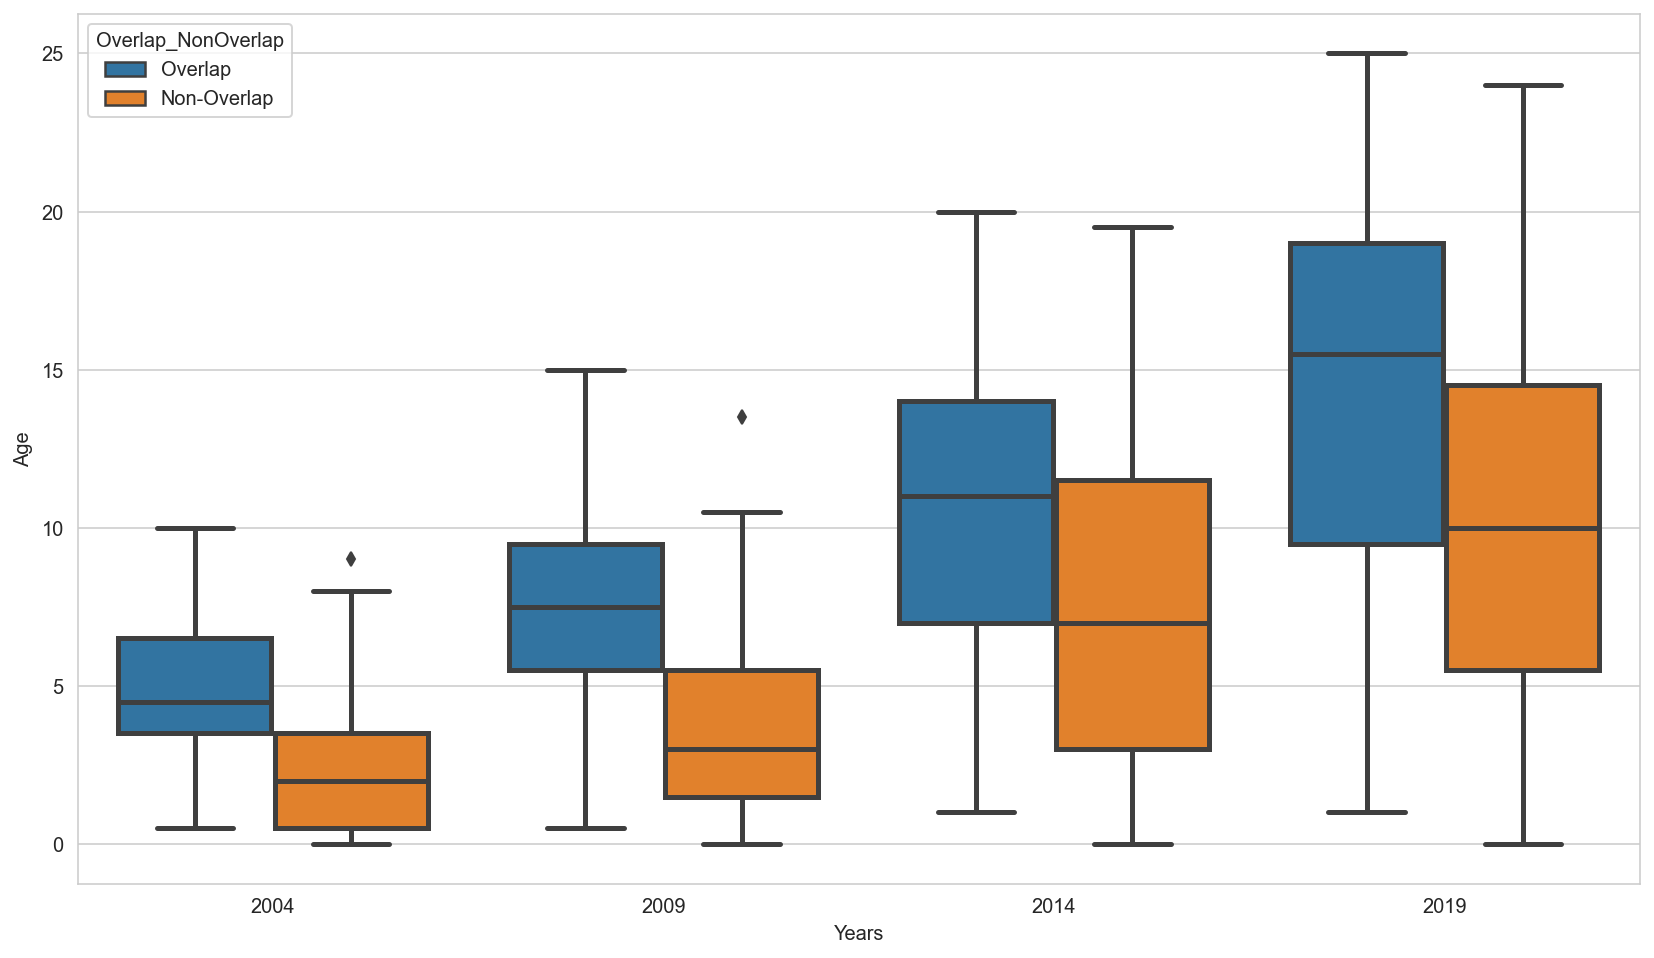

In [84]:
overlap_nonoverlap_df = pd.DataFrame(columns = ["Overlap_NonOverlap","Age","Years"])
for yr in overlap_author_age:
    for ag in overlap_author_age[yr]:
        overlap_nonoverlap_df.loc[0 if pd.isnull(overlap_nonoverlap_df.index.max()) else overlap_nonoverlap_df.index.max() + 1] = ["Overlap",ag,yr]
        
for yr in non_overlap_author_age:
    for ag in non_overlap_author_age[yr]:
        overlap_nonoverlap_df.loc[0 if pd.isnull(overlap_nonoverlap_df.index.max()) else overlap_nonoverlap_df.index.max() + 1] = ["Non-Overlap",ag,yr]    
fig, ax_h = plt.subplots(figsize=(14,8))

ax8 = sns.boxplot(x="Years", y="Age", hue="Overlap_NonOverlap",
                 data=overlap_nonoverlap_df, linewidth=2.5)

plt.savefig('../plots/age_overlap_nonoverlap_author_email.pdf',bbox_inches='tight')

## Draft-affiliation network

In [85]:
yearly_org_graph = dict()

for yr in [2004,2009,2014,2019]:
    G = nx.Graph()
    for yr2 in yearly_document_dict:
        #yr2 = int(yr2)
        if int(yr2) <= yr and int(yr2) > (yr-5):
            for doc in yearly_document_dict[yr2]:
                nodes = []
                for author in document_author_dict[doc]:
                    author = str(author)
                    aff = Counter(pid_affiliation[author][yr2]).most_common(1)[0][0]
                    aff = aff.strip()
                    if aff == 'nortelnetworks':
                        aff = 'nortel'
                    if aff == 'gmail' or aff == 'yahoo' or aff == 'yahoomail':
                        aff = pid_name_dict[author][0]
                    nodes.append(aff)
                    if aff not in G:
                        G.add_nodes_from([aff])
                for i in itertools.combinations(nodes,2):
                    G.add_edges_from([(i[0],i[1])])
    yearly_org_graph[yr] = G

In [87]:
yearly_org_multigraph = dict()
single_org_authors = dict()
for yr in [2004,2009,2014,2019]:
    #G = nx.Graph()
    G = nx.MultiGraph()
    c = 0
    for yr2 in yearly_document_dict:
        #yr2 = int(yr2)
        if int(yr2) <= yr and int(yr2) > (yr-5):
            
            for doc in yearly_document_dict[yr2]:
                
                if 'document/draft' not in doc.lower():
                    continue
            
                if '/draft-ietf' in doc.lower():
                    continue
                c += 1
                #nodes = []
                nodes = set([])
                for author in document_author_dict[doc]:
                    author = str(author)
                    aff = Counter(pid_affiliation[author][yr2]).most_common(1)[0][0]
                    aff = aff.strip()
                    aff = aff.strip(',')
                    if aff == 'nortelnetworks':
                        aff = 'nortel'
                    if aff == 'gmail' or aff == 'yahoo' or aff == 'yahoomail':
                        aff = pid_name_dict[author][0]
                    #nodes.append(aff.lower())
                    nodes.add(aff.lower())
                    if aff.lower() not in G:
                        G.add_nodes_from([aff.lower()])
                if len(nodes) == 1:
                    if yr in single_org_authors:
                        single_org_authors[yr][aff.lower()] = single_org_authors[yr].get(aff.lower(),0)+1
                    else:
                        single_org_authors[yr] = {aff.lower() : 1}
                    
                for i in itertools.combinations(nodes,2):
                    if (i[0], i[1]) in G.edges():
                        G[i[0]][i[1]][0]['weight'] += 1
                    else:
                        G.add_edge(i[0], i[1],weight = 1)
                    #G.add_edges_from([(i[0],i[1])])
    print(yr,c)
    yearly_org_multigraph[yr] = G

2004 3946
2009 4017
2014 5830
2019 6468


In [88]:
# FOR TOP 20%
influencer_org = most_frequent_affiliations[2019]
influencer_org = dict(sorted(influencer_org.items(), key=lambda x: x[1], reverse=True))

x1 = []

c = 0
for k in influencer_org:
    if k.lower() == 'none':
        continue
    if c > 14:
        break
    c += 1
    x1.append(k)

aff_org_collab_df = pd.DataFrame(index=x1, columns=x1)#Years is [1995,2020],moving it to 2000
aff_org_collab_df = aff_org_collab_df.fillna(0)

for yr in [2019]:

    for itm in sorted(yearly_org_multigraph[yr].edges(data=True),key= lambda x: x[2]['weight'],reverse=True):
        if itm[0] in x1 and itm[1] in x1:
        
            aff_org_collab_df.at[itm[0],itm[1]] = itm[2]['weight']
            aff_org_collab_df.at[itm[1],itm[0]] = itm[2]['weight']
        
    for aff in x1:
        aff_org_collab_df.at[aff,aff] = single_org_authors[yr][aff]
        
aff_org_collab_df.head(10)

cisco  huawei  ericsson  juniper  google  nokia  china mobile  \
cisco           273     221       113      188      31     65            19   
huawei          221     382       145      103      15     41           108   
ericsson        113     145       127       53       8     23             7   
juniper         188     103        53       64      17     38             5   
google           31      15         8       17      76      6             0   
nokia            65      41        23       38       6     30             8   
china mobile     19     108         7        5       0      8            35   
microsoft        39      22        14       24      21      7             0   
at&t             32      16        14       13       5     16             2   
orange           60      51        16       33       4     14             2   

              microsoft  at&t  orange  alcatel-lucent  deutsche  apple  ibm  \
cisco                39    32      60              30        37      7    1   
huawei               22    16      51              16        34      0    2   
ericsson             14    14      16              18        16      5    1   
juniper              24    13      33              18        20      0    0   
google               21     5       4               2         4      4    1   
nokia                 7    16      14               7         6      1    1   
china mobile          0     2       2               0         8      0    0   
microsoft            45     6       1               7        11      3    1   
at&t                  6    17      10               2         4      0    2   
orange                1    10      31               7        14      0    0   

              icann  
cisco             7  
huawei            2  
ericsson          1  
juniper           1  
google            6  
nokia             0  
china mobile      0  
microsoft         0  
at&t              1  
orange            0

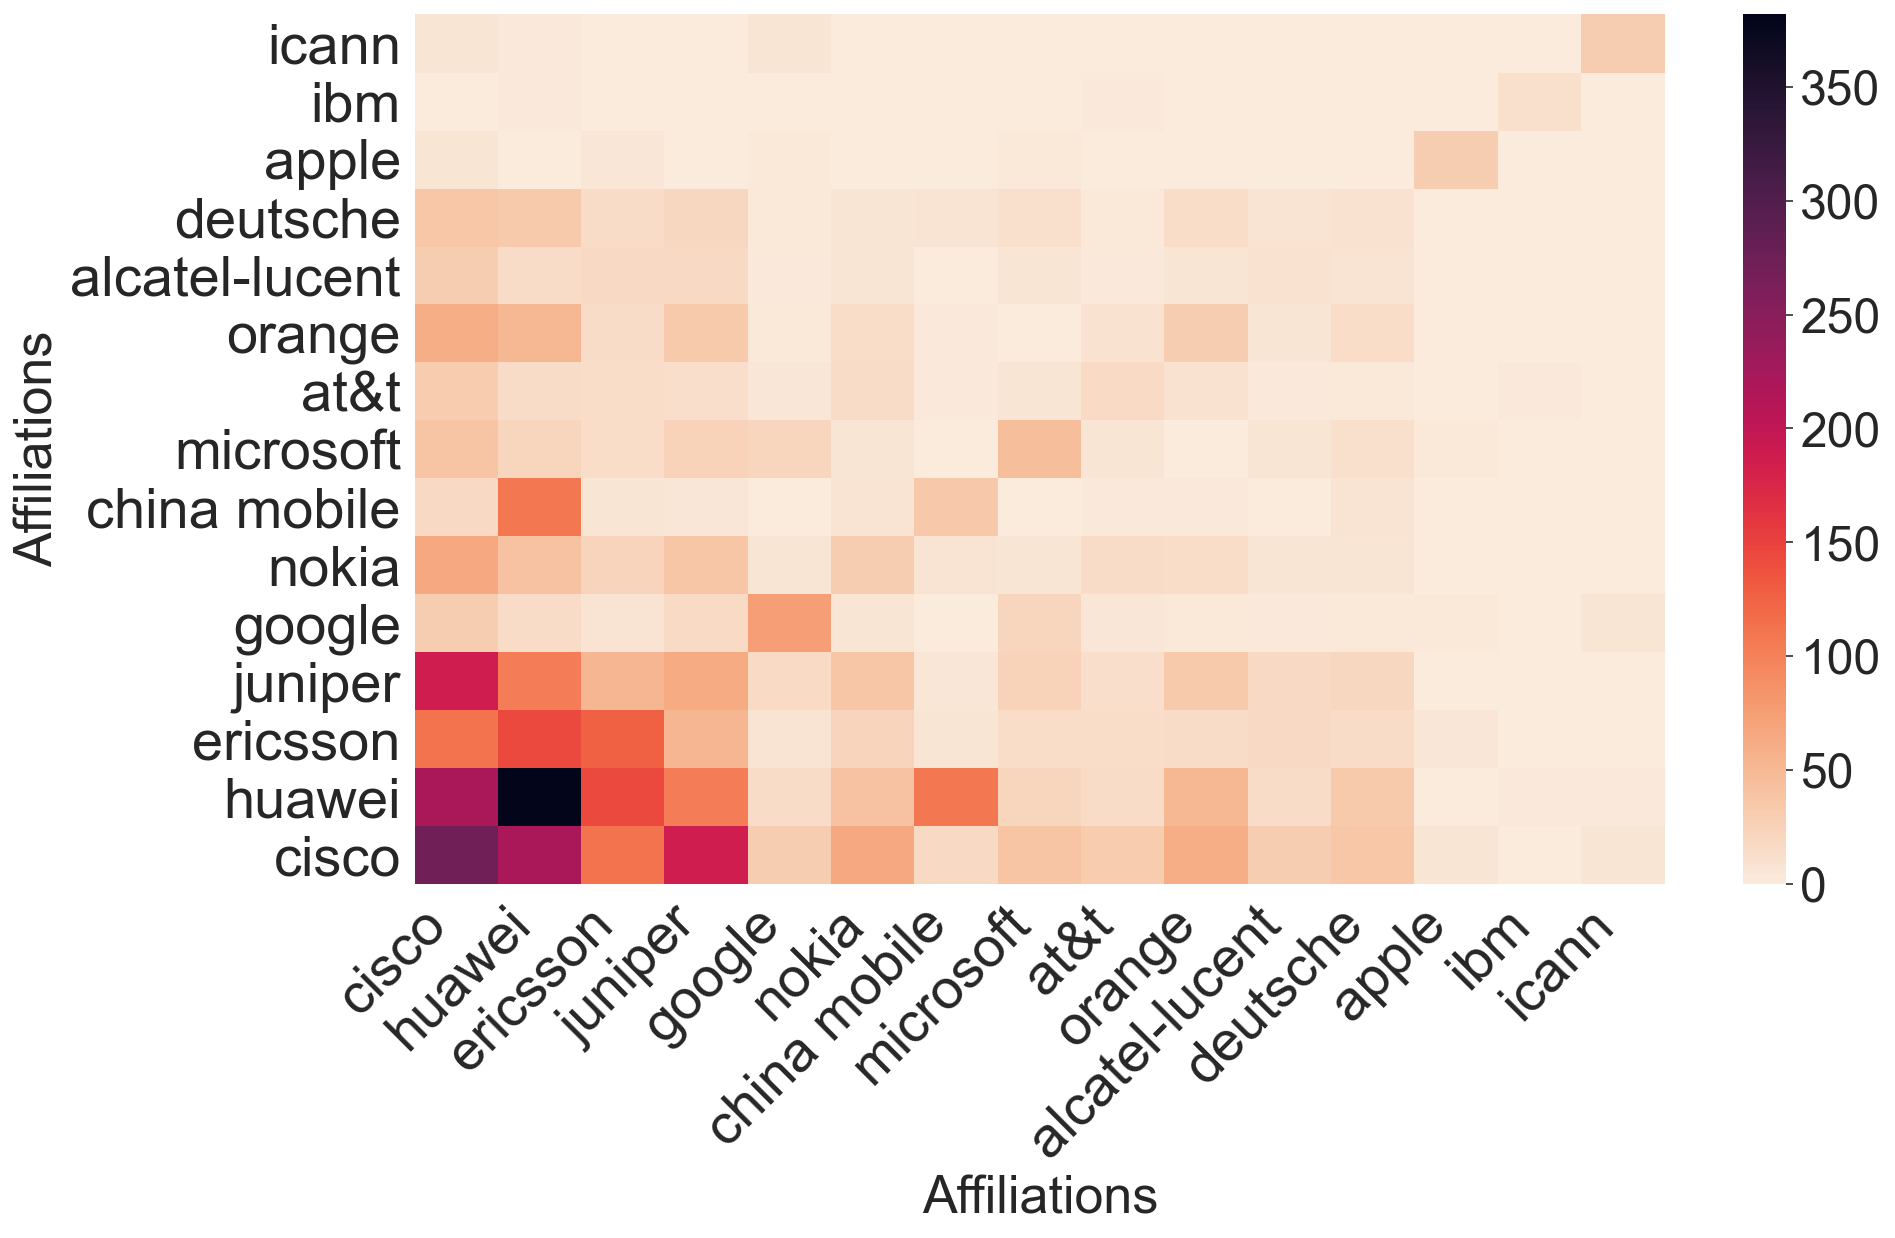

In [89]:
fig, ax_h = plt.subplots(figsize=(14,8))

mask = np.zeros_like(aff_org_collab_df, dtype='bool')
mask[np.triu_indices_from(mask)] = True

sns.heatmap(aff_org_collab_df, vmin=0, vmax=max(aff_org_collab_df.max()), ax=ax_h,cmap = 'rocket_r')

cbar = ax_h.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=24)

ax_h.set_xticklabels(ax_h.get_xticklabels(), rotation=45,
    horizontalalignment='right',size = 28)

ax_h.set_xlabel('Affiliations',fontdict={'fontsize': 26})
ax_h.set_ylabel('Affiliations',fontdict={'fontsize': 26})
ax_h.invert_yaxis()
   
ax_h.set_yticklabels(ax_h.get_xticklabels(), size = 28)

plt.savefig('../plots/heatmap_2019_top10_affiliation_collaboration.pdf', bbox_inches='tight')

## Role based people

In [90]:
wg_chair_history = pd.read_csv('../data/wg_chair_history.csv')
wg_chair_history.head()

name  group                start                  end
0        Kenny Paterson   cfrg  2015-07-12 01:54:22  2020-01-14 14:14:00
1       Alexey Melnikov   cfrg  2015-07-12 01:54:22                 None
2         Nick Sullivan   cfrg  2019-05-01 15:05:02                 None
3  Stanislav Smyshlyaev   cfrg  2020-01-14 14:14:00                 None
4             Joerg Ott  dtnrg  2015-01-23 04:06:57  2016-04-05 06:40:00

In [92]:
wg_chair_start_dates = dict()

for i,row in wg_chair_history.iterrows():
    d = datetime.strptime(row['start'], '%Y-%m-%d %H:%M:%S').date()
    if row['name'].lower() not in wg_chair_start_dates:
        wg_chair_start_dates[row['name'].lower()] =  d
    else:
        #print('repeat record')
        if d < wg_chair_start_dates[row['name'].lower()]:
            wg_chair_start_dates[row['name'].lower()] = d
            #print('update')
        
print(len(wg_chair_start_dates))

401


In [94]:
yearly_coauthor_graph_full = dict()
for yr in range(1999,2021):
    G = nx.Graph()
    
    for yrs in yearly_document_dict:
        if int(yrs) <= yr and int(yrs) > (yr-5):
            for doc in yearly_document_dict[yrs]:
                
                nodes = set([])
                for author in document_author_dict[doc]:
                    nodes.add(author)
                    if author not in G:
                        G.add_nodes_from([author])
                for i in itertools.combinations(nodes,2):
                    G.add_edges_from([(i[0], i[1])])
                    
    yearly_coauthor_graph_full[yr] = G
    print(yr,len(G))

1999 1106
2000 1377
2001 1685
2002 1883
2003 1978
2004 1993
2005 1979
2006 1879
2007 1860
2008 1965
2009 2144
2010 2343
2011 2406
2012 2605
2013 3574
2014 3713
2015 4646
2016 4868
2017 5020
2018 4549
2019 4594
2020 4128


In [95]:
yearly_top_coauthor_bwcnt_nodes_full = dict()
for yr in range(1999,2021):
    G1 = yearly_coauthor_graph_full[yr]
    if len(G1) > 0:
        d = centrality.betweenness_centrality(G1)
        d = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
        
        yearly_top_coauthor_bwcnt_nodes_full[yr] = d

    print(yr,len(G1),len(yearly_top_coauthor_bwcnt_nodes_full))

1999 1106 1
2000 1377 2
2001 1685 3
2002 1883 4
2003 1978 5
2004 1993 6
2005 1979 7
2006 1879 8
2007 1860 9
2008 1965 10
2009 2144 11
2010 2343 12
2011 2406 13
2012 2605 14
2013 3574 15
2014 3713 16
2015 4646 17
2016 4868 18
2017 5020 19
2018 4549 20
2019 4594 21
2020 4128 22


In [96]:
yearly_bwcnt_nodes_full = dict()

lst_spam_messageIDs = list(spam_messageIDs)
for yr in range(1999,2021):
    for typ in ['overall']:#'wg'#['wg','rg','meeting','overall']:#,'dir','review','announcements']:
        
        if typ != 'overall':
            
            #LOOKING FOR LAST 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to')  & (df_mappings.Interaction_timestamp <= date(yr,12,31))  & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (df_mappings.Mailinglist_type == typ) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        else:

            #LOOKING FOR LAST 5 YEAR HISTORY
            df_mappings4 = df_mappings.loc[(df_mappings.Type == 'reply_to') & (df_mappings.Interaction_timestamp <= date(yr,12,31)) & (df_mappings.Interaction_timestamp > date(yr-5,12,31)) & (~df_mappings.MessageID_A.isin(lst_spam_messageIDs)) & (~df_mappings.MessageID_B.isin(lst_spam_messageIDs))]
        
        G1 = nx.Graph()
        
        for i, r in df_mappings4.iterrows():
            
            if r['A_PersonID_From'] in pid_rolebased:
                continue
            if r['B_PersonID_To'] in pid_rolebased:
                continue
                
            if r['A_PersonID_From'] not in G1:
                G1.add_nodes_from([r['A_PersonID_From']])
            if r['B_PersonID_To'] not in G1:
                G1.add_nodes_from([r['B_PersonID_To']])
                
            G1.add_edges_from([(r['A_PersonID_From'], r['B_PersonID_To'])])
            
        if len(G1) > 0:
          
            d = centrality.betweenness_centrality(G1)
            d = dict(sorted(d.items(), key=lambda x: x[1], reverse=True))
            
            yearly_bwcnt_nodes_full[yr] = d
                        
        print(yr,len(yearly_bwcnt_nodes_full),len(G1))

1999 1 1764
2000 2 2550
2001 3 3541
2002 4 4761
2003 5 6143
2004 6 6951
2005 7 7620
2006 8 8104
2007 9 8237
2008 10 8063
2009 11 8311
2010 12 8336
2011 13 8247
2012 14 8165
2013 15 8240
2014 16 8197
2015 17 8056
2016 18 7889
2017 19 7675
2018 20 7259
2019 21 6850
2020 22 6437


In [97]:
overall_distribution = []
x_axis_category = []
year_list = []

error_ids = set([])
for name in wg_chair_start_dates:
    if name not in name_pid_dict:
        continue
    
    yr = wg_chair_start_dates[name].year
    
    if yr < 2000 or yr > 2019:
        continue

    email_rank_before = 100
    coauthor_rank_before = 100
    
    email_network_list_before = []
    
    for k in yearly_bwcnt_nodes_full[yr-1]:
        email_network_list_before.append(k)
        
    coauthor_network_list_before = []
    
    for k in yearly_top_coauthor_bwcnt_nodes_full[yr-1]:
        coauthor_network_list_before.append(k)
    
    pid = int(name_pid_dict[name])
    
    if pid in email_network_list_before:
        email_rank_before = (email_network_list_before.index(pid)*100/len(email_network_list_before))//1
    else:
        error_ids.add(pid)
        continue
        #print(name, pid, 'Not in email network')
    if pid in coauthor_network_list_before:
        coauthor_rank_before = (coauthor_network_list_before.index(pid)*100/len(coauthor_network_list_before))//1
    else:
        error_ids.add(pid)
        continue
        #print(name, pid, 'Not in co-author network')
        
    #distribution_in_emailnetwork_before.append(email_rank_before)
    #distribution_in_authornetwork_before.append(coauthor_rank_before)
    overall_distribution.append(email_rank_before)
    x_axis_category.append("Email Network-Before")
    overall_distribution.append(coauthor_rank_before)
    x_axis_category.append("Coauthor Network-Before")
    year_list.append(yr)
    year_list.append(yr)
    
    
    #######################
    email_rank_after = 100
    coauthor_rank_after = 100
    
    email_network_list_after = []
    
    for k in yearly_bwcnt_nodes_full[yr+1]:
        email_network_list_after.append(k)
        
    coauthor_network_list_after = []
    
    for k in yearly_top_coauthor_bwcnt_nodes_full[yr+1]:
        coauthor_network_list_after.append(k)
    
    
    if pid in email_network_list_after:
        email_rank_after = (email_network_list_after.index(pid)*100/len(email_network_list_after))//1
    else:
        error_ids.add(pid)
        continue
        #print(name, pid, 'Not in email network')
    if pid in coauthor_network_list_after:
        coauthor_rank_after = (coauthor_network_list_after.index(pid)*100/len(coauthor_network_list_after))//1
    else:
        error_ids.add(pid)
        continue
        #print(name, pid, 'Not in co-author network')
        
    #distribution_in_emailnetwork_after.append(email_rank_after)
    #distribution_in_authornetwork_after.append(coauthor_rank_after)
    overall_distribution.append(email_rank_after)
    x_axis_category.append("Email Network-After")
    overall_distribution.append(coauthor_rank_after)
    x_axis_category.append("Coauthor Network-After")
    year_list.append(yr)
    year_list.append(yr)
    
print(len(wg_chair_start_dates),len(error_ids))

401 67


In [98]:
wg_before_after_df = pd.DataFrame({"Percentile_Level":overall_distribution, "Before_After_Category":x_axis_category,"Role_Year":year_list})

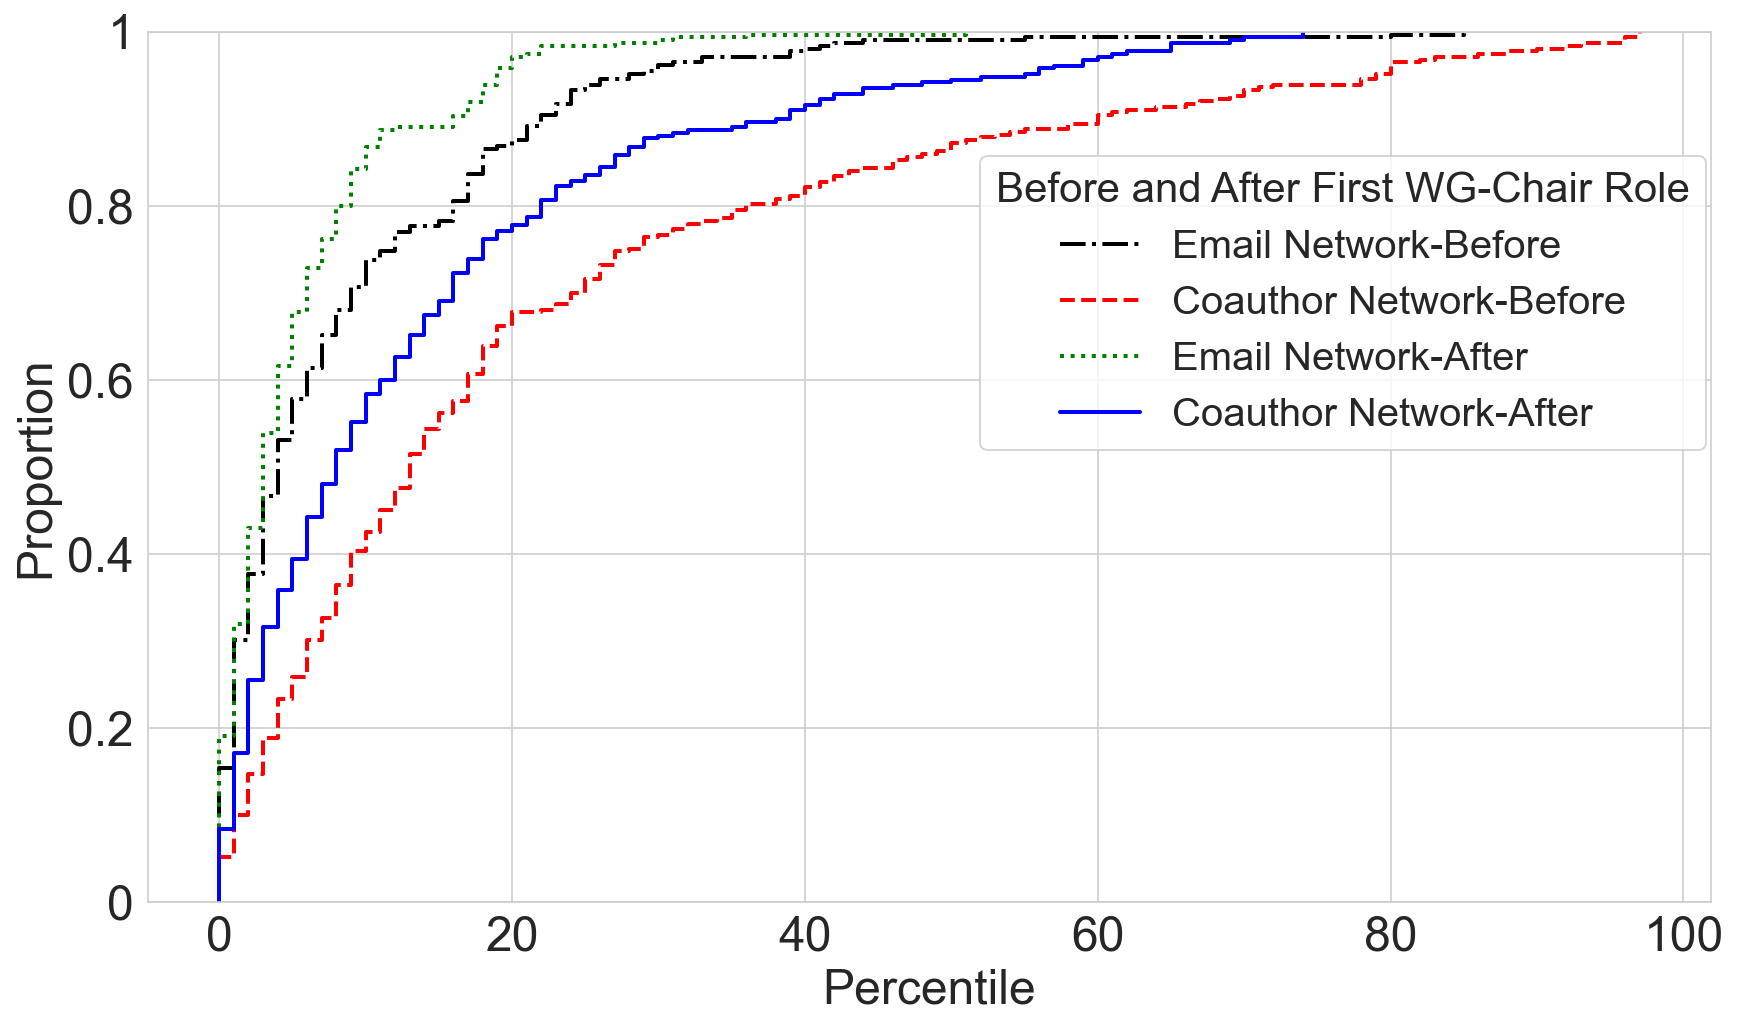

In [100]:
color_dict = {'Email Network-Before':"black",'Coauthor Network-Before':"red",'Email Network-After':"green",'Coauthor Network-After':"blue"}
linestyle_dict = {'Email Network-Before':"dashdot",'Coauthor Network-Before':"dashed",'Email Network-After':"dotted",'Coauthor Network-After':"solid"}

fig, ax_h = plt.subplots(figsize=(14,8))

for catg in ['Email Network-Before','Coauthor Network-Before','Email Network-After','Coauthor Network-After']:# in [2004,2009,2014,2019]:

    sns.ecdfplot(wg_before_after_df.loc[wg_before_after_df.Before_After_Category == catg].Percentile_Level.tolist(),color=color_dict[catg], linewidth=2,ax=ax_h,label=catg,linestyle=linestyle_dict[catg],legend=False)

ax_h.set_xlabel('Percentile',fontdict={'fontsize': 24})
ax_h.set_ylabel('Proportion',fontdict={'fontsize': 24})


###
ax_h.set_xticks([0,20,40,60,80,100])
ax_h.set_xticklabels([0,20,40,60,80,100],size = 24)#,rotation=90)#fontsize='x-large')
ax_h.set_yticks([0, 0.2,0.4,0.6,0.8,1])
ax_h.set_yticklabels([0, 0.2,0.4,0.6,0.8,1], size = 24)

legend1 = fig.legend(loc="upper right", bbox_to_anchor=(1.01,0.88), bbox_transform=ax_h.transAxes,fontsize=20,title="Before and After First WG-Chair Role")
legend1.get_title().set_fontsize('21')

###

plt.savefig('../plots/WG_chair_percentile_CDF_before_after.pdf', bbox_inches='tight')

# Author feature generation

In [101]:
all_drafts_set = set([])

with open('../data/submission_author_data.csv', 'r') as file:
    reader = csv.reader(file,quoting=csv.QUOTE_NONE)
    for row in reader:
        all_drafts_set.add(row[0].lower())
        
for i,row in submission_doc_data.iterrows():
    all_drafts_set.add(row['doc_name'].lower())
print(len(all_drafts_set))

21839


In [108]:
draft_version_dates = dict()
draft_final_version_dates = dict()

for i,row in submission_doc_data.iterrows():
    
    if row['state'] == 'cancel' or row['date'] == 'None' or row['date'] != row['date'] or row['revision_num'] != row['revision_num']:
        continue
    #print(row)
    if row['doc_name'].lower() in draft_version_dates:
        if int(row['revision_num']) not in draft_version_dates[row['doc_name'].lower()]:
            draft_version_dates[row['doc_name'].lower()][int(row['revision_num'])] = datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S').date()
    else:
        draft_version_dates[row['doc_name'].lower()] = {int(row['revision_num']) : datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S').date()}

    if row['doc_name'].lower() in draft_final_version_dates:
        if int(row['revision_num']) > next(iter(draft_final_version_dates[row['doc_name'].lower()])):
            draft_final_version_dates[row['doc_name'].lower()] = {int(row['revision_num']) : datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S').date()}        
    else:
        draft_final_version_dates[row['doc_name'].lower()] = {int(row['revision_num']) : datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S').date()}
    if len(draft_version_dates)%5000 == 0:
        print(len(draft_version_dates),len(draft_final_version_dates))

5000 5000
5000 5000
5000 5000
10000 10000
10000 10000
10000 10000
10000 10000
10000 10000
10000 10000
10000 10000
15000 15000
15000 15000
15000 15000
15000 15000
20000 20000
20000 20000
20000 20000
20000 20000
20000 20000


In [110]:
draft_version_personID_dict = dict()
for draft in draft_version_authors:
    for version in draft_version_authors[draft]:
        pid_set = []#set([])
        for author in draft_version_authors[draft][version]:
            #if author[0] in datatracker_pid_dict:
            #    if datatracker_pid_dict[author[0]] not in pid_set:
            #        pid_set.append(datatracker_pid_dict[author[0]])
            au_split = author.split('_str_')
            if au_split[1] in emailID_pid_dict:
                if emailID_pid_dict[au_split[1]] not in pid_set:
                    pid_set.append(emailID_pid_dict[au_split[1]])
            elif au_split[0] in name_pid_dict:
                if name_pid_dict[au_split[0]] not in pid_set:
                    pid_set.append(name_pid_dict[au_split[0]])
            else:
                pid_set.append(0)
        if draft in draft_version_personID_dict:
            draft_version_personID_dict[draft][version] = pid_set
        else:
            draft_version_personID_dict[draft] = {version: pid_set}#list(pid_set)
        if len(pid_set) == 0:
            print(draft,version)
        #else:
            #print(len(draft_final_version_personID_dict))
    if len(draft_version_personID_dict)%5000 == 0:
        print(len(draft_version_personID_dict))

5000
10000
15000
20000


In [102]:
prominent_aff = dict()
for yr in [2004,2009,2014,2019]:
    author_set =  yearly_top_coauthor_bwcnt_nodes[yr][10]#yearly_top_bwcnt_nodes[yr]['overall'][10]
    for author in author_set:
        author = str(author)
        l_aff = []
        for yr2 in pid_affiliation[author]:
            if int(yr2) <= yr and int(yr2) > (yr-5):
                l_aff.extend(pid_affiliation[author][yr2])
        aff = Counter(l_aff).most_common(1)[0][0]
        aff = aff.strip()
        if aff == 'nortelnetworks':
            aff = 'nortel'
        if aff == 'gmail' or aff == 'yahoo' or aff == 'yahoomail':
            aff = pid_name_dict[author][0]
            
        prominent_aff[aff] = prominent_aff.get(aff,0)+1

print(len(prominent_aff))

422


In [103]:
prominent_aff = dict(sorted(prominent_aff.items(), key=lambda x: x[1], reverse=True))

In [104]:
top20_most_frequnt = []
for k in prominent_aff:
    top20_most_frequnt.append(k)
    if len(top20_most_frequnt) == 20:
        break

In [111]:
cols_list = ['Draft','Bwc_most_infl','Bwc_least_infl','Bwc_avg','Email_count_most_infl','Email_count_least_infl','Email_count_avg','Age_most_infl','Age_least_infl','Age_avg','Total_authors','In_top10','In_next20','Draft_published_most_infl','Draft_published_least_infl','Draft_published_avg','Areas_most_infl','Areas_least_infl','Areas_avg', 'Mlist_count_most_infl', 'Mlist_count_least_infl', 'Mlist_count_avg']
cols_list.extend(top20_most_frequnt)

drafts_final_version_authors_features_df = pd.DataFrame(columns=cols_list)
drafts_final_version_authors_features_df.head()

Empty DataFrame
Columns: [Draft, Bwc_most_infl, Bwc_least_infl, Bwc_avg, Email_count_most_infl, Email_count_least_infl, Email_count_avg, Age_most_infl, Age_least_infl, Age_avg, Total_authors, In_top10, In_next20, Draft_published_most_infl, Draft_published_least_infl, Draft_published_avg, Areas_most_infl, Areas_least_infl, Areas_avg, Mlist_count_most_infl, Mlist_count_least_infl, Mlist_count_avg, cisco, huawei, ericsson, nokia, juniper, nortel, microsoft, sun, at&t, china mobile, alcatel-lucent, nec, comcast, google, ibm, alcatel, mit, uc3m, france, tsinghua university]
Index: []

[0 rows x 42 columns]

In [112]:
for draft in all_drafts_set:
    #row_ = [r['id']]
    row_ = [draft]
    row_.extend([0]*41)
    drafts_final_version_authors_features_df.loc[0 if pd.isnull(drafts_final_version_authors_features_df.index.max()) else drafts_final_version_authors_features_df.index.max() + 1] = row_
drafts_final_version_authors_features_df.head(2)

Draft Bwc_most_infl Bwc_least_infl  \
0  draft-wu-pce-discovery-priority-allocation             0              0   
1                     draft-du-anima-ipv4-acp             0              0   

  Bwc_avg Email_count_most_infl Email_count_least_infl Email_count_avg  \
0       0                     0                      0               0   
1       0                     0                      0               0   

  Age_most_infl Age_least_infl Age_avg  ... alcatel-lucent nec comcast google  \
0             0              0       0  ...              0   0       0      0   
1             0              0       0  ...              0   0       0      0   

  ibm alcatel mit uc3m france tsinghua university  
0   0       0   0    0      0                   0  
1   0       0   0    0      0                   0  

[2 rows x 42 columns]

In [113]:
cols_tobe_updated = ['Bwc_most_infl','Bwc_least_infl','Bwc_avg','Email_count_most_infl','Email_count_least_infl','Email_count_avg','Age_most_infl','Age_least_infl','Age_avg','Total_authors','In_top10','In_next20','Draft_published_most_infl','Draft_published_least_infl','Draft_published_avg','Areas_most_infl','Areas_least_infl','Areas_avg', 'Mlist_count_most_infl', 'Mlist_count_least_infl', 'Mlist_count_avg']
cols_tobe_updated.extend(top20_most_frequnt)
d_c = 0
d_d = 0
none_author_centrality = set([])
for draft in draft_final_version_dates:
    if draft not in draft_version_personID_dict:
        continue
        
    version = next(iter(draft_final_version_dates[draft]))
    draft_date = draft_final_version_dates[draft][version]
    yr_draft = draft_date.year
    
    if version not in draft_version_personID_dict[draft]:
        version = max(draft_version_personID_dict[draft])
        
    if len(draft_version_personID_dict[draft][version]) > 0:
        
        authors_age = dict()
        
        author_centrality = dict()
        
        author_email_count = dict()
        
        author_draft_count = dict()
        
        author_area_count = dict()
        
        author_mailing_list_count = dict()
        
        feature_aff = [0]*len(top20_most_frequnt)
        
        max_bw = yearly_bwcnt_nodes_full[yr_draft][next(iter(yearly_bwcnt_nodes_full[yr_draft]))]
        
        top_10 = 0
        next_20 = 0
        
        ordered_nodes = []

        for k in yearly_bwcnt_nodes_full[yr_draft]:
            ordered_nodes.append(int(k))

        lst_10_20 = dict()
        for i in [10,20]:

            lst = ordered_nodes[int(len(ordered_nodes)*(i-10)/100):int(len(ordered_nodes)*(i)/100)]
            if len(lst) == 0:
                print(yr, i, 'ZERO LENGTH')

            lst_10_20[i] = lst
        
        for authors in draft_version_personID_dict[draft][version]:
            
            if authors == 0:
                continue
            
            years_months = set([])
            email_count = 0
            draft_count = set([])
            area_count = set([])
            mailing_list_count = set([])
            
            for eid in pid_emailID_dict[str(authors)]:
                if eid in emailID_yearly_monthly_vol_dict and eid not in role_based_emailIDs and eid not in automated_list:
                    for yr in emailID_yearly_monthly_vol_dict[eid]:
                        for month in emailID_yearly_monthly_vol_dict[eid][yr]:
                            years_months.add(date(int(yr),int(month),1))
                            if int(yr) > (yr_draft-5) and int(yr) <= yr_draft:
                                email_count += emailID_yearly_monthly_vol_dict[eid][yr][month]
                                
                if eid in emailID_yearly_monthly_mailinglist_dict and eid not in role_based_emailIDs and eid not in automated_list:
                    for yr1 in emailID_yearly_monthly_mailinglist_dict[eid]:
                        if int(yr1) <= yr_draft:
                            for month in emailID_yearly_monthly_mailinglist_dict[eid][yr1]:
                                for mlstnm in emailID_yearly_monthly_mailinglist_dict[eid][yr1][month]:
                                    if int(yr1) > (yr_draft-5):
                                        mailing_list_count.add(mlstnm)
                                        area_count.add(maillist_area_type_status[mlstnm]['area'])
                                
            author_email_count[authors] = email_count
            
            if years_months:
                year_born = min(years_months).year
                age = (draft_date - min(years_months)).days
                age = round_to(age/365,0.5)
                authors_age[authors] = age
                
            if str(authors) in pid_yearly_document:
                for yr in pid_yearly_document[str(authors)]:
                    if int(yr) <= yr_draft and int(yr) > (yr_draft-5):
                        for doc in pid_yearly_document[str(authors)][yr]:
                            if 'document/draft' not in doc.lower():
                                continue

                            if '/draft-ietf' in doc.lower():
                                continue

                            draft_count.add(draft.lower())
                        
            author_draft_count[authors] = len(draft_count)
            author_mailing_list_count[authors] = len(mailing_list_count)
            author_area_count[authors] = len(area_count)
            
            bw = yearly_bwcnt_nodes_full[yr_draft].get(int(authors),0)
            bw = round(bw/max_bw,4)
            
            author_centrality[authors] = bw
            
            if int(authors) in lst_10_20[10]:
                top_10 += 1
                
            if int(authors) in lst_10_20[20]:
                next_20 += 1

            l_aff = []
            if str(authors) in pid_affiliation:
                for yr2 in pid_affiliation[str(authors)]:
                    if int(yr2) <= yr_draft and int(yr2) > (yr_draft-5):
                        l_aff.extend(pid_affiliation[str(authors)][yr2])
            if len(l_aff) > 0:
                aff = Counter(l_aff).most_common(1)[0][0]
                aff = aff.strip()
                if aff == 'nortelnetworks':
                    aff = 'nortel'
                if aff == 'gmail' or aff == 'yahoo' or aff == 'yahoomail':
                    aff = pid_name_dict[str(authors)][0]

                if aff in top20_most_frequnt:
                    feature_aff[top20_most_frequnt.index(aff)] = feature_aff[top20_most_frequnt.index(aff)] + 1
                
        if len(author_centrality) == 0:
            none_author_centrality.add(draft)
            print(d_c,d_d,'No Author Centrality',len(none_author_centrality),draft_version_personID_dict[draft][version])
            continue
        
        author_centrality = dict(sorted(author_centrality.items(), key=lambda x: x[1], reverse=True))
        
        most_inf_author = list(author_centrality.keys())[0]
        least_inf_author = list(author_centrality.keys())[-1]
        
        bwc_most_inf = author_centrality[most_inf_author]
        bwc_least_inf = author_centrality[least_inf_author]
        bwc_avg = 0
        for k in author_centrality:
            bwc_avg += author_centrality[k]
        bwc_avg = round(bwc_avg/len(author_centrality),3)
        
        email_count_most_inf = author_email_count[most_inf_author]
        email_count_least_inf = author_email_count[least_inf_author]
        ecount_avg = 0
        for k in author_email_count:
            ecount_avg += author_email_count[k]
        ecount_avg = round(ecount_avg/len(author_email_count),3)
        
        draft_count_most_inf = author_draft_count[most_inf_author]
        draft_count_least_inf = author_draft_count[least_inf_author]
        draftcount_avg = 0
        for k in author_draft_count:
            draftcount_avg += author_draft_count[k]
        draftcount_avg = round(draftcount_avg/len(author_draft_count),3)
        
        area_count_most_inf = author_area_count[most_inf_author]
        area_count_least_inf = author_area_count[least_inf_author]
        areacount_avg = 0
        for k in author_area_count:
            areacount_avg += author_draft_count[k]
        areacount_avg = round(areacount_avg/len(author_draft_count),3)
        
        mlist_count_most_inf = author_mailing_list_count[most_inf_author]
        mlist_count_least_inf = author_mailing_list_count[least_inf_author]
        mlistcount_avg = 0
        for k in author_area_count:
            mlistcount_avg += author_mailing_list_count[k]
        mlistcount_avg = round(mlistcount_avg/len(author_mailing_list_count),3)

        
        age_most_inf = authors_age[most_inf_author]
        age_least_inf = authors_age[least_inf_author]
        age_avg = 0
        for k in authors_age:
            age_avg += authors_age[k]
        age_avg = round(age_avg/len(authors_age),3)
        

        total_authors = len(draft_version_personID_dict[draft][version])
        #cols_list = ['Draft','Bwc_most_infl','Bwc_least_infl','Bwc_avg','Email_count_most_infl','Email_count_least_infl','Email_count_avg','Age_most_infl','Age_least_infl','Age_avg','Total_authors','In_top10','In_next20','Draft_published_most_infl','Draft_published_least_infl','Draft_published_avg','Areas_most_infl','Areas_least_infl','Areas_avg']
        #draft
        
        row_list = [bwc_most_inf, bwc_least_inf, bwc_avg, email_count_most_inf, email_count_least_inf, ecount_avg, age_most_inf, age_least_inf, age_avg, total_authors, top_10, next_20, draft_count_most_inf, draft_count_least_inf, draftcount_avg, area_count_most_inf, area_count_least_inf, areacount_avg, mlist_count_most_inf, mlist_count_least_inf, mlistcount_avg]
        row_list.extend(feature_aff)
        
        drafts_final_version_authors_features_df.loc[drafts_final_version_authors_features_df['Draft'] == draft, cols_tobe_updated] = row_list
        
        print(d_c,d_d,len(none_author_centrality))#drafts_final_version_authors_features_df.shape[0])
        d_d += 1
    d_c += 1
        
        

0 0 0
1 1 0
2 2 0
3 3 0
4 4 0
5 5 0
6 6 0
7 7 0
8 8 0
9 9 0
10 10 0
11 11 0
12 12 0
13 13 0
14 14 0
15 15 0
16 16 0
17 17 0
18 18 0
19 19 0
20 20 0
21 21 0
22 22 0
23 23 0
24 24 0
25 25 0
26 26 0
27 27 0
28 28 0
29 29 0
30 30 0
31 31 0
32 32 0
33 33 0
34 34 0
35 35 0
36 36 0
37 37 0
38 38 0
39 39 0
40 40 0
41 41 0
42 42 0
43 43 0
44 44 0
45 45 0
46 46 0
47 47 0
48 48 0
49 49 0
50 50 0
51 51 0
52 52 0
53 53 0
54 54 0
55 55 0
56 56 0
57 57 0
58 58 0
59 59 0
60 60 0
61 61 0
62 62 0
63 63 0
64 64 0
65 65 0
66 66 0
67 67 0
68 68 0
69 69 0
70 70 0
71 71 0
72 72 0
73 73 0
74 74 0
75 75 0
76 76 0
77 77 0
78 78 0
79 79 0
80 80 0
81 81 0
82 82 0
83 83 0
84 84 0
85 85 0
86 86 0
87 87 0
88 88 0
89 89 0
90 90 0
91 91 0
92 92 0
93 93 0
94 94 0
95 95 0
96 96 0
97 97 0
98 98 0
99 99 0
100 100 0
101 101 0
102 102 0
103 103 0
104 104 0
105 105 0
106 106 0
107 107 0
108 108 0
109 109 0
110 110 0
111 111 0
112 112 0
113 113 0
114 114 0
115 115 0
116 116 0
117 117 0
118 118 0
119 119 0
120 120 0
121 121 0


814 814 8
815 815 8
816 816 8
817 817 8
818 818 8
819 819 8
820 820 8
821 821 8
822 822 8
823 823 8
824 824 8
825 825 8
826 826 8
827 827 8
828 828 8
829 829 8
830 830 8
831 831 8
832 832 8
833 833 8
834 834 8
835 835 8
836 836 8
837 837 8
838 838 8
839 839 No Author Centrality 9 [0, 0, 0, 0, 0, 0]
839 839 9
840 840 9
841 841 9
842 842 9
843 843 9
844 844 No Author Centrality 10 [0]
844 844 10
845 845 10
846 846 10
847 847 10
848 848 10
849 849 10
850 850 10
851 851 10
852 852 10
853 853 10
854 854 10
855 855 10
856 856 10
857 857 10
858 858 10
859 859 10
860 860 10
861 861 10
862 862 10
863 863 10
864 864 10
865 865 10
866 866 10
867 867 10
868 868 10
869 869 10
870 870 10
871 871 10
872 872 10
873 873 10
874 874 10
875 875 10
876 876 10
877 877 10
878 878 10
879 879 10
880 880 10
881 881 10
882 882 10
883 883 10
884 884 10
885 885 10
886 886 10
887 887 10
888 888 10
889 889 10
890 890 10
891 891 10
892 892 10
893 893 10
894 894 10
895 895 10
896 896 10
897 897 10
898 898 10
899 899 1

1455 1455 17
1456 1456 17
1457 1457 17
1458 1458 17
1459 1459 17
1460 1460 17
1461 1461 17
1462 1462 17
1463 1463 17
1464 1464 17
1465 1465 17
1466 1466 17
1467 1467 17
1468 1468 17
1469 1469 17
1470 1470 17
1471 1471 17
1472 1472 17
1473 1473 17
1474 1474 17
1475 1475 17
1476 1476 17
1477 1477 17
1478 1478 17
1479 1479 17
1480 1480 17
1481 1481 17
1482 1482 17
1483 1483 17
1484 1484 17
1485 1485 17
1486 1486 17
1487 1487 17
1488 1488 17
1489 1489 17
1490 1490 17
1491 1491 17
1492 1492 17
1493 1493 17
1494 1494 17
1495 1495 17
1496 1496 17
1497 1497 17
1498 1498 17
1499 1499 17
1500 1500 17
1501 1501 17
1502 1502 17
1503 1503 17
1504 1504 17
1505 1505 17
1506 1506 17
1507 1507 17
1508 1508 17
1509 1509 17
1510 1510 17
1511 1511 No Author Centrality 18 [0]
1511 1511 18
1512 1512 18
1513 1513 18
1514 1514 18
1515 1515 18
1516 1516 18
1517 1517 18
1518 1518 18
1519 1519 18
1520 1520 18
1521 1521 18
1522 1522 18
1523 1523 18
1524 1524 18
1525 1525 18
1526 1526 18
1527 1527 18
1528 1528 18


2055 2055 30
2056 2056 30
2057 2057 30
2058 2058 30
2059 2059 30
2060 2060 30
2061 2061 30
2062 2062 30
2063 2063 30
2064 2064 30
2065 2065 30
2066 2066 30
2067 2067 30
2068 2068 30
2069 2069 30
2070 2070 30
2071 2071 30
2072 2072 30
2073 2073 30
2074 2074 30
2075 2075 30
2076 2076 30
2077 2077 30
2078 2078 30
2079 2079 30
2080 2080 30
2081 2081 30
2082 2082 30
2083 2083 30
2084 2084 30
2085 2085 30
2086 2086 30
2087 2087 30
2088 2088 30
2089 2089 30
2090 2090 30
2091 2091 30
2092 2092 30
2093 2093 30
2094 2094 30
2095 2095 30
2096 2096 30
2097 2097 30
2098 2098 30
2099 2099 30
2100 2100 30
2101 2101 30
2102 2102 30
2103 2103 30
2104 2104 30
2105 2105 30
2106 2106 30
2107 2107 30
2108 2108 30
2109 2109 No Author Centrality 31 [0, 0]
2109 2109 31
2110 2110 31
2111 2111 31
2112 2112 31
2113 2113 31
2114 2114 31
2115 2115 31
2116 2116 31
2117 2117 31
2118 2118 31
2119 2119 31
2120 2120 31
2121 2121 31
2122 2122 31
2123 2123 31
2124 2124 31
2125 2125 31
2126 2126 31
2127 2127 31
2128 2128 

2656 2656 40
2657 2657 40
2658 2658 40
2659 2659 40
2660 2660 40
2661 2661 40
2662 2662 40
2663 2663 40
2664 2664 40
2665 2665 40
2666 2666 40
2667 2667 40
2668 2668 40
2669 2669 40
2670 2670 40
2671 2671 40
2672 2672 40
2673 2673 40
2674 2674 40
2675 2675 40
2676 2676 40
2677 2677 40
2678 2678 40
2679 2679 40
2680 2680 40
2681 2681 40
2682 2682 40
2683 2683 40
2684 2684 40
2685 2685 40
2686 2686 40
2687 2687 40
2688 2688 40
2689 2689 40
2690 2690 40
2691 2691 40
2692 2692 40
2693 2693 40
2694 2694 40
2695 2695 40
2696 2696 40
2697 2697 40
2698 2698 40
2699 2699 40
2700 2700 40
2701 2701 40
2702 2702 40
2703 2703 40
2704 2704 40
2705 2705 40
2706 2706 40
2707 2707 40
2708 2708 40
2709 2709 No Author Centrality 41 [0]
2709 2709 41
2710 2710 41
2711 2711 41
2712 2712 41
2713 2713 41
2714 2714 41
2715 2715 41
2716 2716 41
2717 2717 No Author Centrality 42 [0, 0]
2717 2717 No Author Centrality 43 [0]
2717 2717 43
2718 2718 43
2719 2719 43
2720 2720 43
2721 2721 43
2722 2722 43
2723 2723 43

3239 3239 57
3240 3240 57
3241 3241 57
3242 3242 57
3243 3243 57
3244 3244 57
3245 3245 57
3246 3246 57
3247 3247 57
3248 3248 57
3249 3249 57
3250 3250 57
3251 3251 57
3252 3252 57
3253 3253 57
3254 3254 No Author Centrality 58 [0, 0, 0]
3254 3254 58
3255 3255 58
3256 3256 58
3257 3257 58
3258 3258 58
3259 3259 58
3260 3260 58
3261 3261 58
3262 3262 58
3263 3263 58
3264 3264 58
3265 3265 58
3266 3266 58
3267 3267 58
3268 3268 58
3269 3269 58
3270 3270 58
3271 3271 58
3272 3272 58
3273 3273 58
3274 3274 58
3275 3275 58
3276 3276 58
3277 3277 58
3278 3278 58
3279 3279 58
3280 3280 58
3281 3281 58
3282 3282 58
3283 3283 58
3284 3284 58
3285 3285 58
3286 3286 58
3287 3287 58
3288 3288 58
3289 3289 58
3290 3290 58
3291 3291 58
3292 3292 58
3293 3293 58
3294 3294 58
3295 3295 58
3296 3296 58
3297 3297 58
3298 3298 58
3299 3299 58
3300 3300 58
3301 3301 58
3302 3302 58
3303 3303 58
3304 3304 58
3305 3305 58
3306 3306 58
3307 3307 58
3308 3308 58
3309 3309 58
3310 3310 58
3311 3311 58
3312 33

3816 3816 75
3817 3817 75
3818 3818 No Author Centrality 76 [0, 0, 0]
3818 3818 76
3819 3819 No Author Centrality 77 [0, 0]
3819 3819 77
3820 3820 77
3821 3821 77
3822 3822 77
3823 3823 No Author Centrality 78 [0, 0, 0]
3823 3823 No Author Centrality 79 [0, 0, 0]
3823 3823 79
3824 3824 79
3825 3825 79
3826 3826 79
3827 3827 79
3828 3828 79
3829 3829 79
3830 3830 79
3831 3831 79
3832 3832 No Author Centrality 80 [0, 0, 0]
3832 3832 80
3833 3833 80
3834 3834 80
3835 3835 80
3836 3836 80
3837 3837 80
3838 3838 80
3839 3839 80
3840 3840 80
3841 3841 80
3842 3842 80
3843 3843 No Author Centrality 81 [0, 0, 0]
3843 3843 81
3844 3844 81
3845 3845 No Author Centrality 82 [0, 0, 0]
3845 3845 82
3846 3846 82
3847 3847 82
3848 3848 82
3849 3849 82
3850 3850 82
3851 3851 82
3852 3852 82
3853 3853 82
3854 3854 82
3855 3855 82
3856 3856 82
3857 3857 82
3858 3858 82
3859 3859 82
3860 3860 82
3861 3861 82
3862 3862 82
3863 3863 82
3864 3864 82
3865 3865 82
3866 3866 82
3867 3867 82
3868 3868 82
3869 3

4387 4387 94
4388 4388 94
4389 4389 94
4390 4390 94
4391 4391 94
4392 4392 94
4393 4393 94
4394 4394 94
4395 4395 94
4396 4396 94
4397 4397 94
4398 4398 94
4399 4399 94
4400 4400 94
4401 4401 94
4402 4402 94
4403 4403 94
4404 4404 94
4405 4405 94
4406 4406 94
4407 4407 94
4408 4408 94
4409 4409 94
4410 4410 94
4411 4411 94
4412 4412 94
4413 4413 94
4414 4414 94
4415 4415 94
4416 4416 94
4417 4417 94
4418 4418 94
4419 4419 94
4420 4420 94
4421 4421 94
4422 4422 94
4423 4423 94
4424 4424 94
4425 4425 94
4426 4426 94
4427 4427 No Author Centrality 95 [0]
4427 4427 No Author Centrality 96 [0, 0]
4427 4427 96
4428 4428 96
4429 4429 96
4430 4430 96
4431 4431 96
4432 4432 96
4433 4433 96
4434 4434 96
4435 4435 96
4436 4436 96
4437 4437 96
4438 4438 96
4439 4439 96
4440 4440 96
4441 4441 96
4442 4442 96
4443 4443 96
4444 4444 96
4445 4445 96
4446 4446 96
4447 4447 96
4448 4448 96
4449 4449 96
4450 4450 96
4451 4451 96
4452 4452 96
4453 4453 96
4454 4454 96
4455 4455 96
4456 4456 96
4457 4457 9

4966 4966 106
4967 4967 106
4968 4968 106
4969 4969 106
4970 4970 106
4971 4971 106
4972 4972 106
4973 4973 106
4974 4974 106
4975 4975 106
4976 4976 106
4977 4977 106
4978 4978 106
4979 4979 106
4980 4980 106
4981 4981 106
4982 4982 106
4983 4983 106
4984 4984 106
4985 4985 106
4986 4986 No Author Centrality 107 [0]
4986 4986 107
4987 4987 107
4988 4988 107
4989 4989 No Author Centrality 108 [0, 0]
4989 4989 108
4990 4990 108
4991 4991 108
4992 4992 108
4993 4993 108
4994 4994 108
4995 4995 108
4996 4996 108
4997 4997 108
4998 4998 108
4999 4999 108
5000 5000 108
5001 5001 108
5002 5002 108
5003 5003 108
5004 5004 108
5005 5005 108
5006 5006 108
5007 5007 108
5008 5008 108
5009 5009 108
5010 5010 108
5011 5011 108
5012 5012 108
5013 5013 108
5014 5014 108
5015 5015 108
5016 5016 No Author Centrality 109 [0, 0]
5016 5016 109
5017 5017 109
5018 5018 109
5019 5019 109
5020 5020 109
5021 5021 109
5022 5022 109
5023 5023 109
5024 5024 109
5025 5025 109
5026 5026 109
5027 5027 109
5028 5028

5517 5517 120
5518 5518 120
5519 5519 120
5520 5520 120
5521 5521 120
5522 5522 120
5523 5523 120
5524 5524 120
5525 5525 120
5526 5526 120
5527 5527 120
5528 5528 120
5529 5529 120
5530 5530 120
5531 5531 120
5532 5532 120
5533 5533 120
5534 5534 120
5535 5535 120
5536 5536 120
5537 5537 120
5538 5538 120
5539 5539 120
5540 5540 120
5541 5541 120
5542 5542 120
5543 5543 120
5544 5544 120
5545 5545 120
5546 5546 120
5547 5547 120
5548 5548 120
5549 5549 120
5550 5550 120
5551 5551 120
5552 5552 120
5553 5553 120
5554 5554 120
5555 5555 120
5556 5556 120
5557 5557 120
5558 5558 120
5559 5559 120
5560 5560 120
5561 5561 120
5562 5562 120
5563 5563 120
5564 5564 120
5565 5565 120
5566 5566 120
5567 5567 No Author Centrality 121 [0, 0, 0, 0]
5567 5567 121
5568 5568 121
5569 5569 121
5570 5570 121
5571 5571 121
5572 5572 121
5573 5573 121
5574 5574 121
5575 5575 121
5576 5576 121
5577 5577 121
5578 5578 121
5579 5579 121
5580 5580 121
5581 5581 121
5582 5582 121
5583 5583 121
5584 5584 121


6036 6036 142
6037 6037 142
6038 6038 142
6039 6039 142
6040 6040 142
6041 6041 142
6042 6042 142
6043 6043 142
6044 6044 142
6045 6045 142
6046 6046 142
6047 6047 142
6048 6048 142
6049 6049 142
6050 6050 142
6051 6051 142
6052 6052 142
6053 6053 142
6054 6054 142
6055 6055 142
6056 6056 142
6057 6057 142
6058 6058 142
6059 6059 142
6060 6060 142
6061 6061 No Author Centrality 143 [0]
6061 6061 143
6062 6062 143
6063 6063 143
6064 6064 143
6065 6065 143
6066 6066 143
6067 6067 143
6068 6068 143
6069 6069 143
6070 6070 143
6071 6071 143
6072 6072 143
6073 6073 143
6074 6074 143
6075 6075 143
6076 6076 143
6077 6077 143
6078 6078 143
6079 6079 143
6080 6080 143
6081 6081 143
6082 6082 143
6083 6083 143
6084 6084 143
6085 6085 143
6086 6086 143
6087 6087 143
6088 6088 143
6089 6089 143
6090 6090 143
6091 6091 143
6092 6092 143
6093 6093 143
6094 6094 143
6095 6095 143
6096 6096 143
6097 6097 143
6098 6098 143
6099 6099 143
6100 6100 143
6101 6101 143
6102 6102 No Author Centrality 144 [0

6557 6557 165
6558 6558 165
6559 6559 165
6560 6560 165
6561 6561 165
6562 6562 165
6563 6563 165
6564 6564 165
6565 6565 165
6566 6566 165
6567 6567 165
6568 6568 165
6569 6569 165
6570 6570 No Author Centrality 166 [0, 0]
6570 6570 166
6571 6571 166
6572 6572 166
6573 6573 166
6574 6574 166
6575 6575 166
6576 6576 166
6577 6577 166
6578 6578 166
6579 6579 166
6580 6580 166
6581 6581 166
6582 6582 166
6583 6583 166
6584 6584 166
6585 6585 166
6586 6586 166
6587 6587 166
6588 6588 166
6589 6589 166
6590 6590 166
6591 6591 166
6592 6592 166
6593 6593 166
6594 6594 166
6595 6595 166
6596 6596 166
6597 6597 166
6598 6598 166
6599 6599 166
6600 6600 166
6601 6601 166
6602 6602 166
6603 6603 166
6604 6604 166
6605 6605 166
6606 6606 166
6607 6607 166
6608 6608 166
6609 6609 No Author Centrality 167 [0]
6609 6609 167
6610 6610 167
6611 6611 167
6612 6612 167
6613 6613 167
6614 6614 167
6615 6615 167
6616 6616 167
6617 6617 167
6618 6618 167
6619 6619 167
6620 6620 167
6621 6621 167
6622 6622

7081 7081 186
7082 7082 No Author Centrality 187 [0]
7082 7082 187
7083 7083 187
7084 7084 187
7085 7085 187
7086 7086 187
7087 7087 187
7088 7088 187
7089 7089 187
7090 7090 187
7091 7091 187
7092 7092 187
7093 7093 187
7094 7094 187
7095 7095 187
7096 7096 187
7097 7097 187
7098 7098 187
7099 7099 187
7100 7100 187
7101 7101 187
7102 7102 187
7103 7103 187
7104 7104 187
7105 7105 187
7106 7106 187
7107 7107 187
7108 7108 187
7109 7109 187
7110 7110 187
7111 7111 187
7112 7112 No Author Centrality 188 [0]
7112 7112 188
7113 7113 188
7114 7114 188
7115 7115 188
7116 7116 188
7117 7117 188
7118 7118 188
7119 7119 188
7120 7120 188
7121 7121 188
7122 7122 188
7123 7123 188
7124 7124 188
7125 7125 188
7126 7126 188
7127 7127 188
7128 7128 188
7129 7129 No Author Centrality 189 [0]
7129 7129 189
7130 7130 189
7131 7131 189
7132 7132 189
7133 7133 189
7134 7134 189
7135 7135 189
7136 7136 189
7137 7137 189
7138 7138 189
7139 7139 189
7140 7140 189
7141 7141 189
7142 7142 189
7143 7143 189
7

7626 7626 203
7627 7627 203
7628 7628 203
7629 7629 203
7630 7630 203
7631 7631 203
7632 7632 203
7633 7633 203
7634 7634 203
7635 7635 203
7636 7636 203
7637 7637 203
7638 7638 203
7639 7639 203
7640 7640 203
7641 7641 203
7642 7642 203
7643 7643 203
7644 7644 203
7645 7645 203
7646 7646 203
7647 7647 203
7648 7648 203
7649 7649 203
7650 7650 203
7651 7651 203
7652 7652 203
7653 7653 203
7654 7654 203
7655 7655 203
7656 7656 203
7657 7657 203
7658 7658 203
7659 7659 203
7660 7660 203
7661 7661 203
7662 7662 203
7663 7663 203
7664 7664 203
7665 7665 203
7666 7666 203
7667 7667 203
7668 7668 203
7669 7669 203
7670 7670 203
7671 7671 203
7672 7672 203
7673 7673 203
7674 7674 203
7675 7675 203
7676 7676 203
7677 7677 203
7678 7678 203
7679 7679 203
7680 7680 203
7681 7681 203
7682 7682 203
7683 7683 203
7684 7684 203
7685 7685 203
7686 7686 203
7687 7687 203
7688 7688 203
7689 7689 203
7690 7690 203
7691 7691 203
7692 7692 203
7693 7693 203
7694 7694 203
7695 7695 203
7696 7696 203
7697 7

8182 8182 214
8183 8183 214
8184 8184 214
8185 8185 214
8186 8186 214
8187 8187 214
8188 8188 214
8189 8189 214
8190 8190 214
8191 8191 214
8192 8192 No Author Centrality 215 [0, 0, 0]
8192 8192 No Author Centrality 216 [0]
8192 8192 216
8193 8193 216
8194 8194 216
8195 8195 216
8196 8196 216
8197 8197 216
8198 8198 216
8199 8199 216
8200 8200 216
8201 8201 216
8202 8202 216
8203 8203 216
8204 8204 216
8205 8205 216
8206 8206 216
8207 8207 216
8208 8208 216
8209 8209 216
8210 8210 216
8211 8211 216
8212 8212 216
8213 8213 216
8214 8214 216
8215 8215 216
8216 8216 216
8217 8217 216
8218 8218 216
8219 8219 216
8220 8220 216
8221 8221 216
8222 8222 216
8223 8223 216
8224 8224 216
8225 8225 216
8226 8226 No Author Centrality 217 [0, 0]
8226 8226 217
8227 8227 217
8228 8228 217
8229 8229 217
8230 8230 217
8231 8231 217
8232 8232 217
8233 8233 217
8234 8234 217
8235 8235 217
8236 8236 No Author Centrality 218 [0, 0]
8236 8236 218
8237 8237 218
8238 8238 218
8239 8239 218
8240 8240 218
8241 8

8712 8712 233
8713 8713 233
8714 8714 233
8715 8715 233
8716 8716 233
8717 8717 233
8718 8718 233
8719 8719 233
8720 8720 233
8721 8721 233
8722 8722 233
8723 8723 233
8724 8724 233
8725 8725 233
8726 8726 233
8727 8727 233
8728 8728 233
8729 8729 233
8730 8730 233
8731 8731 233
8732 8732 233
8733 8733 233
8734 8734 233
8735 8735 233
8736 8736 233
8737 8737 233
8738 8738 233
8739 8739 233
8740 8740 233
8741 8741 233
8742 8742 No Author Centrality 234 [0]
8742 8742 234
8743 8743 234
8744 8744 234
8745 8745 234
8746 8746 234
8747 8747 234
8748 8748 234
8749 8749 234
8750 8750 234
8751 8751 234
8752 8752 234
8753 8753 234
8754 8754 234
8755 8755 234
8756 8756 234
8757 8757 234
8758 8758 234
8759 8759 234
8760 8760 234
8761 8761 234
8762 8762 234
8763 8763 234
8764 8764 234
8765 8765 234
8766 8766 234
8767 8767 No Author Centrality 235 [0, 0]
8767 8767 235
8768 8768 235
8769 8769 235
8770 8770 235
8771 8771 235
8772 8772 235
8773 8773 235
8774 8774 235
8775 8775 235
8776 8776 235
8777 8777

9259 9259 250
9260 9260 250
9261 9261 250
9262 9262 250
9263 9263 No Author Centrality 251 [0, 0, 0, 0]
9263 9263 251
9264 9264 251
9265 9265 251
9266 9266 251
9267 9267 251
9268 9268 251
9269 9269 251
9270 9270 251
9271 9271 251
9272 9272 251
9273 9273 251
9274 9274 251
9275 9275 251
9276 9276 251
9277 9277 251
9278 9278 251
9279 9279 251
9280 9280 251
9281 9281 251
9282 9282 251
9283 9283 251
9284 9284 251
9285 9285 251
9286 9286 251
9287 9287 251
9288 9288 251
9289 9289 251
9290 9290 251
9291 9291 251
9292 9292 251
9293 9293 251
9294 9294 251
9295 9295 251
9296 9296 251
9297 9297 251
9298 9298 251
9299 9299 251
9300 9300 251
9301 9301 251
9302 9302 251
9303 9303 251
9304 9304 251
9305 9305 251
9306 9306 251
9307 9307 251
9308 9308 251
9309 9309 251
9310 9310 251
9311 9311 251
9312 9312 251
9313 9313 251
9314 9314 251
9315 9315 251
9316 9316 251
9317 9317 251
9318 9318 251
9319 9319 251
9320 9320 251
9321 9321 251
9322 9322 251
9323 9323 251
9324 9324 251
9325 9325 251
9326 9326 251


9824 9824 259
9825 9825 259
9826 9826 259
9827 9827 259
9828 9828 259
9829 9829 259
9830 9830 259
9831 9831 259
9832 9832 259
9833 9833 259
9834 9834 259
9835 9835 259
9836 9836 259
9837 9837 259
9838 9838 259
9839 9839 259
9840 9840 259
9841 9841 259
9842 9842 259
9843 9843 259
9844 9844 259
9845 9845 259
9846 9846 259
9847 9847 259
9848 9848 259
9849 9849 259
9850 9850 259
9851 9851 259
9852 9852 259
9853 9853 259
9854 9854 259
9855 9855 259
9856 9856 259
9857 9857 259
9858 9858 259
9859 9859 259
9860 9860 259
9861 9861 259
9862 9862 259
9863 9863 259
9864 9864 259
9865 9865 259
9866 9866 259
9867 9867 259
9868 9868 259
9869 9869 259
9870 9870 259
9871 9871 259
9872 9872 259
9873 9873 259
9874 9874 259
9875 9875 259
9876 9876 259
9877 9877 259
9878 9878 259
9879 9879 259
9880 9880 259
9881 9881 259
9882 9882 259
9883 9883 259
9884 9884 259
9885 9885 259
9886 9886 259
9887 9887 259
9888 9888 259
9889 9889 259
9890 9890 259
9891 9891 259
9892 9892 259
9893 9893 259
9894 9894 259
9895 9

10335 10335 271
10336 10336 271
10337 10337 271
10338 10338 271
10339 10339 271
10340 10340 271
10341 10341 271
10342 10342 271
10343 10343 271
10344 10344 271
10345 10345 271
10346 10346 271
10347 10347 271
10348 10348 271
10349 10349 271
10350 10350 271
10351 10351 271
10352 10352 271
10353 10353 271
10354 10354 271
10355 10355 271
10356 10356 271
10357 10357 271
10358 10358 271
10359 10359 271
10360 10360 271
10361 10361 271
10362 10362 271
10363 10363 271
10364 10364 271
10365 10365 271
10366 10366 271
10367 10367 271
10368 10368 271
10369 10369 271
10370 10370 271
10371 10371 271
10372 10372 271
10373 10373 271
10374 10374 271
10375 10375 271
10376 10376 271
10377 10377 271
10378 10378 271
10379 10379 271
10380 10380 271
10381 10381 271
10382 10382 271
10383 10383 271
10384 10384 271
10385 10385 271
10386 10386 271
10387 10387 271
10388 10388 271
10389 10389 271
10390 10390 271
10391 10391 271
10392 10392 271
10393 10393 271
10394 10394 271
10395 10395 271
10396 10396 271
10397 10

10815 10815 284
10816 10816 284
10817 10817 284
10818 10818 284
10819 10819 284
10820 10820 284
10821 10821 284
10822 10822 284
10823 10823 284
10824 10824 284
10825 10825 284
10826 10826 284
10827 10827 284
10828 10828 284
10829 10829 284
10830 10830 284
10831 10831 284
10832 10832 284
10833 10833 284
10834 10834 284
10835 10835 284
10836 10836 284
10837 10837 284
10838 10838 284
10839 10839 284
10840 10840 284
10841 10841 284
10842 10842 284
10843 10843 284
10844 10844 284
10845 10845 284
10846 10846 284
10847 10847 284
10848 10848 284
10849 10849 284
10850 10850 284
10851 10851 284
10852 10852 284
10853 10853 284
10854 10854 284
10855 10855 284
10856 10856 284
10857 10857 284
10858 10858 284
10859 10859 284
10860 10860 284
10861 10861 284
10862 10862 284
10863 10863 284
10864 10864 284
10865 10865 284
10866 10866 284
10867 10867 284
10868 10868 284
10869 10869 284
10870 10870 284
10871 10871 284
10872 10872 284
10873 10873 284
10874 10874 284
10875 10875 284
10876 10876 284
10877 10

11307 11307 294
11308 11308 294
11309 11309 294
11310 11310 294
11311 11311 No Author Centrality 295 [0]
11311 11311 295
11312 11312 295
11313 11313 295
11314 11314 No Author Centrality 296 [0, 0, 0]
11314 11314 296
11315 11315 296
11316 11316 296
11317 11317 296
11318 11318 296
11319 11319 296
11320 11320 296
11321 11321 296
11322 11322 296
11323 11323 296
11324 11324 296
11325 11325 296
11326 11326 296
11327 11327 296
11328 11328 296
11329 11329 296
11330 11330 296
11331 11331 296
11332 11332 296
11333 11333 296
11334 11334 296
11335 11335 296
11336 11336 296
11337 11337 296
11338 11338 296
11339 11339 296
11340 11340 296
11341 11341 296
11342 11342 296
11343 11343 296
11344 11344 296
11345 11345 296
11346 11346 296
11347 11347 296
11348 11348 296
11349 11349 296
11350 11350 296
11351 11351 296
11352 11352 296
11353 11353 296
11354 11354 296
11355 11355 296
11356 11356 296
11357 11357 296
11358 11358 296
11359 11359 296
11360 11360 296
11361 11361 296
11362 11362 296
11363 11363 296


11790 11790 306
11791 11791 306
11792 11792 306
11793 11793 306
11794 11794 306
11795 11795 306
11796 11796 306
11797 11797 306
11798 11798 306
11799 11799 306
11800 11800 306
11801 11801 306
11802 11802 306
11803 11803 306
11804 11804 306
11805 11805 306
11806 11806 306
11807 11807 306
11808 11808 306
11809 11809 306
11810 11810 306
11811 11811 306
11812 11812 306
11813 11813 306
11814 11814 306
11815 11815 306
11816 11816 306
11817 11817 306
11818 11818 306
11819 11819 306
11820 11820 306
11821 11821 306
11822 11822 306
11823 11823 306
11824 11824 306
11825 11825 306
11826 11826 306
11827 11827 306
11828 11828 306
11829 11829 306
11830 11830 306
11831 11831 306
11832 11832 306
11833 11833 306
11834 11834 306
11835 11835 306
11836 11836 306
11837 11837 306
11838 11838 306
11839 11839 306
11840 11840 306
11841 11841 306
11842 11842 306
11843 11843 306
11844 11844 306
11845 11845 306
11846 11846 306
11847 11847 306
11848 11848 306
11849 11849 306
11850 11850 306
11851 11851 306
11852 11

12287 12287 314
12288 12288 314
12289 12289 314
12290 12290 314
12291 12291 314
12292 12292 314
12293 12293 314
12294 12294 314
12295 12295 314
12296 12296 314
12297 12297 314
12298 12298 314
12299 12299 314
12300 12300 314
12301 12301 314
12302 12302 No Author Centrality 315 [0, 0]
12302 12302 315
12303 12303 315
12304 12304 315
12305 12305 315
12306 12306 315
12307 12307 315
12308 12308 315
12309 12309 315
12310 12310 315
12311 12311 315
12312 12312 315
12313 12313 315
12314 12314 315
12315 12315 315
12316 12316 315
12317 12317 315
12318 12318 315
12319 12319 315
12320 12320 315
12321 12321 315
12322 12322 315
12323 12323 315
12324 12324 315
12325 12325 315
12326 12326 315
12327 12327 315
12328 12328 315
12329 12329 315
12330 12330 315
12331 12331 315
12332 12332 315
12333 12333 315
12334 12334 315
12335 12335 315
12336 12336 315
12337 12337 315
12338 12338 315
12339 12339 315
12340 12340 315
12341 12341 315
12342 12342 315
12343 12343 315
12344 12344 315
12345 12345 315
12346 12346 

12770 12770 325
12771 12771 325
12772 12772 325
12773 12773 325
12774 12774 325
12775 12775 325
12776 12776 325
12777 12777 325
12778 12778 325
12779 12779 325
12780 12780 325
12781 12781 325
12782 12782 325
12783 12783 325
12784 12784 325
12785 12785 325
12786 12786 325
12787 12787 325
12788 12788 325
12789 12789 325
12790 12790 325
12791 12791 325
12792 12792 325
12793 12793 325
12794 12794 325
12795 12795 325
12796 12796 325
12797 12797 325
12798 12798 325
12799 12799 325
12800 12800 325
12801 12801 325
12802 12802 325
12803 12803 325
12804 12804 325
12805 12805 325
12806 12806 325
12807 12807 325
12808 12808 325
12809 12809 325
12810 12810 325
12811 12811 325
12812 12812 325
12813 12813 325
12814 12814 325
12815 12815 325
12816 12816 325
12817 12817 325
12818 12818 325
12819 12819 325
12820 12820 325
12821 12821 325
12822 12822 325
12823 12823 325
12824 12824 325
12825 12825 325
12826 12826 325
12827 12827 325
12828 12828 325
12829 12829 325
12830 12830 325
12831 12831 325
12832 12

13265 13265 332
13266 13266 332
13267 13267 332
13268 13268 332
13269 13269 332
13270 13270 332
13271 13271 332
13272 13272 332
13273 13273 332
13274 13274 332
13275 13275 332
13276 13276 332
13277 13277 332
13278 13278 332
13279 13279 332
13280 13280 332
13281 13281 332
13282 13282 332
13283 13283 332
13284 13284 332
13285 13285 332
13286 13286 332
13287 13287 332
13288 13288 332
13289 13289 332
13290 13290 332
13291 13291 332
13292 13292 332
13293 13293 332
13294 13294 332
13295 13295 332
13296 13296 332
13297 13297 332
13298 13298 332
13299 13299 332
13300 13300 332
13301 13301 332
13302 13302 332
13303 13303 332
13304 13304 332
13305 13305 332
13306 13306 332
13307 13307 332
13308 13308 332
13309 13309 332
13310 13310 332
13311 13311 332
13312 13312 332
13313 13313 332
13314 13314 332
13315 13315 332
13316 13316 332
13317 13317 332
13318 13318 332
13319 13319 332
13320 13320 332
13321 13321 332
13322 13322 332
13323 13323 332
13324 13324 332
13325 13325 332
13326 13326 332
13327 13

13736 13736 351
13737 13737 351
13738 13738 351
13739 13739 351
13740 13740 351
13741 13741 351
13742 13742 351
13743 13743 351
13744 13744 351
13745 13745 351
13746 13746 351
13747 13747 351
13748 13748 351
13749 13749 351
13750 13750 351
13751 13751 351
13752 13752 351
13753 13753 351
13754 13754 351
13755 13755 351
13756 13756 351
13757 13757 351
13758 13758 351
13759 13759 351
13760 13760 351
13761 13761 351
13762 13762 351
13763 13763 351
13764 13764 351
13765 13765 351
13766 13766 351
13767 13767 351
13768 13768 351
13769 13769 351
13770 13770 351
13771 13771 351
13772 13772 351
13773 13773 351
13774 13774 351
13775 13775 351
13776 13776 351
13777 13777 351
13778 13778 351
13779 13779 351
13780 13780 351
13781 13781 351
13782 13782 351
13783 13783 351
13784 13784 351
13785 13785 351
13786 13786 351
13787 13787 351
13788 13788 351
13789 13789 351
13790 13790 351
13791 13791 351
13792 13792 351
13793 13793 351
13794 13794 351
13795 13795 351
13796 13796 351
13797 13797 351
13798 13

14224 14224 359
14225 14225 359
14226 14226 359
14227 14227 359
14228 14228 359
14229 14229 359
14230 14230 359
14231 14231 359
14232 14232 359
14233 14233 359
14234 14234 359
14235 14235 359
14236 14236 359
14237 14237 359
14238 14238 359
14239 14239 359
14240 14240 359
14241 14241 359
14242 14242 359
14243 14243 359
14244 14244 359
14245 14245 359
14246 14246 359
14247 14247 359
14248 14248 359
14249 14249 359
14250 14250 359
14251 14251 359
14252 14252 359
14253 14253 359
14254 14254 359
14255 14255 359
14256 14256 359
14257 14257 359
14258 14258 359
14259 14259 359
14260 14260 359
14261 14261 359
14262 14262 359
14263 14263 359
14264 14264 No Author Centrality 360 [0, 0, 0]
14264 14264 360
14265 14265 360
14266 14266 360
14267 14267 360
14268 14268 360
14269 14269 360
14270 14270 360
14271 14271 360
14272 14272 360
14273 14273 360
14274 14274 360
14275 14275 360
14276 14276 360
14277 14277 No Author Centrality 361 [0]
14277 14277 361
14278 14278 361
14279 14279 361
14280 14280 361


14714 14714 371
14715 14715 371
14716 14716 371
14717 14717 371
14718 14718 371
14719 14719 371
14720 14720 371
14721 14721 371
14722 14722 371
14723 14723 371
14724 14724 371
14725 14725 371
14726 14726 371
14727 14727 371
14728 14728 371
14729 14729 371
14730 14730 371
14731 14731 371
14732 14732 371
14733 14733 371
14734 14734 371
14735 14735 371
14736 14736 371
14737 14737 371
14738 14738 No Author Centrality 372 [0, 0, 0, 0]
14738 14738 372
14739 14739 No Author Centrality 373 [0, 0]
14739 14739 373
14740 14740 373
14741 14741 373
14742 14742 373
14743 14743 373
14744 14744 373
14745 14745 373
14746 14746 373
14747 14747 No Author Centrality 374 [0]
14747 14747 374
14748 14748 374
14749 14749 374
14750 14750 374
14751 14751 374
14752 14752 374
14753 14753 374
14754 14754 No Author Centrality 375 [0, 0]
14754 14754 375
14755 14755 375
14756 14756 375
14757 14757 375
14758 14758 375
14759 14759 375
14760 14760 375
14761 14761 375
14762 14762 375
14763 14763 375
14764 14764 375
14765

15178 15178 389
15179 15179 389
15180 15180 389
15181 15181 389
15182 15182 389
15183 15183 389
15184 15184 389
15185 15185 389
15186 15186 389
15187 15187 389
15188 15188 389
15189 15189 389
15190 15190 389
15191 15191 389
15192 15192 389
15193 15193 389
15194 15194 389
15195 15195 389
15196 15196 389
15197 15197 389
15198 15198 389
15199 15199 389
15200 15200 389
15201 15201 389
15202 15202 389
15203 15203 389
15204 15204 389
15205 15205 389
15206 15206 389
15207 15207 389
15208 15208 389
15209 15209 389
15210 15210 389
15211 15211 389
15212 15212 389
15213 15213 389
15214 15214 389
15215 15215 389
15216 15216 389
15217 15217 389
15218 15218 389
15219 15219 389
15220 15220 389
15221 15221 389
15222 15222 389
15223 15223 389
15224 15224 389
15225 15225 389
15226 15226 389
15227 15227 389
15228 15228 389
15229 15229 389
15230 15230 389
15231 15231 389
15232 15232 389
15233 15233 389
15234 15234 389
15235 15235 389
15236 15236 389
15237 15237 389
15238 15238 389
15239 15239 389
15240 15

15655 15655 405
15656 15656 405
15657 15657 405
15658 15658 405
15659 15659 405
15660 15660 405
15661 15661 405
15662 15662 405
15663 15663 405
15664 15664 405
15665 15665 405
15666 15666 405
15667 15667 405
15668 15668 405
15669 15669 405
15670 15670 405
15671 15671 405
15672 15672 405
15673 15673 405
15674 15674 405
15675 15675 405
15676 15676 405
15677 15677 405
15678 15678 405
15679 15679 405
15680 15680 405
15681 15681 405
15682 15682 405
15683 15683 405
15684 15684 405
15685 15685 405
15686 15686 405
15687 15687 405
15688 15688 405
15689 15689 405
15690 15690 405
15691 15691 405
15692 15692 405
15693 15693 405
15694 15694 405
15695 15695 405
15696 15696 405
15697 15697 405
15698 15698 405
15699 15699 405
15700 15700 405
15701 15701 405
15702 15702 405
15703 15703 405
15704 15704 405
15705 15705 405
15706 15706 405
15707 15707 405
15708 15708 405
15709 15709 405
15710 15710 405
15711 15711 405
15712 15712 405
15713 15713 405
15714 15714 405
15715 15715 405
15716 15716 405
15717 15

16144 16144 414
16145 16145 414
16146 16146 414
16147 16147 414
16148 16148 414
16149 16149 414
16150 16150 414
16151 16151 414
16152 16152 414
16153 16153 414
16154 16154 414
16155 16155 414
16156 16156 414
16157 16157 414
16158 16158 414
16159 16159 414
16160 16160 414
16161 16161 414
16162 16162 414
16163 16163 414
16164 16164 414
16165 16165 414
16166 16166 414
16167 16167 No Author Centrality 415 [0]
16167 16167 415
16168 16168 415
16169 16169 415
16170 16170 415
16171 16171 415
16172 16172 415
16173 16173 415
16174 16174 415
16175 16175 415
16176 16176 415
16177 16177 415
16178 16178 No Author Centrality 416 [0, 0, 0, 0]
16178 16178 No Author Centrality 417 [0, 0, 0, 0, 0]
16178 16178 417
16179 16179 417
16180 16180 417
16181 16181 417
16182 16182 417
16183 16183 No Author Centrality 418 [0]
16183 16183 418
16184 16184 418
16185 16185 418
16186 16186 418
16187 16187 No Author Centrality 419 [0]
16187 16187 419
16188 16188 419
16189 16189 419
16190 16190 419
16191 16191 419
16192 

16612 16612 431
16613 16613 431
16614 16614 431
16615 16615 431
16616 16616 431
16617 16617 431
16618 16618 431
16619 16619 431
16620 16620 431
16621 16621 431
16622 16622 No Author Centrality 432 [0, 0, 0, 0, 0]
16622 16622 432
16623 16623 432
16624 16624 No Author Centrality 433 [0]
16624 16624 433
16625 16625 433
16626 16626 433
16627 16627 433
16628 16628 433
16629 16629 433
16630 16630 433
16631 16631 433
16632 16632 433
16633 16633 433
16634 16634 433
16635 16635 433
16636 16636 433
16637 16637 433
16638 16638 433
16639 16639 433
16640 16640 433
16641 16641 433
16642 16642 433
16643 16643 433
16644 16644 433
16645 16645 433
16646 16646 433
16647 16647 433
16648 16648 433
16649 16649 433
16650 16650 433
16651 16651 433
16652 16652 433
16653 16653 433
16654 16654 433
16655 16655 433
16656 16656 433
16657 16657 433
16658 16658 433
16659 16659 433
16660 16660 433
16661 16661 433
16662 16662 433
16663 16663 433
16664 16664 433
16665 16665 433
16666 16666 433
16667 16667 433
16668 1666

17073 17073 451
17074 17074 451
17075 17075 451
17076 17076 451
17077 17077 451
17078 17078 451
17079 17079 451
17080 17080 451
17081 17081 451
17082 17082 451
17083 17083 451
17084 17084 451
17085 17085 451
17086 17086 451
17087 17087 451
17088 17088 451
17089 17089 451
17090 17090 451
17091 17091 451
17092 17092 451
17093 17093 451
17094 17094 451
17095 17095 451
17096 17096 451
17097 17097 451
17098 17098 451
17099 17099 451
17100 17100 451
17101 17101 451
17102 17102 451
17103 17103 451
17104 17104 451
17105 17105 451
17106 17106 451
17107 17107 451
17108 17108 451
17109 17109 451
17110 17110 451
17111 17111 451
17112 17112 451
17113 17113 451
17114 17114 No Author Centrality 452 [0]
17114 17114 452
17115 17115 452
17116 17116 452
17117 17117 452
17118 17118 452
17119 17119 452
17120 17120 452
17121 17121 452
17122 17122 452
17123 17123 452
17124 17124 452
17125 17125 452
17126 17126 452
17127 17127 452
17128 17128 452
17129 17129 452
17130 17130 452
17131 17131 452
17132 17132 452

17531 17531 474
17532 17532 474
17533 17533 474
17534 17534 474
17535 17535 474
17536 17536 474
17537 17537 474
17538 17538 474
17539 17539 474
17540 17540 474
17541 17541 474
17542 17542 474
17543 17543 474
17544 17544 474
17545 17545 474
17546 17546 474
17547 17547 474
17548 17548 474
17549 17549 474
17550 17550 474
17551 17551 474
17552 17552 474
17553 17553 474
17554 17554 474
17555 17555 474
17556 17556 474
17557 17557 474
17558 17558 474
17559 17559 474
17560 17560 474
17561 17561 474
17562 17562 No Author Centrality 475 [0]
17562 17562 475
17563 17563 475
17564 17564 475
17565 17565 475
17566 17566 475
17567 17567 475
17568 17568 475
17569 17569 475
17570 17570 475
17571 17571 475
17572 17572 475
17573 17573 475
17574 17574 475
17575 17575 475
17576 17576 475
17577 17577 475
17578 17578 475
17579 17579 475
17580 17580 475
17581 17581 475
17582 17582 475
17583 17583 475
17584 17584 475
17585 17585 475
17586 17586 475
17587 17587 475
17588 17588 475
17589 17589 475
17590 17590 475

18020 18020 494
18021 18021 494
18022 18022 494
18023 18023 494
18024 18024 494
18025 18025 494
18026 18026 494
18027 18027 494
18028 18028 494
18029 18029 494
18030 18030 494
18031 18031 494
18032 18032 494
18033 18033 494
18034 18034 494
18035 18035 494
18036 18036 494
18037 18037 494
18038 18038 494
18039 18039 494
18040 18040 494
18041 18041 494
18042 18042 494
18043 18043 494
18044 18044 494
18045 18045 494
18046 18046 494
18047 18047 494
18048 18048 494
18049 18049 No Author Centrality 495 [0, 0]
18049 18049 495
18050 18050 495
18051 18051 495
18052 18052 495
18053 18053 495
18054 18054 495
18055 18055 495
18056 18056 495
18057 18057 495
18058 18058 495
18059 18059 495
18060 18060 495
18061 18061 495
18062 18062 495
18063 18063 495
18064 18064 495
18065 18065 495
18066 18066 495
18067 18067 495
18068 18068 495
18069 18069 495
18070 18070 495
18071 18071 495
18072 18072 495
18073 18073 495
18074 18074 495
18075 18075 495
18076 18076 495
18077 18077 495
18078 18078 495
18079 18079 

18516 18516 502
18517 18517 502
18518 18518 502
18519 18519 502
18520 18520 502
18521 18521 502
18522 18522 502
18523 18523 502
18524 18524 502
18525 18525 502
18526 18526 502
18527 18527 502
18528 18528 502
18529 18529 502
18530 18530 502
18531 18531 502
18532 18532 502
18533 18533 502
18534 18534 502
18535 18535 502
18536 18536 502
18537 18537 502
18538 18538 502
18539 18539 502
18540 18540 502
18541 18541 502
18542 18542 502
18543 18543 502
18544 18544 502
18545 18545 502
18546 18546 502
18547 18547 502
18548 18548 502
18549 18549 502
18550 18550 502
18551 18551 502
18552 18552 502
18553 18553 502
18554 18554 502
18555 18555 502
18556 18556 502
18557 18557 502
18558 18558 502
18559 18559 502
18560 18560 502
18561 18561 502
18562 18562 502
18563 18563 502
18564 18564 502
18565 18565 502
18566 18566 502
18567 18567 502
18568 18568 502
18569 18569 502
18570 18570 502
18571 18571 502
18572 18572 502
18573 18573 502
18574 18574 502
18575 18575 502
18576 18576 502
18577 18577 502
18578 18

18986 18986 520
18987 18987 520
18988 18988 520
18989 18989 520
18990 18990 520
18991 18991 520
18992 18992 520
18993 18993 520
18994 18994 No Author Centrality 521 [0]
18994 18994 521
18995 18995 521
18996 18996 521
18997 18997 521
18998 18998 521
18999 18999 521
19000 19000 No Author Centrality 522 [0]
19000 19000 522
19001 19001 522
19002 19002 522
19003 19003 522
19004 19004 522
19005 19005 522
19006 19006 522
19007 19007 522
19008 19008 522
19009 19009 522
19010 19010 522
19011 19011 522
19012 19012 522
19013 19013 522
19014 19014 522
19015 19015 522
19016 19016 522
19017 19017 522
19018 19018 522
19019 19019 522
19020 19020 522
19021 19021 522
19022 19022 522
19023 19023 No Author Centrality 523 [0]
19023 19023 No Author Centrality 524 [0, 0, 0, 0, 0]
19023 19023 524
19024 19024 524
19025 19025 524
19026 19026 No Author Centrality 525 [0, 0]
19026 19026 525
19027 19027 525
19028 19028 525
19029 19029 525
19030 19030 525
19031 19031 525
19032 19032 525
19033 19033 525
19034 19034 

19417 19417 550
19418 19418 No Author Centrality 551 [0]
19418 19418 551
19419 19419 551
19420 19420 551
19421 19421 551
19422 19422 551
19423 19423 551
19424 19424 551
19425 19425 551
19426 19426 551
19427 19427 551
19428 19428 551
19429 19429 551
19430 19430 551
19431 19431 551
19432 19432 551
19433 19433 551
19434 19434 551
19435 19435 551
19436 19436 551
19437 19437 551
19438 19438 551
19439 19439 551
19440 19440 551
19441 19441 551
19442 19442 551
19443 19443 551
19444 19444 551
19445 19445 551
19446 19446 551
19447 19447 551
19448 19448 551
19449 19449 551
19450 19450 551
19451 19451 551
19452 19452 No Author Centrality 552 [0]
19452 19452 552
19453 19453 552
19454 19454 552
19455 19455 552
19456 19456 552
19457 19457 552
19458 19458 552
19459 19459 552
19460 19460 552
19461 19461 552
19462 19462 552
19463 19463 No Author Centrality 553 [0, 0]
19463 19463 553
19464 19464 553
19465 19465 553
19466 19466 553
19467 19467 553
19468 19468 553
19469 19469 No Author Centrality 554 [0]
1

In [114]:
drafts_final_version_authors_features_df.cisco.sum()

7026

In [115]:
drafts_final_version_authors_features_df.shape[0]

21839

In [116]:
#drafts_final_version_authors_features_df.to_csv('../data/drafts_authors_SNA_features.csv',sep=',',index=False)

Second names of people in top 20%

In [121]:
last_names_in_top20_each_year = set([])
for yr in range(2000,2020):
    ordered_nodes = []
    for k in yearly_bwcnt_nodes_full[yr]:
        ordered_nodes.append(int(k))

    #lst_10_20 = dict()
    #for i in [10,20]:

    lst = ordered_nodes[0:(int(len(ordered_nodes)*20/100))]#ordered_nodes[int(len(ordered_nodes)*(i-10)/100):int(len(ordered_nodes)*(i)/100)]
    
    for pid in lst:
        if str(pid) in pid_name_dict:
            names_tokens = pid_name_dict[str(pid)][0].split()
            last_names_in_top20_each_year.add(names_tokens[len(names_tokens)-1].strip())
            
    print(yr, len(ordered_nodes), len(lst),len(last_names_in_top20_each_year))

2000 2550 510 472
2001 3541 708 695
2002 4761 952 995
2003 6143 1228 1294
2004 6951 1390 1533
2005 7620 1524 1755
2006 8104 1620 1963
2007 8237 1647 2189
2008 8063 1612 2402
2009 8311 1662 2626
2010 8336 1667 2831
2011 8247 1649 3005
2012 8165 1633 3166
2013 8240 1648 3342
2014 8197 1639 3538
2015 8056 1611 3699
2016 7889 1577 3857
2017 7675 1535 3967
2018 7259 1451 4070
2019 6850 1370 4200


In [122]:
first_and_last_names_in_top20_each_year = set([])
for yr in range(2000,2020):
    ordered_nodes = []
    for k in yearly_bwcnt_nodes_full[yr]:
        ordered_nodes.append(int(k))

    #lst_10_20 = dict()
    #for i in [10,20]:

    lst = ordered_nodes[0:(int(len(ordered_nodes)*20/100))]#ordered_nodes[int(len(ordered_nodes)*(i-10)/100):int(len(ordered_nodes)*(i)/100)]
    
    for pid in lst:
        if str(pid) in pid_name_dict:
            names_tokens = pid_name_dict[str(pid)][0].split()
            first_and_last_names_in_top20_each_year.add(names_tokens[len(names_tokens)-1].strip())
            first_and_last_names_in_top20_each_year.add(names_tokens[0].strip())
            
    print(yr, len(ordered_nodes), len(lst),len(first_and_last_names_in_top20_each_year))

2000 2550 510 753
2001 3541 708 1097
2002 4761 952 1543
2003 6143 1228 1974
2004 6951 1390 2341
2005 7620 1524 2698
2006 8104 1620 3010
2007 8237 1647 3337
2008 8063 1612 3652
2009 8311 1662 3988
2010 8336 1667 4286
2011 8247 1649 4536
2012 8165 1633 4765
2013 8240 1648 5010
2014 8197 1639 5279
2015 8056 1611 5504
2016 7889 1577 5717
2017 7675 1535 5877
2018 7259 1451 6029
2019 6850 1370 6224


In [124]:
#last_names_in_top20_each_year = list(last_names_in_top20_each_year)
    
#with open("../data/last_names_top20_each_year.txt", "w") as output:
#    for row in last_names_in_top20_each_year:

#        output.write(row+'\n')

In [125]:
#first_and_last_names_in_top20_each_year = list(first_and_last_names_in_top20_each_year)
    
#with open("../data/first_and_last_names_top20_each_year.txt", "w") as output:
#    for row in first_and_last_names_in_top20_each_year:

#        output.write(row+'\n')